In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
lr_tune = np.array([8e-6,8e-5,8e-4,8e-3,8e-2])

In [3]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [4]:
# Domain bounds
label = "Regr_smooth_Stan"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
   
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)

    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [9]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    nan_flag = 0  
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [10]:
nan_tune = []

for tune_reps in range(5):
    label = "Regr_stan_tune"+str(tune_reps) 

    max_reps = 10
    max_iter = 500
    layers = np.array([1,50,50,50,50,1])

    train_loss_full = []
    test_mse_full = []
    test_re_full = []

    elapsed_time= np.zeros((max_reps,1))

    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))


    for reps in range(max_reps):

        train_loss = []
        test_mse_loss = []
        test_re_loss = []
        beta_val = []
        'Generate Training data'
        N_train = 300

        x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

        'Convert to tensor and send to GPU'
        x_train = torch.from_numpy(x_train_np_array).float().to(device)
        u_train = torch.from_numpy(u_train_np_array).float().to(device)

        x_test_tensor = torch.from_numpy(x_test).float().to(device)


        model_NN = Sequentialmodel(layers)
        model_NN.to(device)
        print(model_NN)
        params = list(model_NN.parameters())
        #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        optimizer = optim.Adam(model_NN.parameters(), lr=lr_tune[tune_reps])

        nan_flag = train_model(max_iter,reps)

        torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
        
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


    mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold, "label": label}
    savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3616.8254 Test MSE 3506.530229965304 Test RE 0.9998632439258426
1 Train Loss 3616.8052 Test MSE 3506.520573625164 Test RE 0.99986186720504
2 Train Loss 3616.7852 Test MSE 3506.5109173785877 Test RE 0.9998604904956815
3 Train Loss 3616.7651 Test MSE 3506.501261237783 Test RE 0.9998591137995079
4 Train Loss 3616.745 Test MSE 3506.4916053420484 Test RE 0.9998577371363783
5 Train Loss 3616.725 Test MSE 3506.481948977844 Test RE 0.9998563604045626
6 Train Loss 3616.7046 Test MSE 3506.4722926857517 Test RE 0.9998549836811327
7 Train Loss 3616.6846 Test MSE 3506.462636121559 Test RE 0.99

101 Train Loss 3614.7776 Test MSE 3505.550675185607 Test RE 0.9997235774798632
102 Train Loss 3614.7568 Test MSE 3505.540892387594 Test RE 0.9997221825348809
103 Train Loss 3614.7363 Test MSE 3505.5311070674366 Test RE 0.9997207872283145
104 Train Loss 3614.7158 Test MSE 3505.5213194204484 Test RE 0.9997193915880132
105 Train Loss 3614.695 Test MSE 3505.511529481022 Test RE 0.9997179956188791
106 Train Loss 3614.6743 Test MSE 3505.5017371999497 Test RE 0.9997165993138948
107 Train Loss 3614.6538 Test MSE 3505.4919424044133 Test RE 0.9997152026484158
108 Train Loss 3614.6333 Test MSE 3505.4821451621083 Test RE 0.999713805632094
109 Train Loss 3614.6125 Test MSE 3505.4723454793075 Test RE 0.9997124082658223
110 Train Loss 3614.5923 Test MSE 3505.4625433615743 Test RE 0.9997110105503919
111 Train Loss 3614.5713 Test MSE 3505.4527388848 Test RE 0.9997096124966234
112 Train Loss 3614.551 Test MSE 3505.442931856619 Test RE 0.9997082140770853
113 Train Loss 3614.53 Test MSE 3505.433122181874 

205 Train Loss 3612.596 Test MSE 3504.5176482851252 Test RE 0.9995762657536361
206 Train Loss 3612.5747 Test MSE 3504.507536065053 Test RE 0.9995748236232941
207 Train Loss 3612.553 Test MSE 3504.497420339245 Test RE 0.9995733809909082
208 Train Loss 3612.5317 Test MSE 3504.4873011918835 Test RE 0.9995719378684815
209 Train Loss 3612.51 Test MSE 3504.4771773004168 Test RE 0.9995704940673985
210 Train Loss 3612.4885 Test MSE 3504.4670496117838 Test RE 0.999569049722703
211 Train Loss 3612.4668 Test MSE 3504.4569182617693 Test RE 0.9995676048537566
212 Train Loss 3612.4456 Test MSE 3504.4467829206465 Test RE 0.9995661594135343
213 Train Loss 3612.4243 Test MSE 3504.436643641905 Test RE 0.9995647134096612
214 Train Loss 3612.4026 Test MSE 3504.4265002809566 Test RE 0.999563266821515
215 Train Loss 3612.3809 Test MSE 3504.4163533692667 Test RE 0.9995618197248878
216 Train Loss 3612.3594 Test MSE 3504.4062021865984 Test RE 0.9995603720170606
217 Train Loss 3612.3376 Test MSE 3504.3960471275

309 Train Loss 3610.3025 Test MSE 3503.4430173646715 Test RE 0.9994229981673802
310 Train Loss 3610.2798 Test MSE 3503.4324372039005 Test RE 0.9994214890713382
311 Train Loss 3610.2568 Test MSE 3503.4218525242295 Test RE 0.9994199793284648
312 Train Loss 3610.2344 Test MSE 3503.411261706314 Test RE 0.9994184687077822
313 Train Loss 3610.2117 Test MSE 3503.4006659982724 Test RE 0.9994169573873115
314 Train Loss 3610.1887 Test MSE 3503.390065531648 Test RE 0.9994154453858128
315 Train Loss 3610.1663 Test MSE 3503.3794596194525 Test RE 0.9994139326052941
316 Train Loss 3610.1433 Test MSE 3503.3688486021 Test RE 0.9994124190943066
317 Train Loss 3610.1206 Test MSE 3503.358232974855 Test RE 0.9994109049234898
318 Train Loss 3610.0977 Test MSE 3503.3476115442736 Test RE 0.9994093899226123
319 Train Loss 3610.0747 Test MSE 3503.3369852382543 Test RE 0.9994078742240226
320 Train Loss 3610.0518 Test MSE 3503.326353767978 Test RE 0.9994063577865208
321 Train Loss 3610.0293 Test MSE 3503.31571728

413 Train Loss 3607.865 Test MSE 3502.314077114715 Test RE 0.9992619594759238
414 Train Loss 3607.8406 Test MSE 3502.3029346556386 Test RE 0.9992603699205466
415 Train Loss 3607.8164 Test MSE 3502.2917868786835 Test RE 0.9992587796040043
416 Train Loss 3607.7917 Test MSE 3502.2806338505115 Test RE 0.9992571885358021
417 Train Loss 3607.7676 Test MSE 3502.2694754800714 Test RE 0.9992555967029481
418 Train Loss 3607.7434 Test MSE 3502.2583111316626 Test RE 0.9992540040147494
419 Train Loss 3607.7192 Test MSE 3502.2471417187044 Test RE 0.9992524106015104
420 Train Loss 3607.695 Test MSE 3502.235966596259 Test RE 0.9992508163712205
421 Train Loss 3607.671 Test MSE 3502.224786398159 Test RE 0.9992492214142988
422 Train Loss 3607.6462 Test MSE 3502.2136000364935 Test RE 0.9992476255755404
423 Train Loss 3607.6218 Test MSE 3502.2024089543447 Test RE 0.9992460290608107
424 Train Loss 3607.5977 Test MSE 3502.1912122532062 Test RE 0.9992444317419256
425 Train Loss 3607.5735 Test MSE 3502.1800107

13 Train Loss 3665.3193 Test MSE 3507.9831483258085 Test RE 1.0000703673667783
14 Train Loss 3665.3076 Test MSE 3507.972605574435 Test RE 1.0000688645800326
15 Train Loss 3665.296 Test MSE 3507.962066141341 Test RE 1.000067362264024
16 Train Loss 3665.2842 Test MSE 3507.9515302350296 Test RE 1.000065860448476
17 Train Loss 3665.2727 Test MSE 3507.9409984495833 Test RE 1.000064359218073
18 Train Loss 3665.261 Test MSE 3507.93047015394 Test RE 1.0000628584828637
19 Train Loss 3665.2488 Test MSE 3507.9199450096276 Test RE 1.0000613581946038
20 Train Loss 3665.237 Test MSE 3507.909424189494 Test RE 1.000059858520477
21 Train Loss 3665.2256 Test MSE 3507.898906850829 Test RE 1.000058359340363
22 Train Loss 3665.2139 Test MSE 3507.8883933961 Test RE 1.0000568607116331
23 Train Loss 3665.2017 Test MSE 3507.877883025871 Test RE 1.0000553625203354
24 Train Loss 3665.1902 Test MSE 3507.86737704461 Test RE 1.000053864952416
25 Train Loss 3665.1785 Test MSE 3507.856874522641 Test RE 1.000052367875

119 Train Loss 3664.0906 Test MSE 3506.8819785227834 Test RE 0.9999133920225542
120 Train Loss 3664.0789 Test MSE 3506.8716794102274 Test RE 0.9999119237341721
121 Train Loss 3664.0676 Test MSE 3506.8613802921977 Test RE 0.9999104554428535
122 Train Loss 3664.056 Test MSE 3506.851082090443 Test RE 0.9999089872800083
123 Train Loss 3664.0447 Test MSE 3506.8407836850156 Test RE 0.9999075190859702
124 Train Loss 3664.033 Test MSE 3506.8304860165326 Test RE 0.9999060509948391
125 Train Loss 3664.0212 Test MSE 3506.820188788225 Test RE 0.999904582964307
126 Train Loss 3664.01 Test MSE 3506.809891757366 Test RE 0.9999031149597687
127 Train Loss 3663.9985 Test MSE 3506.7995951765197 Test RE 0.9999016470172316
128 Train Loss 3663.9868 Test MSE 3506.789298893339 Test RE 0.9999001791149763
129 Train Loss 3663.9756 Test MSE 3506.779002571477 Test RE 0.9998987112050518
130 Train Loss 3663.9639 Test MSE 3506.7687067858847 Test RE 0.9998972433694262
131 Train Loss 3663.9526 Test MSE 3506.75841127635

224 Train Loss 3662.8796 Test MSE 3505.7999208839674 Test RE 0.9997591171703921
225 Train Loss 3662.868 Test MSE 3505.789587197247 Test RE 0.9997576437256205
226 Train Loss 3662.8567 Test MSE 3505.7792528403006 Test RE 0.9997561701831126
227 Train Loss 3662.845 Test MSE 3505.768917631605 Test RE 0.9997546965169837
228 Train Loss 3662.8335 Test MSE 3505.7585814463105 Test RE 0.9997532227094321
229 Train Loss 3662.8218 Test MSE 3505.748244215036 Test RE 0.9997517487505644
230 Train Loss 3662.81 Test MSE 3505.737906135624 Test RE 0.9997502746685896
231 Train Loss 3662.7983 Test MSE 3505.727567262296 Test RE 0.9997488004712385
232 Train Loss 3662.7869 Test MSE 3505.7172274660693 Test RE 0.999747326140119
233 Train Loss 3662.776 Test MSE 3505.7068867376715 Test RE 0.9997458516739087
234 Train Loss 3662.764 Test MSE 3505.6965451327183 Test RE 0.9997443770805371
235 Train Loss 3662.7522 Test MSE 3505.6862025118835 Test RE 0.999742902340137
236 Train Loss 3662.7405 Test MSE 3505.6758593454465 

328 Train Loss 3661.666 Test MSE 3504.71946945199 Test RE 0.9996050475667446
329 Train Loss 3661.6548 Test MSE 3504.7090142595903 Test RE 0.9996035565671109
330 Train Loss 3661.6426 Test MSE 3504.698557123952 Test RE 0.9996020652881303
331 Train Loss 3661.6309 Test MSE 3504.68809915722 Test RE 0.9996005738884033
332 Train Loss 3661.6191 Test MSE 3504.6776394399426 Test RE 0.9995990822368072
333 Train Loss 3661.6077 Test MSE 3504.6671783485676 Test RE 0.9995975903870259
334 Train Loss 3661.596 Test MSE 3504.6567158872413 Test RE 0.9995960983396495
335 Train Loss 3661.5837 Test MSE 3504.646251498806 Test RE 0.9995946060152212
336 Train Loss 3661.5723 Test MSE 3504.635786212691 Test RE 0.9995931135605468
337 Train Loss 3661.56 Test MSE 3504.6253187163866 Test RE 0.9995916207884482
338 Train Loss 3661.5483 Test MSE 3504.6148503136496 Test RE 0.9995901278848532
339 Train Loss 3661.5369 Test MSE 3504.6043803892726 Test RE 0.9995886347620266
340 Train Loss 3661.5247 Test MSE 3504.593909539928

432 Train Loss 3660.4292 Test MSE 3503.6235530756217 Test RE 0.9994487484387885
433 Train Loss 3660.4172 Test MSE 3503.6129229998824 Test RE 0.9994472322622086
434 Train Loss 3660.4055 Test MSE 3503.6022910427823 Test RE 0.9994457158149881
435 Train Loss 3660.3933 Test MSE 3503.591657003748 Test RE 0.9994441990685174
436 Train Loss 3660.3813 Test MSE 3503.5810206378987 Test RE 0.9994426819878676
437 Train Loss 3660.3691 Test MSE 3503.570382864304 Test RE 0.9994411647041257
438 Train Loss 3660.3572 Test MSE 3503.559742314521 Test RE 0.999439647022107
439 Train Loss 3660.345 Test MSE 3503.549101248339 Test RE 0.9994381292641286
440 Train Loss 3660.333 Test MSE 3503.538457125843 Test RE 0.9994366110679153
441 Train Loss 3660.3208 Test MSE 3503.5278115066494 Test RE 0.9994350926559182
442 Train Loss 3660.3088 Test MSE 3503.5171639659466 Test RE 0.999433573967544
443 Train Loss 3660.2969 Test MSE 3503.5065142146314 Test RE 0.9994320549615548
444 Train Loss 3660.2852 Test MSE 3503.4958628506

32 Train Loss 3131.1958 Test MSE 3506.708379045819 Test RE 0.9998886426025283
33 Train Loss 3131.1873 Test MSE 3506.7005370594125 Test RE 0.9998875245857617
34 Train Loss 3131.1787 Test MSE 3506.69269470504 Test RE 0.9998864065152846
35 Train Loss 3131.1702 Test MSE 3506.6848517423923 Test RE 0.9998852883568364
36 Train Loss 3131.1616 Test MSE 3506.677008036376 Test RE 0.9998841700911568
37 Train Loss 3131.153 Test MSE 3506.669163703954 Test RE 0.9998830517349209
38 Train Loss 3131.1443 Test MSE 3506.6613189371274 Test RE 0.9998819333155011
39 Train Loss 3131.1357 Test MSE 3506.653473587875 Test RE 0.9998808148117947
40 Train Loss 3131.1272 Test MSE 3506.645627420449 Test RE 0.9998796961901903
41 Train Loss 3131.1184 Test MSE 3506.6377805846378 Test RE 0.9998785774720436
42 Train Loss 3131.1099 Test MSE 3506.6299330928146 Test RE 0.9998774586591178
43 Train Loss 3131.1013 Test MSE 3506.622084682421 Test RE 0.9998763397139797
44 Train Loss 3131.0925 Test MSE 3506.6142359209807 Test RE 0

138 Train Loss 3130.2754 Test MSE 3505.869102985493 Test RE 0.9997689815518582
139 Train Loss 3130.2664 Test MSE 3505.861064210395 Test RE 0.9997678353421218
140 Train Loss 3130.2576 Test MSE 3505.8530227653664 Test RE 0.9997666887503786
141 Train Loss 3130.2488 Test MSE 3505.844978265199 Test RE 0.9997655417217017
142 Train Loss 3130.24 Test MSE 3505.836931028948 Test RE 0.9997643943015823
143 Train Loss 3130.2312 Test MSE 3505.828880835502 Test RE 0.9997632464584919
144 Train Loss 3130.2222 Test MSE 3505.8208281254733 Test RE 0.999762098255254
145 Train Loss 3130.2134 Test MSE 3505.8127722472 Test RE 0.9997609495989496
146 Train Loss 3130.2046 Test MSE 3505.804713459326 Test RE 0.9997598005264563
147 Train Loss 3130.1958 Test MSE 3505.7966519345737 Test RE 0.9997586510624002
148 Train Loss 3130.187 Test MSE 3505.788587057532 Test RE 0.9997575011190307
149 Train Loss 3130.178 Test MSE 3505.780519539839 Test RE 0.9997563507978166
150 Train Loss 3130.1692 Test MSE 3505.772449249612 Test

242 Train Loss 3129.3408 Test MSE 3505.016322132214 Test RE 0.9996473803635568
243 Train Loss 3129.3318 Test MSE 3505.0079430544993 Test RE 0.9996461854863687
244 Train Loss 3129.3223 Test MSE 3504.999560371524 Test RE 0.9996449900936324
245 Train Loss 3129.313 Test MSE 3504.9911736913286 Test RE 0.9996437941294516
246 Train Loss 3129.304 Test MSE 3504.98278330585 Test RE 0.9996425976354554
247 Train Loss 3129.2947 Test MSE 3504.9743892826405 Test RE 0.9996414006212747
248 Train Loss 3129.286 Test MSE 3504.96599147231 Test RE 0.9996402030656043
249 Train Loss 3129.2764 Test MSE 3504.957589980126 Test RE 0.9996390049834536
250 Train Loss 3129.267 Test MSE 3504.9491850258464 Test RE 0.9996378064061592
251 Train Loss 3129.258 Test MSE 3504.940776074349 Test RE 0.9996366072574089
252 Train Loss 3129.2488 Test MSE 3504.9323635397564 Test RE 0.999635407596256
253 Train Loss 3129.2397 Test MSE 3504.923946772219 Test RE 0.9996342073300273
254 Train Loss 3129.2305 Test MSE 3504.91552658607 Test

347 Train Loss 3128.3547 Test MSE 3504.115049128714 Test RE 0.9995188484197592
348 Train Loss 3128.345 Test MSE 3504.106246582719 Test RE 0.9995175929934906
349 Train Loss 3128.3354 Test MSE 3504.0974397473783 Test RE 0.9995163369538941
350 Train Loss 3128.326 Test MSE 3504.088628283401 Test RE 0.9995150802525773
351 Train Loss 3128.3162 Test MSE 3504.0798128658375 Test RE 0.9995138229858138
352 Train Loss 3128.3066 Test MSE 3504.070993409412 Test RE 0.9995125651414403
353 Train Loss 3128.297 Test MSE 3504.0621695351506 Test RE 0.9995113066654041
354 Train Loss 3128.2874 Test MSE 3504.053341090715 Test RE 0.9995100475359757
355 Train Loss 3128.2776 Test MSE 3504.0445083091668 Test RE 0.9995087877863928
356 Train Loss 3128.2678 Test MSE 3504.0356713198703 Test RE 0.9995075274351036
357 Train Loss 3128.258 Test MSE 3504.0268298269757 Test RE 0.9995062664399105
358 Train Loss 3128.2483 Test MSE 3504.0179842741377 Test RE 0.9995050048640862
359 Train Loss 3128.239 Test MSE 3504.00913423184

451 Train Loss 3127.3293 Test MSE 3503.1758016941044 Test RE 0.9993848832932615
452 Train Loss 3127.3193 Test MSE 3503.1665309355626 Test RE 0.9993835609128561
453 Train Loss 3127.3093 Test MSE 3503.157255275691 Test RE 0.9993822378315743
454 Train Loss 3127.299 Test MSE 3503.1479755594214 Test RE 0.9993809141699347
455 Train Loss 3127.2893 Test MSE 3503.1386908333748 Test RE 0.999379589791944
456 Train Loss 3127.2788 Test MSE 3503.1294019307134 Test RE 0.9993782648164429
457 Train Loss 3127.2688 Test MSE 3503.1201076872803 Test RE 0.9993769390773722
458 Train Loss 3127.2585 Test MSE 3503.1108094522683 Test RE 0.9993756127671791
459 Train Loss 3127.2483 Test MSE 3503.1015060450995 Test RE 0.9993742857174629
460 Train Loss 3127.2383 Test MSE 3503.0921978640667 Test RE 0.9993729579850327
461 Train Loss 3127.228 Test MSE 3503.0828853635944 Test RE 0.9993716296347065
462 Train Loss 3127.218 Test MSE 3503.073568109671 Test RE 0.9993703006045731
463 Train Loss 3127.2078 Test MSE 3503.0642459

51 Train Loss 3462.8389 Test MSE 3507.637460758323 Test RE 1.000021091130934
52 Train Loss 3462.8345 Test MSE 3507.6264461737164 Test RE 1.0000195210106342
53 Train Loss 3462.8303 Test MSE 3507.6154345144155 Test RE 1.00001795130487
54 Train Loss 3462.8264 Test MSE 3507.6044256515397 Test RE 1.0000163819952714
55 Train Loss 3462.8223 Test MSE 3507.5934199808185 Test RE 1.000014813138252
56 Train Loss 3462.818 Test MSE 3507.582417195002 Test RE 1.0000132446900152
57 Train Loss 3462.8137 Test MSE 3507.571416940237 Test RE 1.0000116766001206
58 Train Loss 3462.8096 Test MSE 3507.5604197361527 Test RE 1.000010108942644
59 Train Loss 3462.8052 Test MSE 3507.549425379685 Test RE 1.00000854168864
60 Train Loss 3462.8013 Test MSE 3507.5384334403425 Test RE 1.0000069747767435
61 Train Loss 3462.7974 Test MSE 3507.527444447671 Test RE 1.0000054082824437
62 Train Loss 3462.793 Test MSE 3507.5164580962464 Test RE 1.000003842162204
63 Train Loss 3462.7888 Test MSE 3507.505474526859 Test RE 1.000002

157 Train Loss 3462.4124 Test MSE 3506.4825628959643 Test RE 0.9998564479324495
158 Train Loss 3462.4084 Test MSE 3506.4717630489013 Test RE 0.9998549081693331
159 Train Loss 3462.4048 Test MSE 3506.4609650230927 Test RE 0.9998533686635073
160 Train Loss 3462.4004 Test MSE 3506.4501681692823 Test RE 0.9998518293224063
161 Train Loss 3462.3967 Test MSE 3506.439372985038 Test RE 0.9998502902169716
162 Train Loss 3462.3928 Test MSE 3506.4285789898886 Test RE 0.9998487512787012
163 Train Loss 3462.3892 Test MSE 3506.417786612945 Test RE 0.9998472125687758
164 Train Loss 3462.385 Test MSE 3506.406995374507 Test RE 0.9998456740188039
165 Train Loss 3462.3813 Test MSE 3506.3962057519825 Test RE 0.9998441356968522
166 Train Loss 3462.3772 Test MSE 3506.3854172379015 Test RE 0.9998425975305697
167 Train Loss 3462.3735 Test MSE 3506.37462995477 Test RE 0.9998410595374232
168 Train Loss 3462.3699 Test MSE 3506.36384434042 Test RE 0.9998395217798373
169 Train Loss 3462.3657 Test MSE 3506.353059812

261 Train Loss 3462.0188 Test MSE 3505.365776097021 Test RE 0.9996972120906646
262 Train Loss 3462.0151 Test MSE 3505.3550899225143 Test RE 0.9996956882914828
263 Train Loss 3462.0117 Test MSE 3505.344404334033 Test RE 0.9996941645735428
264 Train Loss 3462.0078 Test MSE 3505.3337199212183 Test RE 0.9996926410209258
265 Train Loss 3462.0042 Test MSE 3505.3230360091893 Test RE 0.9996911175373966
266 Train Loss 3462.0007 Test MSE 3505.312352752074 Test RE 0.9996895941449345
267 Train Loss 3461.997 Test MSE 3505.301670657592 Test RE 0.9996880709159383
268 Train Loss 3461.9932 Test MSE 3505.290988941793 Test RE 0.9996865477386203
269 Train Loss 3461.9897 Test MSE 3505.2803086029617 Test RE 0.9996850247553327
270 Train Loss 3461.9856 Test MSE 3505.269628914443 Test RE 0.9996835018624576
271 Train Loss 3461.9822 Test MSE 3505.2589496558385 Test RE 0.9996819790285674
272 Train Loss 3461.9785 Test MSE 3505.2482713400036 Test RE 0.9996804563267943
273 Train Loss 3461.9746 Test MSE 3505.23759399

365 Train Loss 3461.649 Test MSE 3504.2587087599186 Test RE 0.9995393370503339
366 Train Loss 3461.6458 Test MSE 3504.248108821731 Test RE 0.9995378253093238
367 Train Loss 3461.6418 Test MSE 3504.2375105825417 Test RE 0.9995363138083352
368 Train Loss 3461.639 Test MSE 3504.2269125164335 Test RE 0.9995348023297456
369 Train Loss 3461.6353 Test MSE 3504.216315874914 Test RE 0.9995332910520435
370 Train Loss 3461.6318 Test MSE 3504.205720357555 Test RE 0.9995317799323825
371 Train Loss 3461.6284 Test MSE 3504.1951256915117 Test RE 0.9995302689318508
372 Train Loss 3461.625 Test MSE 3504.1845318579212 Test RE 0.9995287580477589
373 Train Loss 3461.6216 Test MSE 3504.173939064417 Test RE 0.9995272473097198
374 Train Loss 3461.6184 Test MSE 3504.163347639287 Test RE 0.9995257367645544
375 Train Loss 3461.6147 Test MSE 3504.152756676969 Test RE 0.9995242262831124
376 Train Loss 3461.6113 Test MSE 3504.142166882502 Test RE 0.999522715965947
377 Train Loss 3461.608 Test MSE 3504.131578829689 

470 Train Loss 3461.3018 Test MSE 3503.152562468484 Test RE 0.9993815684483014
471 Train Loss 3461.2988 Test MSE 3503.1421107491115 Test RE 0.9993800776106481
472 Train Loss 3461.2954 Test MSE 3503.13166109261 Test RE 0.9993785870650203
473 Train Loss 3461.2925 Test MSE 3503.1212133380554 Test RE 0.9993770967884648
474 Train Loss 3461.289 Test MSE 3503.110767367637 Test RE 0.9993756067641782
475 Train Loss 3461.286 Test MSE 3503.1003231588165 Test RE 0.9993741169889473
476 Train Loss 3461.283 Test MSE 3503.0898811573675 Test RE 0.9993726275263582
477 Train Loss 3461.2798 Test MSE 3503.079441583382 Test RE 0.9993711384078069
478 Train Loss 3461.2766 Test MSE 3503.0690034753184 Test RE 0.9993696494961388
479 Train Loss 3461.2734 Test MSE 3503.0585675982916 Test RE 0.9993681609004926
480 Train Loss 3461.27 Test MSE 3503.048133638348 Test RE 0.9993666725760866
481 Train Loss 3461.267 Test MSE 3503.037701874413 Test RE 0.9993651845627084
482 Train Loss 3461.264 Test MSE 3503.0272724675833 T

71 Train Loss 3130.0295 Test MSE 3503.7384488430607 Test RE 0.9994651359712685
72 Train Loss 3130.021 Test MSE 3503.726665161016 Test RE 0.9994634552822773
73 Train Loss 3130.0127 Test MSE 3503.714882920675 Test RE 0.9994617747960882
74 Train Loss 3130.0042 Test MSE 3503.7031022898523 Test RE 0.9994600945366374
75 Train Loss 3129.9956 Test MSE 3503.69132259666 Test RE 0.9994584144080958
76 Train Loss 3129.987 Test MSE 3503.6795440363576 Test RE 0.9994567344383136
77 Train Loss 3129.9788 Test MSE 3503.6677670793247 Test RE 0.9994550546943813
78 Train Loss 3129.97 Test MSE 3503.6559914328545 Test RE 0.9994533751345516
79 Train Loss 3129.9614 Test MSE 3503.6442160875936 Test RE 0.9994516956148612
80 Train Loss 3129.953 Test MSE 3503.632442621046 Test RE 0.9994500163603103
81 Train Loss 3129.9446 Test MSE 3503.620670456104 Test RE 0.9994483372885868
82 Train Loss 3129.9363 Test MSE 3503.6088990230887 Test RE 0.999446658318438
83 Train Loss 3129.9275 Test MSE 3503.5971287668394 Test RE 0.99

175 Train Loss 3129.1501 Test MSE 3502.5159289001467 Test RE 0.9992907547095963
176 Train Loss 3129.1418 Test MSE 3502.5041684450184 Test RE 0.9992890770407172
177 Train Loss 3129.133 Test MSE 3502.4924070368634 Test RE 0.9992873992330685
178 Train Loss 3129.1245 Test MSE 3502.4806450865167 Test RE 0.9992857213452568
179 Train Loss 3129.1162 Test MSE 3502.4688831245235 Test RE 0.9992840434529667
180 Train Loss 3129.1077 Test MSE 3502.4571204594376 Test RE 0.9992823654575597
181 Train Loss 3129.099 Test MSE 3502.445356385019 Test RE 0.9992806872582869
182 Train Loss 3129.0908 Test MSE 3502.4335922213204 Test RE 0.9992790090434598
183 Train Loss 3129.0823 Test MSE 3502.4218270898946 Test RE 0.999277330687763
184 Train Loss 3129.0737 Test MSE 3502.410060951143 Test RE 0.9992756521855466
185 Train Loss 3129.0654 Test MSE 3502.3982948214552 Test RE 0.9992739736818036
186 Train Loss 3129.057 Test MSE 3502.3865270300967 Test RE 0.9992722949381944
187 Train Loss 3129.0483 Test MSE 3502.3747591

279 Train Loss 3128.2683 Test MSE 3501.2880640273083 Test RE 0.9991155804070403
280 Train Loss 3128.2598 Test MSE 3501.276201970338 Test RE 0.9991138879476145
281 Train Loss 3128.2512 Test MSE 3501.264338057784 Test RE 0.9991121952205694
282 Train Loss 3128.243 Test MSE 3501.252473358361 Test RE 0.9991105023783865
283 Train Loss 3128.2344 Test MSE 3501.2406067997026 Test RE 0.9991088092680613
284 Train Loss 3128.2258 Test MSE 3501.228739511666 Test RE 0.9991071160507994
285 Train Loss 3128.2175 Test MSE 3501.216870631548 Test RE 0.9991054226035105
286 Train Loss 3128.2092 Test MSE 3501.205000142439 Test RE 0.9991037289237801
287 Train Loss 3128.2004 Test MSE 3501.1931297308042 Test RE 0.9991020352522327
288 Train Loss 3128.1917 Test MSE 3501.181257077042 Test RE 0.9991003412579064
289 Train Loss 3128.1833 Test MSE 3501.169383768918 Test RE 0.9990986471673433
290 Train Loss 3128.1748 Test MSE 3501.1575087886313 Test RE 0.9990969528353215
291 Train Loss 3128.1665 Test MSE 3501.1456335972

384 Train Loss 3127.3713 Test MSE 3500.0360901640206 Test RE 0.9989369349471525
385 Train Loss 3127.3628 Test MSE 3500.0241083984747 Test RE 0.9989352251021558
386 Train Loss 3127.3542 Test MSE 3500.0121264776058 Test RE 0.9989335152320675
387 Train Loss 3127.3457 Test MSE 3500.000142627746 Test RE 0.9989318050837764
388 Train Loss 3127.3372 Test MSE 3499.988158033925 Test RE 0.998930094826391
389 Train Loss 3127.3284 Test MSE 3499.976172291278 Test RE 0.9989283844021339
390 Train Loss 3127.32 Test MSE 3499.9641857417228 Test RE 0.998926673859798
391 Train Loss 3127.3113 Test MSE 3499.9521993368403 Test RE 0.9989249633351788
392 Train Loss 3127.3027 Test MSE 3499.9402105512386 Test RE 0.9989232524678883
393 Train Loss 3127.294 Test MSE 3499.928221098788 Test RE 0.998921541502504
394 Train Loss 3127.2856 Test MSE 3499.916230924447 Test RE 0.9989198304311708
395 Train Loss 3127.2769 Test MSE 3499.90423968755 Test RE 0.9989181192052735
396 Train Loss 3127.2683 Test MSE 3499.892247824112 T

488 Train Loss 3126.477 Test MSE 3498.785896936271 Test RE 0.9987585116822798
489 Train Loss 3126.4685 Test MSE 3498.773848688801 Test RE 0.9987567920428926
490 Train Loss 3126.4597 Test MSE 3498.7617985508095 Test RE 0.9987550721307108
491 Train Loss 3126.4512 Test MSE 3498.7497490857227 Test RE 0.9987533523116111
492 Train Loss 3126.4429 Test MSE 3498.737700045512 Test RE 0.9987516325501926
493 Train Loss 3126.434 Test MSE 3498.7256495566376 Test RE 0.9987499125790441
494 Train Loss 3126.4255 Test MSE 3498.7135988816485 Test RE 0.9987481925783694
495 Train Loss 3126.4167 Test MSE 3498.701549184545 Test RE 0.9987464727143074
496 Train Loss 3126.4082 Test MSE 3498.6894981379164 Test RE 0.9987447526546639
497 Train Loss 3126.3997 Test MSE 3498.6774469379184 Test RE 0.9987430325701677
498 Train Loss 3126.3909 Test MSE 3498.6653959190176 Test RE 0.9987413125085574
499 Train Loss 3126.382 Test MSE 3498.6533445442324 Test RE 0.9987395923931888
Training time: 71.02
Sequentialmodel(
  (activa

88 Train Loss 3388.1504 Test MSE 3507.7212602975205 Test RE 1.0000330366080612
89 Train Loss 3388.1355 Test MSE 3507.710822454389 Test RE 1.0000315487196352
90 Train Loss 3388.1208 Test MSE 3507.700386470596 Test RE 1.0000300610940405
91 Train Loss 3388.1064 Test MSE 3507.6899520405086 Test RE 1.0000285736877104
92 Train Loss 3388.0918 Test MSE 3507.679519403329 Test RE 1.0000270865347438
93 Train Loss 3388.077 Test MSE 3507.6690884800564 Test RE 1.0000255996238805
94 Train Loss 3388.0623 Test MSE 3507.658658882187 Test RE 1.0000241128997407
95 Train Loss 3388.0479 Test MSE 3507.648230736836 Test RE 1.0000226263804457
96 Train Loss 3388.0334 Test MSE 3507.6378045413426 Test RE 1.000021140136891
97 Train Loss 3388.0183 Test MSE 3507.627379516379 Test RE 1.0000196540579858
98 Train Loss 3388.0042 Test MSE 3507.616956072166 Test RE 1.0000181682022078
99 Train Loss 3387.9893 Test MSE 3507.606534192138 Test RE 1.000016682567196
100 Train Loss 3387.9749 Test MSE 3507.596113682882 Test RE 1.0

192 Train Loss 3386.63 Test MSE 3506.640933548497 Test RE 0.9998790269881481
193 Train Loss 3386.6155 Test MSE 3506.63056226899 Test RE 0.9998775483604918
194 Train Loss 3386.6006 Test MSE 3506.6201904927316 Test RE 0.9998760696598274
195 Train Loss 3386.586 Test MSE 3506.609818314562 Test RE 0.9998745908996753
196 Train Loss 3386.5713 Test MSE 3506.5994459710746 Test RE 0.9998731121137672
197 Train Loss 3386.5566 Test MSE 3506.58907332524 Test RE 0.9998716332825659
198 Train Loss 3386.5422 Test MSE 3506.5787005181965 Test RE 0.9998701544261939
199 Train Loss 3386.5273 Test MSE 3506.5683268487237 Test RE 0.9998686754446776
200 Train Loss 3386.5127 Test MSE 3506.557952696702 Test RE 0.9998671963921757
201 Train Loss 3386.4983 Test MSE 3506.547578321255 Test RE 0.999865717305632
202 Train Loss 3386.4834 Test MSE 3506.537203670406 Test RE 0.999864238177636
203 Train Loss 3386.4688 Test MSE 3506.5268282477355 Test RE 0.9998627589374118
204 Train Loss 3386.454 Test MSE 3506.5164524194206 Te

296 Train Loss 3385.094 Test MSE 3505.557802256155 Test RE 0.999724593739148
297 Train Loss 3385.079 Test MSE 3505.547315570753 Test RE 0.99972309842717
298 Train Loss 3385.064 Test MSE 3505.536827135988 Test RE 0.9997216028635105
299 Train Loss 3385.0493 Test MSE 3505.526336461765 Test RE 0.9997201069782847
300 Train Loss 3385.0342 Test MSE 3505.51584445435 Test RE 0.9997186109007179
301 Train Loss 3385.0193 Test MSE 3505.5053503564914 Test RE 0.9997171145228307
302 Train Loss 3385.0042 Test MSE 3505.4948542968154 Test RE 0.999715617862963
303 Train Loss 3384.9895 Test MSE 3505.4843562478704 Test RE 0.9997141209171991
304 Train Loss 3384.9746 Test MSE 3505.473856544109 Test RE 0.9997126237332286
305 Train Loss 3384.9597 Test MSE 3505.4633545780803 Test RE 0.9997111262244314
306 Train Loss 3384.9443 Test MSE 3505.4528508395883 Test RE 0.9997096284606493
307 Train Loss 3384.9297 Test MSE 3505.4423447505665 Test RE 0.9997081303594525
308 Train Loss 3384.9146 Test MSE 3505.431836805073 Te

401 Train Loss 3383.5005 Test MSE 3504.4440825253178 Test RE 0.9995657742993529
402 Train Loss 3383.485 Test MSE 3504.43333192934 Test RE 0.9995642411123795
403 Train Loss 3383.4695 Test MSE 3504.422578515144 Test RE 0.9995627075211353
404 Train Loss 3383.454 Test MSE 3504.4118215357103 Test RE 0.9995611734190832
405 Train Loss 3383.4387 Test MSE 3504.401061720816 Test RE 0.9995596389102976
406 Train Loss 3383.423 Test MSE 3504.3902986467406 Test RE 0.9995581039343475
407 Train Loss 3383.4075 Test MSE 3504.3795324655753 Test RE 0.9995565685129219
408 Train Loss 3383.392 Test MSE 3504.368763188835 Test RE 0.9995550326476607
409 Train Loss 3383.3765 Test MSE 3504.357991304188 Test RE 0.9995534964081104
410 Train Loss 3383.3608 Test MSE 3504.3472157425344 Test RE 0.9995519596417993
411 Train Loss 3383.346 Test MSE 3504.336437627572 Test RE 0.9995504225089823
412 Train Loss 3383.33 Test MSE 3504.3256557836326 Test RE 0.9995488848419877
413 Train Loss 3383.3147 Test MSE 3504.3148712597563 T

2 Train Loss 3925.366 Test MSE 3508.2550486671576 Test RE 1.0001091238536135
3 Train Loss 3925.3367 Test MSE 3508.2450835803097 Test RE 1.0001077034635313
4 Train Loss 3925.3076 Test MSE 3508.235120343233 Test RE 1.0001062833350924
5 Train Loss 3925.2783 Test MSE 3508.225159196541 Test RE 1.0001048635025949
6 Train Loss 3925.2493 Test MSE 3508.215200319073 Test RE 1.0001034439915304
7 Train Loss 3925.2202 Test MSE 3508.2052433312488 Test RE 1.0001020247477965
8 Train Loss 3925.191 Test MSE 3508.195288698452 Test RE 1.0001006058377289
9 Train Loss 3925.1619 Test MSE 3508.185336493461 Test RE 1.0000991872717027
10 Train Loss 3925.1326 Test MSE 3508.175386244621 Test RE 1.0000977689824906
11 Train Loss 3925.1035 Test MSE 3508.165438281795 Test RE 1.0000963510171115
12 Train Loss 3925.0742 Test MSE 3508.155492614633 Test RE 1.0000949333769429
13 Train Loss 3925.0452 Test MSE 3508.145548550285 Test RE 1.0000935159632283
14 Train Loss 3925.0159 Test MSE 3508.1356069945036 Test RE 1.000092098

109 Train Loss 3922.24 Test MSE 3507.194712113614 Test RE 0.9999579757205895
110 Train Loss 3922.2104 Test MSE 3507.1847848842463 Test RE 0.9999565605127064
111 Train Loss 3922.181 Test MSE 3507.174855664456 Test RE 0.9999551450190691
112 Train Loss 3922.1519 Test MSE 3507.16492495048 Test RE 0.9999537293104183
113 Train Loss 3922.122 Test MSE 3507.1549920461707 Test RE 0.9999523132875123
114 Train Loss 3922.0925 Test MSE 3507.1450574323703 Test RE 0.9999508970188972
115 Train Loss 3922.063 Test MSE 3507.1351212184873 Test RE 0.9999494805201697
116 Train Loss 3922.0334 Test MSE 3507.125182624925 Test RE 0.9999480636801897
117 Train Loss 3922.0042 Test MSE 3507.1152421154593 Test RE 0.9999466465650714
118 Train Loss 3921.9744 Test MSE 3507.1052996198196 Test RE 0.9999452291647961
119 Train Loss 3921.945 Test MSE 3507.095354760357 Test RE 0.9999438114255246
120 Train Loss 3921.915 Test MSE 3507.0854081602615 Test RE 0.999942393436098
121 Train Loss 3921.886 Test MSE 3507.075458817086 Tes

213 Train Loss 3919.1072 Test MSE 3506.146297155207 Test RE 0.9998085045127773
214 Train Loss 3919.076 Test MSE 3506.136006512505 Test RE 0.9998070372779889
215 Train Loss 3919.0454 Test MSE 3506.1257111913274 Test RE 0.9998055693739912
216 Train Loss 3919.0142 Test MSE 3506.115411351597 Test RE 0.9998041008235828
217 Train Loss 3918.983 Test MSE 3506.1051063608134 Test RE 0.9998026315365793
218 Train Loss 3918.9521 Test MSE 3506.0947966004255 Test RE 0.9998011615673639
219 Train Loss 3918.921 Test MSE 3506.0844818644005 Test RE 0.9997996908865577
220 Train Loss 3918.8901 Test MSE 3506.0741629065706 Test RE 0.9997982196016396
221 Train Loss 3918.859 Test MSE 3506.063838467525 Test RE 0.9997967475330388
222 Train Loss 3918.8276 Test MSE 3506.0535096632607 Test RE 0.9997952748398717
223 Train Loss 3918.7969 Test MSE 3506.043175458292 Test RE 0.999793801374495
224 Train Loss 3918.7656 Test MSE 3506.0328362844216 Test RE 0.9997923271984726
225 Train Loss 3918.7344 Test MSE 3506.02249278504

317 Train Loss 3915.7747 Test MSE 3505.047920601032 Test RE 0.9996518863704456
318 Train Loss 3915.7417 Test MSE 3505.037060073342 Test RE 0.9996503376390662
319 Train Loss 3915.708 Test MSE 3505.0261932312415 Test RE 0.9996487880048386
320 Train Loss 3915.675 Test MSE 3505.0153199198285 Test RE 0.9996472374456691
321 Train Loss 3915.6418 Test MSE 3505.004440561265 Test RE 0.9996456860217551
322 Train Loss 3915.6084 Test MSE 3504.9935553978576 Test RE 0.9996441337676462
323 Train Loss 3915.5752 Test MSE 3504.9826638996306 Test RE 0.9996425806077621
324 Train Loss 3915.5417 Test MSE 3504.9717662258154 Test RE 0.9996410265648054
325 Train Loss 3915.5085 Test MSE 3504.9608625052533 Test RE 0.9996394716571457
326 Train Loss 3915.4746 Test MSE 3504.9499522885253 Test RE 0.9996379158206897
327 Train Loss 3915.4414 Test MSE 3504.939036069096 Test RE 0.9996363591258033
328 Train Loss 3915.4077 Test MSE 3504.9281134464536 Test RE 0.999634801515368
329 Train Loss 3915.3743 Test MSE 3504.91718478

421 Train Loss 3912.1814 Test MSE 3503.884105908739 Test RE 0.9994859105878829
422 Train Loss 3912.1455 Test MSE 3503.8725671590187 Test RE 0.9994842648674601
423 Train Loss 3912.1094 Test MSE 3503.861021425873 Test RE 0.9994826181483096
424 Train Loss 3912.0735 Test MSE 3503.849469357864 Test RE 0.9994809705229296
425 Train Loss 3912.037 Test MSE 3503.8379099831573 Test RE 0.9994793218527056
426 Train Loss 3912.001 Test MSE 3503.826343795196 Test RE 0.9994776722080108
427 Train Loss 3911.965 Test MSE 3503.8147710580556 Test RE 0.9994760216265043
428 Train Loss 3911.9292 Test MSE 3503.803191297873 Test RE 0.999474370040596
429 Train Loss 3911.8926 Test MSE 3503.791604895644 Test RE 0.9994727175046216
430 Train Loss 3911.8564 Test MSE 3503.7800116479675 Test RE 0.9994710639895655
431 Train Loss 3911.82 Test MSE 3503.768411615667 Test RE 0.999469409504098
432 Train Loss 3911.7842 Test MSE 3503.756804154759 Test RE 0.999467753956364
433 Train Loss 3911.7476 Test MSE 3503.745190636004 Test

21 Train Loss 3722.6697 Test MSE 3506.975133199889 Test RE 0.9999266724795488
22 Train Loss 3722.6575 Test MSE 3506.965042064227 Test RE 0.9999252338604286
23 Train Loss 3722.6467 Test MSE 3506.954953986799 Test RE 0.9999237956752293
24 Train Loss 3722.635 Test MSE 3506.944868711847 Test RE 0.9999223578874916
25 Train Loss 3722.6238 Test MSE 3506.9347864472034 Test RE 0.9999209205268457
26 Train Loss 3722.612 Test MSE 3506.9247067159376 Test RE 0.9999194835253015
27 Train Loss 3722.6008 Test MSE 3506.9146297223347 Test RE 0.9999180469119835
28 Train Loss 3722.5896 Test MSE 3506.9045554817594 Test RE 0.9999166106890842
29 Train Loss 3722.5784 Test MSE 3506.894483975526 Test RE 0.9999151748539412
30 Train Loss 3722.5667 Test MSE 3506.884415249076 Test RE 0.9999137394130344
31 Train Loss 3722.5552 Test MSE 3506.8743492914255 Test RE 0.9999123043647997
32 Train Loss 3722.544 Test MSE 3506.8642856335973 Test RE 0.9999108696423796
33 Train Loss 3722.5325 Test MSE 3506.8542250389455 Test RE 0

127 Train Loss 3721.47 Test MSE 3505.91604843916 Test RE 0.9997756752488994
128 Train Loss 3721.4592 Test MSE 3505.906102140229 Test RE 0.999774257063945
129 Train Loss 3721.4475 Test MSE 3505.8961554668595 Test RE 0.9997728388235895
130 Train Loss 3721.4368 Test MSE 3505.886208487429 Test RE 0.9997714205375828
131 Train Loss 3721.4255 Test MSE 3505.876261559772 Test RE 0.9997700022569463
132 Train Loss 3721.4143 Test MSE 3505.866314143953 Test RE 0.9997685839046931
133 Train Loss 3721.4026 Test MSE 3505.856366050706 Test RE 0.9997671654538363
134 Train Loss 3721.3918 Test MSE 3505.8464181582553 Test RE 0.999765747029598
135 Train Loss 3721.3801 Test MSE 3505.836469297223 Test RE 0.999764328465241
136 Train Loss 3721.3691 Test MSE 3505.8265206841575 Test RE 0.9997629099342279
137 Train Loss 3721.358 Test MSE 3505.8165712700365 Test RE 0.9997614912869831
138 Train Loss 3721.3467 Test MSE 3505.8066214798196 Test RE 0.9997600725840985
139 Train Loss 3721.3354 Test MSE 3505.7966710098162 T

231 Train Loss 3720.2913 Test MSE 3504.875130407681 Test RE 0.9996272458839978
232 Train Loss 3720.2798 Test MSE 3504.86500619599 Test RE 0.9996258021171329
233 Train Loss 3720.2683 Test MSE 3504.8548785520943 Test RE 0.9996243578587308
234 Train Loss 3720.2568 Test MSE 3504.8447477295563 Test RE 0.999622913144949
235 Train Loss 3720.245 Test MSE 3504.8346138370234 Test RE 0.9996214679912794
236 Train Loss 3720.2344 Test MSE 3504.824476401998 Test RE 0.9996200223303388
237 Train Loss 3720.2227 Test MSE 3504.814336238869 Test RE 0.9996185762782621
238 Train Loss 3720.211 Test MSE 3504.8041921540967 Test RE 0.9996171296648408
239 Train Loss 3720.1992 Test MSE 3504.7940452846924 Test RE 0.9996156826522183
240 Train Loss 3720.188 Test MSE 3504.7838948230205 Test RE 0.9996142351252185
241 Train Loss 3720.1763 Test MSE 3504.773740952744 Test RE 0.9996127871100301
242 Train Loss 3720.165 Test MSE 3504.7635834401335 Test RE 0.9996113385733203
243 Train Loss 3720.1533 Test MSE 3504.753422972689

336 Train Loss 3719.0625 Test MSE 3503.7904829589456 Test RE 0.9994725574857998
337 Train Loss 3719.0505 Test MSE 3503.7799066047173 Test RE 0.9994710490075049
338 Train Loss 3719.0383 Test MSE 3503.769325619751 Test RE 0.9994695398664614
339 Train Loss 3719.0269 Test MSE 3503.7587388551065 Test RE 0.9994680298987956
340 Train Loss 3719.0142 Test MSE 3503.748147025855 Test RE 0.9994665192064924
341 Train Loss 3719.0027 Test MSE 3503.737549596281 Test RE 0.9994650077131414
342 Train Loss 3718.9905 Test MSE 3503.7269473975134 Test RE 0.9994634955372808
343 Train Loss 3718.9785 Test MSE 3503.7163393394044 Test RE 0.999461982523421
344 Train Loss 3718.9668 Test MSE 3503.7057262682083 Test RE 0.9994604687922591
345 Train Loss 3718.9543 Test MSE 3503.69510737751 Test RE 0.9994589542287734
346 Train Loss 3718.9426 Test MSE 3503.684483906754 Test RE 0.9994574390097408
347 Train Loss 3718.9302 Test MSE 3503.6738547695763 Test RE 0.9994559229802111
348 Train Loss 3718.9185 Test MSE 3503.66322035

441 Train Loss 3717.7698 Test MSE 3502.649453791288 Test RE 0.9993098022914345
442 Train Loss 3717.7568 Test MSE 3502.6382770406194 Test RE 0.9993082079204365
443 Train Loss 3717.744 Test MSE 3502.6270933996925 Test RE 0.9993066125639921
444 Train Loss 3717.7314 Test MSE 3502.6159040172793 Test RE 0.9993050163859712
445 Train Loss 3717.7188 Test MSE 3502.604709307161 Test RE 0.9993034194453954
446 Train Loss 3717.7058 Test MSE 3502.593508017309 Test RE 0.9993018215636572
447 Train Loss 3717.6934 Test MSE 3502.582301305129 Test RE 0.999300222905859
448 Train Loss 3717.6804 Test MSE 3502.571087710796 Test RE 0.9992986232637491
449 Train Loss 3717.668 Test MSE 3502.5598683837056 Test RE 0.9992970228012868
450 Train Loss 3717.655 Test MSE 3502.5486431696236 Test RE 0.9992954214964668
451 Train Loss 3717.6426 Test MSE 3502.537412282255 Test RE 0.9992938193797701
452 Train Loss 3717.6296 Test MSE 3502.5261745111466 Test RE 0.9992922162785184
453 Train Loss 3717.6167 Test MSE 3502.51493102280

41 Train Loss 2996.347 Test MSE 3509.1361667664573 Test RE 1.0002347075005462
42 Train Loss 2996.3398 Test MSE 3509.1466764267084 Test RE 1.0002362053220295
43 Train Loss 2996.3323 Test MSE 3509.157188948858 Test RE 1.0002377035491423
44 Train Loss 2996.325 Test MSE 3509.1677044393446 Test RE 1.0002392021970525
45 Train Loss 2996.3171 Test MSE 3509.1782225219604 Test RE 1.0002407012121424
46 Train Loss 2996.31 Test MSE 3509.188743319804 Test RE 1.000242200611953
47 Train Loss 2996.3025 Test MSE 3509.1992669511988 Test RE 1.0002437004133462
48 Train Loss 2996.2952 Test MSE 3509.2097936450828 Test RE 1.0002452006489477
49 Train Loss 2996.2876 Test MSE 3509.220323002437 Test RE 1.0002467012618892
50 Train Loss 2996.28 Test MSE 3509.2308550780585 Test RE 1.0002482022599772
51 Train Loss 2996.2725 Test MSE 3509.241390021883 Test RE 1.0002497036645797
52 Train Loss 2996.2651 Test MSE 3509.25192760292 Test RE 1.0002512054427743
53 Train Loss 2996.2576 Test MSE 3509.2624684329694 Test RE 1.000

146 Train Loss 2995.5706 Test MSE 3510.2581553774207 Test RE 1.0003945990245153
147 Train Loss 2995.5635 Test MSE 3510.269062663096 Test RE 1.0003961532665
148 Train Loss 2995.556 Test MSE 3510.2799752721917 Test RE 1.000397708264633
149 Train Loss 2995.548 Test MSE 3510.2908923619048 Test RE 1.0003992638988155
150 Train Loss 2995.5413 Test MSE 3510.3018151090237 Test RE 1.0004008203367307
151 Train Loss 2995.5337 Test MSE 3510.3127424190016 Test RE 1.000402377422408
152 Train Loss 2995.5266 Test MSE 3510.3236755059015 Test RE 1.0004039353288416
153 Train Loss 2995.5188 Test MSE 3510.3346131943895 Test RE 1.0004054938885494
154 Train Loss 2995.5117 Test MSE 3510.3455568107775 Test RE 1.0004070532905196
155 Train Loss 2995.5042 Test MSE 3510.356505163502 Test RE 1.0004086133649581
156 Train Loss 2995.497 Test MSE 3510.3674589223842 Test RE 1.000410174207307
157 Train Loss 2995.4897 Test MSE 3510.3784177652346 Test RE 1.0004117357716529
158 Train Loss 2995.482 Test MSE 3510.389381909535 

251 Train Loss 2994.7932 Test MSE 3511.435063966916 Test RE 1.0005622895866342
252 Train Loss 2994.786 Test MSE 3511.4466179370183 Test RE 1.0005639357024045
253 Train Loss 2994.778 Test MSE 3511.458178586276 Test RE 1.000565582767056
254 Train Loss 2994.771 Test MSE 3511.4697468888944 Test RE 1.0005672309193805
255 Train Loss 2994.7634 Test MSE 3511.4813225997746 Test RE 1.0005688801244526
256 Train Loss 2994.7559 Test MSE 3511.492905833897 Test RE 1.0005705303986492
257 Train Loss 2994.7483 Test MSE 3511.504496224943 Test RE 1.000572181689775
258 Train Loss 2994.741 Test MSE 3511.5160934768883 Test RE 1.00057383395565
259 Train Loss 2994.7334 Test MSE 3511.5276985698406 Test RE 1.0005754873359063
260 Train Loss 2994.7258 Test MSE 3511.5393115813195 Test RE 1.0005771418415814
261 Train Loss 2994.7185 Test MSE 3511.5509308619976 Test RE 1.0005787972376914
262 Train Loss 2994.711 Test MSE 3511.5625580368064 Test RE 1.0005804537557352
263 Train Loss 2994.7036 Test MSE 3511.5741925720386 

355 Train Loss 2994.0098 Test MSE 3512.679127653596 Test RE 1.0007395181208423
356 Train Loss 2994.002 Test MSE 3512.691540315168 Test RE 1.0007412862626988
357 Train Loss 2993.9941 Test MSE 3512.703961391927 Test RE 1.0007430556001427
358 Train Loss 2993.9868 Test MSE 3512.7163924711163 Test RE 1.0007448263592649
359 Train Loss 2993.9788 Test MSE 3512.7288329211574 Test RE 1.0007465984500918
360 Train Loss 2993.9714 Test MSE 3512.7412818992007 Test RE 1.0007483717525563
361 Train Loss 2993.9639 Test MSE 3512.7537400411416 Test RE 1.000750146357232
362 Train Loss 2993.956 Test MSE 3512.7662074524096 Test RE 1.0007519222791303
363 Train Loss 2993.9485 Test MSE 3512.778684586919 Test RE 1.0007536995829018
364 Train Loss 2993.9404 Test MSE 3512.7911705195665 Test RE 1.0007554781367631
365 Train Loss 2993.933 Test MSE 3512.8036661367646 Test RE 1.000757258066972
366 Train Loss 2993.9255 Test MSE 3512.8161711072876 Test RE 1.00075903932634
367 Train Loss 2993.9177 Test MSE 3512.828685603362

459 Train Loss 2993.205 Test MSE 3514.0215336363694 Test RE 1.000930721237276
460 Train Loss 2993.197 Test MSE 3514.0349672024813 Test RE 1.0009326344378693
461 Train Loss 2993.1892 Test MSE 3514.048411542248 Test RE 1.0009345491691788
462 Train Loss 2993.1816 Test MSE 3514.0618669371866 Test RE 1.0009364654712896
463 Train Loss 2993.1733 Test MSE 3514.0753315093925 Test RE 1.0009383830767433
464 Train Loss 2993.1658 Test MSE 3514.088807749745 Test RE 1.0009403023402799
465 Train Loss 2993.1577 Test MSE 3514.1022934299476 Test RE 1.00094222294454
466 Train Loss 2993.15 Test MSE 3514.1157897977305 Test RE 1.0009441450672147
467 Train Loss 2993.142 Test MSE 3514.1292969060937 Test RE 1.0009460687158436
468 Train Loss 2993.1343 Test MSE 3514.1428147394126 Test RE 1.0009479938881927
469 Train Loss 2993.1262 Test MSE 3514.1563423968555 Test RE 1.000949920455959
470 Train Loss 2993.1187 Test MSE 3514.169880791245 Test RE 1.0009518485491364
471 Train Loss 2993.1106 Test MSE 3514.183430140941 

60 Train Loss 3505.413 Test MSE 3508.8829260577454 Test RE 1.000198615325114
61 Train Loss 3505.4001 Test MSE 3508.8738047386496 Test RE 1.0001973153192645
62 Train Loss 3505.3867 Test MSE 3508.864685735434 Test RE 1.0001960156417942
63 Train Loss 3505.3743 Test MSE 3508.8555692031105 Test RE 1.0001947163147973
64 Train Loss 3505.3613 Test MSE 3508.8464550733056 Test RE 1.0001934173285303
65 Train Loss 3505.3484 Test MSE 3508.837343354721 Test RE 1.0001921186842346
66 Train Loss 3505.336 Test MSE 3508.828234133046 Test RE 1.000190820394125
67 Train Loss 3505.323 Test MSE 3508.8191270002117 Test RE 1.000189522400042
68 Train Loss 3505.31 Test MSE 3508.810022393429 Test RE 1.000188224764301
69 Train Loss 3505.297 Test MSE 3508.80091963535 Test RE 1.0001869273903634
70 Train Loss 3505.2842 Test MSE 3508.7918193701644 Test RE 1.0001856303700447
71 Train Loss 3505.2712 Test MSE 3508.782720998714 Test RE 1.0001843336179501
72 Train Loss 3505.2588 Test MSE 3508.773625199553 Test RE 1.00018303

166 Train Loss 3504.056 Test MSE 3507.9229203590626 Test RE 1.0000617823108056
167 Train Loss 3504.0435 Test MSE 3507.91386053582 Test RE 1.000060490892916
168 Train Loss 3504.0305 Test MSE 3507.9047995159194 Test RE 1.0000591993027828
169 Train Loss 3504.0176 Test MSE 3507.8957372204327 Test RE 1.0000579075291542
170 Train Loss 3504.0051 Test MSE 3507.886673677042 Test RE 1.000056615575976
171 Train Loss 3503.9917 Test MSE 3507.877608808823 Test RE 1.0000553234322822
172 Train Loss 3503.9792 Test MSE 3507.8685420859483 Test RE 1.000054031022548
173 Train Loss 3503.9663 Test MSE 3507.8594738986485 Test RE 1.0000527384023978
174 Train Loss 3503.9534 Test MSE 3507.8504043004864 Test RE 1.0000514455794656
175 Train Loss 3503.9404 Test MSE 3507.8413334276424 Test RE 1.0000501525731627
176 Train Loss 3503.9275 Test MSE 3507.8322607189148 Test RE 1.000048859303492
177 Train Loss 3503.915 Test MSE 3507.82318644774 Test RE 1.0000475658094288
178 Train Loss 3503.902 Test MSE 3507.814110471665 T

271 Train Loss 3502.6885 Test MSE 3506.9598675582793 Test RE 0.9999244961683048
272 Train Loss 3502.6755 Test MSE 3506.9505440281164 Test RE 0.9999231669782445
273 Train Loss 3502.662 Test MSE 3506.9412168051026 Test RE 0.9999218372599524
274 Train Loss 3502.649 Test MSE 3506.9318863428907 Test RE 0.9999205070781007
275 Train Loss 3502.636 Test MSE 3506.922552310282 Test RE 0.9999191763854705
276 Train Loss 3502.622 Test MSE 3506.9132145985436 Test RE 0.9999178451665591
277 Train Loss 3502.609 Test MSE 3506.903873315219 Test RE 0.9999165134366957
278 Train Loss 3502.5955 Test MSE 3506.89452867956 Test RE 0.9999151812271357
279 Train Loss 3502.5825 Test MSE 3506.8851806489665 Test RE 0.9999138485318041
280 Train Loss 3502.5688 Test MSE 3506.8758286030043 Test RE 0.9999125152622467
281 Train Loss 3502.556 Test MSE 3506.8664732586954 Test RE 0.9999111815206836
282 Train Loss 3502.5425 Test MSE 3506.857113936035 Test RE 0.9999098472101682
283 Train Loss 3502.5288 Test MSE 3506.847751286943

375 Train Loss 3501.2734 Test MSE 3505.9685949477857 Test RE 0.999783167516765
376 Train Loss 3501.2593 Test MSE 3505.9588226742294 Test RE 0.9997817741555363
377 Train Loss 3501.2456 Test MSE 3505.9490452404443 Test RE 0.9997803800566024
378 Train Loss 3501.2314 Test MSE 3505.9392627635216 Test RE 0.9997789852366565
379 Train Loss 3501.2175 Test MSE 3505.9294752331284 Test RE 0.9997775896942209
380 Train Loss 3501.2034 Test MSE 3505.919682405503 Test RE 0.9997761933945369
381 Train Loss 3501.1892 Test MSE 3505.9098845244484 Test RE 0.9997747963723639
382 Train Loss 3501.175 Test MSE 3505.9000815593163 Test RE 0.9997733986233283
383 Train Loss 3501.1614 Test MSE 3505.8902730516475 Test RE 0.9997720000820581
384 Train Loss 3501.1477 Test MSE 3505.880460085505 Test RE 0.9997706009031209
385 Train Loss 3501.133 Test MSE 3505.870641048819 Test RE 0.9997692008566569
386 Train Loss 3501.119 Test MSE 3505.860817195765 Test RE 0.9997678001214898
387 Train Loss 3501.105 Test MSE 3505.8509882319

480 Train Loss 3499.7556 Test MSE 3504.912490000557 Test RE 0.9996325735441889
481 Train Loss 3499.741 Test MSE 3504.902123106559 Test RE 0.9996310951773795
482 Train Loss 3499.7258 Test MSE 3504.891750281203 Test RE 0.9996296159625429
483 Train Loss 3499.711 Test MSE 3504.881371387668 Test RE 0.9996281358801637
484 Train Loss 3499.6956 Test MSE 3504.870985951366 Test RE 0.9996266548625603
485 Train Loss 3499.681 Test MSE 3504.860594330653 Test RE 0.9996251729608305
486 Train Loss 3499.666 Test MSE 3504.850197058477 Test RE 0.999623690250973
487 Train Loss 3499.651 Test MSE 3504.8397934862023 Test RE 0.9996222066404843
488 Train Loss 3499.636 Test MSE 3504.82938407317 Test RE 0.9996207221948656
489 Train Loss 3499.6208 Test MSE 3504.8189682233697 Test RE 0.9996192368291184
490 Train Loss 3499.6055 Test MSE 3504.8085463254847 Test RE 0.9996177505986671
491 Train Loss 3499.5906 Test MSE 3504.7981182191074 Test RE 0.9996162634806323
492 Train Loss 3499.5754 Test MSE 3504.7876841042043 Tes

80 Train Loss 3595.9102 Test MSE 3497.0814171196025 Test RE 0.9985152028377534
81 Train Loss 3595.6208 Test MSE 3496.9615626759155 Test RE 0.9984980917820899
82 Train Loss 3595.3313 Test MSE 3496.841713086172 Test RE 0.9984809811261856
83 Train Loss 3595.041 Test MSE 3496.721880969596 Test RE 0.9984638726717247
84 Train Loss 3594.7498 Test MSE 3496.60207487368 Test RE 0.9984467676391798
85 Train Loss 3594.4575 Test MSE 3496.4823018660973 Test RE 0.9984296670378222
86 Train Loss 3594.165 Test MSE 3496.3625731346124 Test RE 0.9984125724652554
87 Train Loss 3593.872 Test MSE 3496.2428974940162 Test RE 0.9983954851803751
88 Train Loss 3593.5784 Test MSE 3496.1232843812145 Test RE 0.9983784065309915
89 Train Loss 3593.284 Test MSE 3496.0037430229177 Test RE 0.9983613378349933
90 Train Loss 3592.9885 Test MSE 3495.8842850776277 Test RE 0.9983442807575911
91 Train Loss 3592.693 Test MSE 3495.7649207734694 Test RE 0.9983272367598647
92 Train Loss 3592.3967 Test MSE 3495.6456625632086 Test RE 0

185 Train Loss 3565.3093 Test MSE 3486.7765789435175 Test RE 0.9970429567590121
186 Train Loss 3565.0576 Test MSE 3486.7202191833258 Test RE 0.9970348986962502
187 Train Loss 3564.8083 Test MSE 3486.6648239888577 Test RE 0.9970269784792547
188 Train Loss 3564.56 Test MSE 3486.6103907715556 Test RE 0.9970191957412035
189 Train Loss 3564.313 Test MSE 3486.556922833302 Test RE 0.9970115509574167
190 Train Loss 3564.0676 Test MSE 3486.5044095326607 Test RE 0.9970040426095503
191 Train Loss 3563.8237 Test MSE 3486.4528512538504 Test RE 0.9969966707556237
192 Train Loss 3563.5808 Test MSE 3486.402243129881 Test RE 0.9969894347027691
193 Train Loss 3563.34 Test MSE 3486.3525812371486 Test RE 0.9969823338929328
194 Train Loss 3563.1006 Test MSE 3486.303864504481 Test RE 0.9969753681758439
195 Train Loss 3562.862 Test MSE 3486.256084967673 Test RE 0.9969685364155667
196 Train Loss 3562.6255 Test MSE 3486.209239624075 Test RE 0.9969618381855175
197 Train Loss 3562.3901 Test MSE 3486.163327419066

289 Train Loss 3546.6309 Test MSE 3484.9806786261574 Test RE 0.9967861550473511
290 Train Loss 3546.5134 Test MSE 3484.9896603103625 Test RE 0.9967874395326212
291 Train Loss 3546.3977 Test MSE 3484.998888941599 Test RE 0.9967887593324639
292 Train Loss 3546.2822 Test MSE 3485.008355385401 Test RE 0.9967901131404084
293 Train Loss 3546.1675 Test MSE 3485.018054881115 Test RE 0.9967915002754907
294 Train Loss 3546.0542 Test MSE 3485.0279823256496 Test RE 0.9967929200077744
295 Train Loss 3545.9417 Test MSE 3485.038129589457 Test RE 0.9967943711745098
296 Train Loss 3545.83 Test MSE 3485.048500025738 Test RE 0.9967958542551012
297 Train Loss 3545.7192 Test MSE 3485.059080184767 Test RE 0.9967973673259599
298 Train Loss 3545.6091 Test MSE 3485.069865412635 Test RE 0.9967989097213944
299 Train Loss 3545.5 Test MSE 3485.080848612641 Test RE 0.9968004804263711
300 Train Loss 3545.3918 Test MSE 3485.0920314541504 Test RE 0.9968020796794921
301 Train Loss 3545.284 Test MSE 3485.1034019368212 T

393 Train Loss 3537.9685 Test MSE 3486.491094392673 Test RE 0.9970021388028274
394 Train Loss 3537.9092 Test MSE 3486.506651130395 Test RE 0.9970043631141853
395 Train Loss 3537.85 Test MSE 3486.5221881654966 Test RE 0.9970065846034979
396 Train Loss 3537.7917 Test MSE 3486.5377002391215 Test RE 0.9970088025188744
397 Train Loss 3537.7334 Test MSE 3486.5531688556107 Test RE 0.9970110142158388
398 Train Loss 3537.6755 Test MSE 3486.5686155575654 Test RE 0.9970132227745757
399 Train Loss 3537.6177 Test MSE 3486.584029865806 Test RE 0.9970154266968047
400 Train Loss 3537.56 Test MSE 3486.599421109651 Test RE 0.9970176273164489
401 Train Loss 3537.5034 Test MSE 3486.614788683624 Test RE 0.9970198245469603
402 Train Loss 3537.4463 Test MSE 3486.6301095602767 Test RE 0.9970220150959449
403 Train Loss 3537.3901 Test MSE 3486.645396869036 Test RE 0.9970242008406611
404 Train Loss 3537.3337 Test MSE 3486.660666781473 Test RE 0.9970263840933067
405 Train Loss 3537.2776 Test MSE 3486.675890378751

497 Train Loss 3533.1191 Test MSE 3487.921989287998 Test RE 0.9972067082235953
498 Train Loss 3533.0825 Test MSE 3487.933852497839 Test RE 0.9972084040846857
499 Train Loss 3533.0466 Test MSE 3487.945685718499 Test RE 0.9972100956559109
Training time: 70.58
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 3665.4727 Test MSE 3508.0253472781683 Test RE 1.0000763824747605
1 Train Loss 3665.3547 Test MSE 3507.9198975286095 Test RE 1.0000613514265
2 Train Loss 3665.237 Test MSE 3507.814764986847 Test RE 1.0000463653688603
3 Train Loss 3665.12 Test MSE 3507.7099531452964 Test RE 1.000031424801699
4 Train Loss 3665.003 Test MSE 3507.60

97 Train Loss 3654.0317 Test MSE 3497.9671626245695 Test RE 0.9986416474713968
98 Train Loss 3653.9019 Test MSE 3497.8564170026475 Test RE 0.9986258388516244
99 Train Loss 3653.771 Test MSE 3497.7455525012574 Test RE 0.9986100130114857
100 Train Loss 3653.6401 Test MSE 3497.6345735210243 Test RE 0.998594170578363
101 Train Loss 3653.5093 Test MSE 3497.5234898169415 Test RE 0.9985783129440416
102 Train Loss 3653.3777 Test MSE 3497.4123100984107 Test RE 0.9985624413511283
103 Train Loss 3653.2463 Test MSE 3497.301041871559 Test RE 0.9985465568705291
104 Train Loss 3653.1143 Test MSE 3497.1896953622118 Test RE 0.9985306609614862
105 Train Loss 3652.9822 Test MSE 3497.078277076409 Test RE 0.9985147545522841
106 Train Loss 3652.8496 Test MSE 3496.966797787873 Test RE 0.9984988391805457
107 Train Loss 3652.7173 Test MSE 3496.8552659223833 Test RE 0.9984829160487807
108 Train Loss 3652.5847 Test MSE 3496.743690386419 Test RE 0.9984669864282039
109 Train Loss 3652.4514 Test MSE 3496.6320809545

202 Train Loss 3640.7092 Test MSE 3487.5033476985823 Test RE 0.9971468610237114
203 Train Loss 3640.6035 Test MSE 3487.430330570482 Test RE 0.9971364224414466
204 Train Loss 3640.4985 Test MSE 3487.357961899728 Test RE 0.997126076455294
205 Train Loss 3640.3943 Test MSE 3487.2862376449384 Test RE 0.9971158224903616
206 Train Loss 3640.29 Test MSE 3487.2151534316195 Test RE 0.9971056599240852
207 Train Loss 3640.1868 Test MSE 3487.1447119591894 Test RE 0.9970955891451876
208 Train Loss 3640.0842 Test MSE 3487.0749080064847 Test RE 0.9970856094099875
209 Train Loss 3639.9817 Test MSE 3487.0057381482084 Test RE 0.9970757202315024
210 Train Loss 3639.8801 Test MSE 3486.9371989652327 Test RE 0.9970659211235897
211 Train Loss 3639.7793 Test MSE 3486.869289597062 Test RE 0.9970562119658765
212 Train Loss 3639.6792 Test MSE 3486.8020131990716 Test RE 0.9970465932121289
213 Train Loss 3639.5793 Test MSE 3486.7353548859564 Test RE 0.9970370627367255
214 Train Loss 3639.48 Test MSE 3486.669318991

306 Train Loss 3632.4958 Test MSE 3482.5729702002645 Test RE 0.9964417650330758
307 Train Loss 3632.4373 Test MSE 3482.5424237135453 Test RE 0.9964373950080759
308 Train Loss 3632.379 Test MSE 3482.512045951761 Test RE 0.9964330491021047
309 Train Loss 3632.32 Test MSE 3482.4818326284317 Test RE 0.9964287267022409
310 Train Loss 3632.2627 Test MSE 3482.451778995435 Test RE 0.9964244271295071
311 Train Loss 3632.2046 Test MSE 3482.4218818191785 Test RE 0.9964201499215866
312 Train Loss 3632.1467 Test MSE 3482.392143443714 Test RE 0.9964158954141196
313 Train Loss 3632.09 Test MSE 3482.3625555680715 Test RE 0.9964116624198142
314 Train Loss 3632.0325 Test MSE 3482.3331179945735 Test RE 0.9964074509106636
315 Train Loss 3631.9758 Test MSE 3482.303833845203 Test RE 0.9964032613335924
316 Train Loss 3631.9192 Test MSE 3482.2746931077304 Test RE 0.9963990922564548
317 Train Loss 3631.863 Test MSE 3482.245692692552 Test RE 0.9963949432374849
318 Train Loss 3631.8066 Test MSE 3482.216831787366

410 Train Loss 3627.441 Test MSE 3479.9882500410745 Test RE 0.9960719233676022
411 Train Loss 3627.401 Test MSE 3479.9677298965676 Test RE 0.9960689866378682
412 Train Loss 3627.3613 Test MSE 3479.947284628603 Test RE 0.9960660606154398
413 Train Loss 3627.3218 Test MSE 3479.926907718151 Test RE 0.9960631443674375
414 Train Loss 3627.2825 Test MSE 3479.9066069870864 Test RE 0.9960602390133821
415 Train Loss 3627.2434 Test MSE 3479.886373042888 Test RE 0.9960573432091455
416 Train Loss 3627.2043 Test MSE 3479.8662119298056 Test RE 0.9960544578198444
417 Train Loss 3627.1655 Test MSE 3479.846125445191 Test RE 0.9960515831028014
418 Train Loss 3627.1267 Test MSE 3479.82611056679 Test RE 0.9960487186255709
419 Train Loss 3627.0884 Test MSE 3479.806166036208 Test RE 0.9960458642081425
420 Train Loss 3627.05 Test MSE 3479.7862985098527 Test RE 0.9960430208032577
421 Train Loss 3627.0117 Test MSE 3479.7664940628774 Test RE 0.996040186418102
422 Train Loss 3626.9734 Test MSE 3479.7467664329643

9 Train Loss 3130.697 Test MSE 3506.1828982863753 Test RE 0.9998137230666557
10 Train Loss 3130.6106 Test MSE 3506.1042804422736 Test RE 0.9998025137769067
11 Train Loss 3130.5242 Test MSE 3506.0255838256794 Test RE 0.9997912931299553
12 Train Loss 3130.438 Test MSE 3505.946799191455 Test RE 0.9997800598072147
13 Train Loss 3130.3516 Test MSE 3505.867917466858 Test RE 0.9997688125146204
14 Train Loss 3130.2651 Test MSE 3505.788929813587 Test RE 0.999757549991477
15 Train Loss 3130.1785 Test MSE 3505.7098283895634 Test RE 0.999746271119081
16 Train Loss 3130.0916 Test MSE 3505.6306056767107 Test RE 0.9997349748248776
17 Train Loss 3130.0046 Test MSE 3505.5512532767084 Test RE 0.9997236599107471
18 Train Loss 3129.9175 Test MSE 3505.471763177343 Test RE 0.9997123252335703
19 Train Loss 3129.8306 Test MSE 3505.3921274797317 Test RE 0.9997009696663364
20 Train Loss 3129.743 Test MSE 3505.312337376222 Test RE 0.999689591952394
21 Train Loss 3129.6555 Test MSE 3505.2323842740593 Test RE 0.99

115 Train Loss 3119.9014 Test MSE 3496.1936381963537 Test RE 0.9983884518541648
116 Train Loss 3119.784 Test MSE 3496.0833063747277 Test RE 0.998372698309446
117 Train Loss 3119.6665 Test MSE 3495.9729687426698 Test RE 0.9983569436864923
118 Train Loss 3119.549 Test MSE 3495.862642172779 Test RE 0.9983411903944733
119 Train Loss 3119.432 Test MSE 3495.7523426515963 Test RE 0.9983254407161899
120 Train Loss 3119.3152 Test MSE 3495.6420850154345 Test RE 0.9983096967703412
121 Train Loss 3119.1978 Test MSE 3495.531887383515 Test RE 0.9982939611445458
122 Train Loss 3119.081 Test MSE 3495.421761262368 Test RE 0.9982782354823068
123 Train Loss 3118.964 Test MSE 3495.311728023882 Test RE 0.9982625228360044
124 Train Loss 3118.8477 Test MSE 3495.201799954788 Test RE 0.9982468249608293
125 Train Loss 3118.7314 Test MSE 3495.091994832238 Test RE 0.9982311443961389
126 Train Loss 3118.615 Test MSE 3494.982328655756 Test RE 0.9982154834275924
127 Train Loss 3118.499 Test MSE 3494.8728131737776 Te

220 Train Loss 3110.369 Test MSE 3486.923117402177 Test RE 0.997063907858077
221 Train Loss 3110.3167 Test MSE 3486.868183047159 Test RE 0.9970560537591227
222 Train Loss 3110.2651 Test MSE 3486.8138325781124 Test RE 0.9970482830788856
223 Train Loss 3110.2139 Test MSE 3486.7600556403763 Test RE 0.9970405943388564
224 Train Loss 3110.1633 Test MSE 3486.7068473390473 Test RE 0.9970329868410754
225 Train Loss 3110.1138 Test MSE 3486.654197238606 Test RE 0.9970254590953587
226 Train Loss 3110.065 Test MSE 3486.6021034091887 Test RE 0.9970180108275846
227 Train Loss 3110.0164 Test MSE 3486.550553878107 Test RE 0.9970106403276842
228 Train Loss 3109.9685 Test MSE 3486.4995425817665 Test RE 0.9970033467304065
229 Train Loss 3109.9211 Test MSE 3486.449065960237 Test RE 0.9969961295284343
230 Train Loss 3109.8745 Test MSE 3486.3991153404654 Test RE 0.9969889874833316
231 Train Loss 3109.8284 Test MSE 3486.349685760918 Test RE 0.9969819198872948
232 Train Loss 3109.7827 Test MSE 3486.3007654958

324 Train Loss 3107.117 Test MSE 3483.192272345067 Test RE 0.9965303591695784
325 Train Loss 3107.0977 Test MSE 3483.167188585735 Test RE 0.9965267709707734
326 Train Loss 3107.0776 Test MSE 3483.142195301845 Test RE 0.996523195701511
327 Train Loss 3107.058 Test MSE 3483.117301411691 Test RE 0.9965196346376923
328 Train Loss 3107.0383 Test MSE 3483.092500534934 Test RE 0.9965160868667591
329 Train Loss 3107.0193 Test MSE 3483.067793794364 Test RE 0.9965125525494696
330 Train Loss 3106.9998 Test MSE 3483.043174575766 Test RE 0.9965090307397929
331 Train Loss 3106.9807 Test MSE 3483.0186513692074 Test RE 0.9965055226523839
332 Train Loss 3106.9617 Test MSE 3482.994212458849 Test RE 0.9965020266114064
333 Train Loss 3106.9429 Test MSE 3482.969860003134 Test RE 0.9964985429257598
334 Train Loss 3106.9238 Test MSE 3482.945594353327 Test RE 0.9964950716458228
335 Train Loss 3106.905 Test MSE 3482.921413116844 Test RE 0.9964916124294567
336 Train Loss 3106.8862 Test MSE 3482.8973133164804 Te

429 Train Loss 3105.402 Test MSE 3480.913806417387 Test RE 0.9962043748821057
430 Train Loss 3105.3884 Test MSE 3480.8946496329736 Test RE 0.9962016336337209
431 Train Loss 3105.3748 Test MSE 3480.8755326328233 Test RE 0.9961988980707629
432 Train Loss 3105.361 Test MSE 3480.856458219571 Test RE 0.9961961685943255
433 Train Loss 3105.348 Test MSE 3480.8374237430517 Test RE 0.9961934448252288
434 Train Loss 3105.334 Test MSE 3480.8184299132413 Test RE 0.9961907268651149
435 Train Loss 3105.3206 Test MSE 3480.7994756206785 Test RE 0.9961880145552702
436 Train Loss 3105.3071 Test MSE 3480.780566173492 Test RE 0.9961853086553232
437 Train Loss 3105.294 Test MSE 3480.7616945578575 Test RE 0.9961826081616595
438 Train Loss 3105.2805 Test MSE 3480.742863216506 Test RE 0.9961799134238749
439 Train Loss 3105.267 Test MSE 3480.7240760628915 Test RE 0.996177225002028
440 Train Loss 3105.254 Test MSE 3480.705327081833 Test RE 0.9961745420353999
441 Train Loss 3105.2407 Test MSE 3480.6866197116588 

28 Train Loss 3461.9463 Test MSE 3505.0560231728705 Test RE 0.9996530418106458
29 Train Loss 3461.9104 Test MSE 3504.9498314362513 Test RE 0.9996378985867038
30 Train Loss 3461.8748 Test MSE 3504.843792575958 Test RE 0.9996227769344237
31 Train Loss 3461.8394 Test MSE 3504.7379031843575 Test RE 0.9996076763688287
32 Train Loss 3461.804 Test MSE 3504.6321616163896 Test RE 0.999592596656272
33 Train Loss 3461.7688 Test MSE 3504.526565321684 Test RE 0.9995775374339826
34 Train Loss 3461.7341 Test MSE 3504.421111961866 Test RE 0.9995624983694013
35 Train Loss 3461.6997 Test MSE 3504.315800679523 Test RE 0.999547479341156
36 Train Loss 3461.6653 Test MSE 3504.2106308971142 Test RE 0.9995324802677821
37 Train Loss 3461.6313 Test MSE 3504.1056015352115 Test RE 0.9995175009962287
38 Train Loss 3461.5977 Test MSE 3504.000713447927 Test RE 0.9995025416492023
39 Train Loss 3461.5637 Test MSE 3503.895967556317 Test RE 0.9994876023589632
40 Train Loss 3461.5305 Test MSE 3503.791364585684 Test RE 0.

133 Train Loss 3459.767 Test MSE 3496.0953712594865 Test RE 0.9983744209859534
134 Train Loss 3459.7612 Test MSE 3496.054018769833 Test RE 0.9983685164859879
135 Train Loss 3459.7551 Test MSE 3496.0137786074683 Test RE 0.9983627707757398
136 Train Loss 3459.749 Test MSE 3495.9746381564096 Test RE 0.9983571820565561
137 Train Loss 3459.7434 Test MSE 3495.936595317888 Test RE 0.998351750031396
138 Train Loss 3459.7378 Test MSE 3495.899633719963 Test RE 0.9983464723650963
139 Train Loss 3459.7322 Test MSE 3495.8637516894523 Test RE 0.9983413488211942
140 Train Loss 3459.7268 Test MSE 3495.8289293546695 Test RE 0.9983363765645904
141 Train Loss 3459.7212 Test MSE 3495.7951666766053 Test RE 0.9983315555919762
142 Train Loss 3459.716 Test MSE 3495.7624420864468 Test RE 0.9983268828257097
143 Train Loss 3459.7107 Test MSE 3495.7307482779415 Test RE 0.9983223572246012
144 Train Loss 3459.7058 Test MSE 3495.7000703379617 Test RE 0.998317976661172
145 Train Loss 3459.7004 Test MSE 3495.670394573

238 Train Loss 3459.3218 Test MSE 3495.21744433163 Test RE 0.9982490590138153
239 Train Loss 3459.3176 Test MSE 3495.222366121019 Test RE 0.9982497618556235
240 Train Loss 3459.3137 Test MSE 3495.2273686033845 Test RE 0.99825047622005
241 Train Loss 3459.3098 Test MSE 3495.2324490070446 Test RE 0.9982512017112694
242 Train Loss 3459.306 Test MSE 3495.237609231608 Test RE 0.9982519386005242
243 Train Loss 3459.3022 Test MSE 3495.242848101171 Test RE 0.9982526867198689
244 Train Loss 3459.2983 Test MSE 3495.248168219502 Test RE 0.9982534464410995
245 Train Loss 3459.2944 Test MSE 3495.253566286396 Test RE 0.9982542172929163
246 Train Loss 3459.2905 Test MSE 3495.2590454680167 Test RE 0.9982549997274253
247 Train Loss 3459.2869 Test MSE 3495.2646019019985 Test RE 0.9982557931930491
248 Train Loss 3459.2827 Test MSE 3495.270240763314 Test RE 0.9982565984287531
249 Train Loss 3459.279 Test MSE 3495.2759570899707 Test RE 0.9982574147259318
250 Train Loss 3459.2751 Test MSE 3495.2817564441216

342 Train Loss 3458.9146 Test MSE 3496.1850440793296 Test RE 0.9983872247664586
343 Train Loss 3458.9106 Test MSE 3496.198964877324 Test RE 0.9983892124091128
344 Train Loss 3458.907 Test MSE 3496.212972689284 Test RE 0.9983912124718213
345 Train Loss 3458.903 Test MSE 3496.227066201088 Test RE 0.9983932247668771
346 Train Loss 3458.899 Test MSE 3496.2412455734825 Test RE 0.9983952493171576
347 Train Loss 3458.895 Test MSE 3496.255511988485 Test RE 0.9983972862913585
348 Train Loss 3458.891 Test MSE 3496.2698625394337 Test RE 0.9983993352743878
349 Train Loss 3458.8875 Test MSE 3496.284299967872 Test RE 0.998401396657611
350 Train Loss 3458.8833 Test MSE 3496.2988223304365 Test RE 0.9984034701634771
351 Train Loss 3458.8796 Test MSE 3496.3134301768405 Test RE 0.9984055558703987
352 Train Loss 3458.8755 Test MSE 3496.3281215652505 Test RE 0.9984076535010454
353 Train Loss 3458.8718 Test MSE 3496.3428996927278 Test RE 0.9984097635118157
354 Train Loss 3458.868 Test MSE 3496.3577580177034

446 Train Loss 3458.5405 Test MSE 3497.997358883094 Test RE 0.9986459578572409
447 Train Loss 3458.5374 Test MSE 3498.016498144469 Test RE 0.9986486898947332
448 Train Loss 3458.5342 Test MSE 3498.035615233248 Test RE 0.9986514187597325
449 Train Loss 3458.5312 Test MSE 3498.0547079220196 Test RE 0.9986541441343156
450 Train Loss 3458.5283 Test MSE 3498.0737743391564 Test RE 0.9986568657513475
451 Train Loss 3458.5254 Test MSE 3498.0928117906 Test RE 0.9986595832262993
452 Train Loss 3458.5227 Test MSE 3498.111819808064 Test RE 0.9986622964923607
453 Train Loss 3458.5195 Test MSE 3498.1307944663454 Test RE 0.9986650049892719
454 Train Loss 3458.5168 Test MSE 3498.149733452004 Test RE 0.998667708386846
455 Train Loss 3458.514 Test MSE 3498.168635827827 Test RE 0.9986704065513453
456 Train Loss 3458.511 Test MSE 3498.1874996703696 Test RE 0.9986730992082559
457 Train Loss 3458.508 Test MSE 3498.206323496186 Test RE 0.998675786145874
458 Train Loss 3458.5051 Test MSE 3498.2251029213685 Te

46 Train Loss 3126.8027 Test MSE 3499.128688954727 Test RE 0.9988074369481953
47 Train Loss 3126.7205 Test MSE 3499.013332863618 Test RE 0.9987909729250685
48 Train Loss 3126.6382 Test MSE 3498.8979636912513 Test RE 0.998774506763496
49 Train Loss 3126.5557 Test MSE 3498.782585013576 Test RE 0.9987580389737656
50 Train Loss 3126.4734 Test MSE 3498.6671982083813 Test RE 0.9987415697524503
51 Train Loss 3126.3914 Test MSE 3498.551806576432 Test RE 0.9987250995706114
52 Train Loss 3126.309 Test MSE 3498.4364141362653 Test RE 0.9987086290017925
53 Train Loss 3126.2268 Test MSE 3498.3210224970353 Test RE 0.9986921582756635
54 Train Loss 3126.1448 Test MSE 3498.205635948797 Test RE 0.998675688004584
55 Train Loss 3126.0623 Test MSE 3498.090257760797 Test RE 0.9986592186552401
56 Train Loss 3125.98 Test MSE 3497.9748949332466 Test RE 0.9986427512269282
57 Train Loss 3125.898 Test MSE 3497.859552133976 Test RE 0.998626286386068
58 Train Loss 3125.816 Test MSE 3497.744234539535 Test RE 0.998609

152 Train Loss 3119.1177 Test MSE 3488.3827563333743 Test RE 0.9972725733456151
153 Train Loss 3119.0647 Test MSE 3488.3110765999318 Test RE 0.9972623272510148
154 Train Loss 3119.012 Test MSE 3488.240060944147 Test RE 0.9972521759776541
155 Train Loss 3118.9597 Test MSE 3488.1697012086865 Test RE 0.997242118362368
156 Train Loss 3118.908 Test MSE 3488.0999936966077 Test RE 0.9972321538795206
157 Train Loss 3118.8567 Test MSE 3488.0309344138864 Test RE 0.9972222819609616
158 Train Loss 3118.8057 Test MSE 3487.962513900767 Test RE 0.9972125012571615
159 Train Loss 3118.7551 Test MSE 3487.894730831236 Test RE 0.9972028115812493
160 Train Loss 3118.7048 Test MSE 3487.82758008304 Test RE 0.9971932122036343
161 Train Loss 3118.655 Test MSE 3487.7610453263933 Test RE 0.9971837007925047
162 Train Loss 3118.6055 Test MSE 3487.6951326726794 Test RE 0.9971742782240375
163 Train Loss 3118.5564 Test MSE 3487.6298234543647 Test RE 0.9971649418320889
164 Train Loss 3118.5076 Test MSE 3487.5651248054

256 Train Loss 3114.6597 Test MSE 3483.1553763258967 Test RE 0.9965250812380535
257 Train Loss 3114.618 Test MSE 3483.115062005537 Test RE 0.9965193142906629
258 Train Loss 3114.5762 Test MSE 3483.074783968814 Test RE 0.996513552500303
259 Train Loss 3114.534 Test MSE 3483.0345478752033 Test RE 0.9965077966766607
260 Train Loss 3114.4922 Test MSE 3482.9943489244097 Test RE 0.9965020461331451
261 Train Loss 3114.4502 Test MSE 3482.9541863002887 Test RE 0.9964963007530958
262 Train Loss 3114.408 Test MSE 3482.9140558027475 Test RE 0.9964905599357607
263 Train Loss 3114.3655 Test MSE 3482.873958080126 Test RE 0.9964848237739677
264 Train Loss 3114.3232 Test MSE 3482.833894425911 Test RE 0.9964790924528375
265 Train Loss 3114.2805 Test MSE 3482.793859533292 Test RE 0.9964733652132796
266 Train Loss 3114.2383 Test MSE 3482.753856714176 Test RE 0.9964676425291568
267 Train Loss 3114.1956 Test MSE 3482.7138824229705 Test RE 0.996461923893322
268 Train Loss 3114.1528 Test MSE 3482.673935823633

361 Train Loss 3109.6782 Test MSE 3479.2181819016514 Test RE 0.995961709534096
362 Train Loss 3109.6255 Test MSE 3479.1878553904176 Test RE 0.9959573688879779
363 Train Loss 3109.573 Test MSE 3479.1578112445955 Test RE 0.9959530686382836
364 Train Loss 3109.5205 Test MSE 3479.12805537982 Test RE 0.9959488096322533
365 Train Loss 3109.4675 Test MSE 3479.0985932098242 Test RE 0.9959445926452967
366 Train Loss 3109.4148 Test MSE 3479.06942802311 Test RE 0.9959404181486423
367 Train Loss 3109.362 Test MSE 3479.040563991356 Test RE 0.9959362867399316
368 Train Loss 3109.3096 Test MSE 3479.012009090409 Test RE 0.995932199561319
369 Train Loss 3109.2568 Test MSE 3478.9837683839446 Test RE 0.9959281573381373
370 Train Loss 3109.204 Test MSE 3478.9558495116094 Test RE 0.9959241611644393
371 Train Loss 3109.1516 Test MSE 3478.928256218039 Test RE 0.9959202115767709
372 Train Loss 3109.0986 Test MSE 3478.9009877839676 Test RE 0.9959163084727334
373 Train Loss 3109.046 Test MSE 3478.87405865739 Te

466 Train Loss 3104.937 Test MSE 3478.231021947885 Test RE 0.9958204072051419
467 Train Loss 3104.9084 Test MSE 3478.2433242127718 Test RE 0.9958221682778707
468 Train Loss 3104.88 Test MSE 3478.255910857939 Test RE 0.995823970056495
469 Train Loss 3104.852 Test MSE 3478.2687644745592 Test RE 0.9958258100487262
470 Train Loss 3104.8242 Test MSE 3478.281886529099 Test RE 0.995827688464276
471 Train Loss 3104.797 Test MSE 3478.295266309984 Test RE 0.9958296037695752
472 Train Loss 3104.7703 Test MSE 3478.3088979834606 Test RE 0.9958315551293158
473 Train Loss 3104.744 Test MSE 3478.3227675621024 Test RE 0.9958335405410063
474 Train Loss 3104.7175 Test MSE 3478.3368757402973 Test RE 0.9958355601038438
475 Train Loss 3104.6921 Test MSE 3478.351205342898 Test RE 0.9958376113590331
476 Train Loss 3104.6667 Test MSE 3478.3657598306827 Test RE 0.9958396948017812
477 Train Loss 3104.6418 Test MSE 3478.3805212642446 Test RE 0.9958418078639076
478 Train Loss 3104.6172 Test MSE 3478.395480159052 T

67 Train Loss 3379.5842 Test MSE 3501.663790273262 Test RE 0.9991691869468357
68 Train Loss 3379.4255 Test MSE 3501.5560941174003 Test RE 0.9991538217498425
69 Train Loss 3379.2656 Test MSE 3501.4480778374486 Test RE 0.9991384106428439
70 Train Loss 3379.1052 Test MSE 3501.339740205955 Test RE 0.9991229534485856
71 Train Loss 3378.9443 Test MSE 3501.231081618831 Test RE 0.9991074502214173
72 Train Loss 3378.783 Test MSE 3501.1221017287025 Test RE 0.9990919009096325
73 Train Loss 3378.6206 Test MSE 3501.0128013492745 Test RE 0.9990763056271814
74 Train Loss 3378.4575 Test MSE 3500.9031802737322 Test RE 0.9990606643424015
75 Train Loss 3378.294 Test MSE 3500.7932382285317 Test RE 0.9990449770141014
76 Train Loss 3378.1294 Test MSE 3500.6829813959157 Test RE 0.9990292445222596
77 Train Loss 3377.9644 Test MSE 3500.5724083835203 Test RE 0.9990134666660623
78 Train Loss 3377.7983 Test MSE 3500.4615219930197 Test RE 0.9989976438431447
79 Train Loss 3377.632 Test MSE 3500.350325599428 Test RE

172 Train Loss 3360.2146 Test MSE 3489.8074078791105 Test RE 0.997476195049738
173 Train Loss 3360.0264 Test MSE 3489.708062750528 Test RE 0.9974619972596426
174 Train Loss 3359.8389 Test MSE 3489.609353523654 Test RE 0.997447890148522
175 Train Loss 3359.6514 Test MSE 3489.5112868426004 Test RE 0.9974338746697916
176 Train Loss 3359.4648 Test MSE 3489.4138705687374 Test RE 0.9974199519508687
177 Train Loss 3359.2788 Test MSE 3489.317113549796 Test RE 0.9974061232601805
178 Train Loss 3359.093 Test MSE 3489.2210232225584 Test RE 0.9973923896645382
179 Train Loss 3358.9082 Test MSE 3489.1256039006653 Test RE 0.997378751784405
180 Train Loss 3358.7234 Test MSE 3489.0308675757565 Test RE 0.9973652113376564
181 Train Loss 3358.5396 Test MSE 3488.9368160344334 Test RE 0.9973517685836212
182 Train Loss 3358.356 Test MSE 3488.8434587110037 Test RE 0.9973384248747189
183 Train Loss 3358.1733 Test MSE 3488.7508028593847 Test RE 0.9973251812517596
184 Train Loss 3357.991 Test MSE 3488.6588535471

276 Train Loss 3344.9067 Test MSE 3483.4565770893905 Test RE 0.9965681668306148
277 Train Loss 3344.8088 Test MSE 3483.432319844584 Test RE 0.9965646969954755
278 Train Loss 3344.7117 Test MSE 3483.4086029767573 Test RE 0.9965613044459354
279 Train Loss 3344.616 Test MSE 3483.3854180076883 Test RE 0.9965579879700207
280 Train Loss 3344.5208 Test MSE 3483.3627594296763 Test RE 0.9965547467806424
281 Train Loss 3344.4265 Test MSE 3483.340618429412 Test RE 0.9965515796178323
282 Train Loss 3344.3335 Test MSE 3483.3189877786713 Test RE 0.996548485448328
283 Train Loss 3344.2407 Test MSE 3483.297866277624 Test RE 0.996545464101179
284 Train Loss 3344.1492 Test MSE 3483.2772431865733 Test RE 0.996542514040769
285 Train Loss 3344.0586 Test MSE 3483.257114821608 Test RE 0.9965396347407588
286 Train Loss 3343.9688 Test MSE 3483.2374676448803 Test RE 0.9965368242652062
287 Train Loss 3343.8801 Test MSE 3483.2183016504164 Test RE 0.9965340826138388
288 Train Loss 3343.7917 Test MSE 3483.199609984

381 Train Loss 3338.5566 Test MSE 3482.703526952803 Test RE 0.9964604424567547
382 Train Loss 3338.5237 Test MSE 3482.7044170631757 Test RE 0.9964605697945705
383 Train Loss 3338.491 Test MSE 3482.7053298804817 Test RE 0.9964607003807879
384 Train Loss 3338.4583 Test MSE 3482.706261968226 Test RE 0.9964608337237868
385 Train Loss 3338.4263 Test MSE 3482.7072121017877 Test RE 0.9964609696483732
386 Train Loss 3338.3943 Test MSE 3482.7081802316347 Test RE 0.9964611081474601
387 Train Loss 3338.363 Test MSE 3482.709161274117 Test RE 0.9964612484937883
388 Train Loss 3338.3315 Test MSE 3482.7101551254186 Test RE 0.9964613906725049
389 Train Loss 3338.301 Test MSE 3482.7111555196784 Test RE 0.9964615337872259
390 Train Loss 3338.27 Test MSE 3482.7121651168754 Test RE 0.9964616782184829
391 Train Loss 3338.2395 Test MSE 3482.713184393041 Test RE 0.996461824034375
392 Train Loss 3338.2097 Test MSE 3482.7142044090124 Test RE 0.9964619699560814
393 Train Loss 3338.1802 Test MSE 3482.71522720699

486 Train Loss 3336.3 Test MSE 3482.6765730002603 Test RE 0.9964565864582128
487 Train Loss 3336.2864 Test MSE 3482.6739804902777 Test RE 0.9964562155762093
488 Train Loss 3336.2727 Test MSE 3482.671339680158 Test RE 0.996455837784293
489 Train Loss 3336.259 Test MSE 3482.6686476603554 Test RE 0.9964554526662178
490 Train Loss 3336.2456 Test MSE 3482.6659040732247 Test RE 0.9964550601708109
491 Train Loss 3336.2324 Test MSE 3482.6631141683374 Test RE 0.9964546610490641
492 Train Loss 3336.2188 Test MSE 3482.6602748724795 Test RE 0.9964542548613171
493 Train Loss 3336.2056 Test MSE 3482.6573881947484 Test RE 0.9964538418949812
494 Train Loss 3336.1921 Test MSE 3482.654448396805 Test RE 0.9964534213291251
495 Train Loss 3336.1792 Test MSE 3482.651461842156 Test RE 0.9964529940740989
496 Train Loss 3336.166 Test MSE 3482.648427113249 Test RE 0.9964525599270994
497 Train Loss 3336.1533 Test MSE 3482.645342871999 Test RE 0.9964521186966919
498 Train Loss 3336.1404 Test MSE 3482.642210425846

87 Train Loss 3895.6343 Test MSE 3498.7207571244967 Test RE 0.9987492142793815
88 Train Loss 3895.186 Test MSE 3498.5911823672077 Test RE 0.9987307198218017
89 Train Loss 3894.734 Test MSE 3498.4611770343167 Test RE 0.9987121635631326
90 Train Loss 3894.2793 Test MSE 3498.330751083793 Test RE 0.9986935469213152
91 Train Loss 3893.8213 Test MSE 3498.1999186608277 Test RE 0.9986748719120749
92 Train Loss 3893.36 Test MSE 3498.0686913993145 Test RE 0.9986561401928052
93 Train Loss 3892.8962 Test MSE 3497.937084626826 Test RE 0.9986373539482742
94 Train Loss 3892.4292 Test MSE 3497.8051088954694 Test RE 0.9986185146817103
95 Train Loss 3891.9592 Test MSE 3497.6727797190283 Test RE 0.9985996246047365
96 Train Loss 3891.4863 Test MSE 3497.5401102278947 Test RE 0.9985806855888948
97 Train Loss 3891.0105 Test MSE 3497.4071158252 Test RE 0.998561699830312
98 Train Loss 3890.5312 Test MSE 3497.2738107723285 Test RE 0.9985426693622789
99 Train Loss 3890.0493 Test MSE 3497.1402110415684 Test RE 0.

191 Train Loss 3837.0576 Test MSE 3486.244208120063 Test RE 0.9969668381964493
192 Train Loss 3836.451 Test MSE 3486.1692362760305 Test RE 0.9969561182296762
193 Train Loss 3835.8452 Test MSE 3486.0956468603504 Test RE 0.9969455958194892
194 Train Loss 3835.24 Test MSE 3486.023441738729 Test RE 0.9969352712389219
195 Train Loss 3834.636 Test MSE 3485.952627651029 Test RE 0.9969251454578659
196 Train Loss 3834.0327 Test MSE 3485.8832108763213 Test RE 0.9969152193802432
197 Train Loss 3833.4304 Test MSE 3485.8151978482697 Test RE 0.9969054939319981
198 Train Loss 3832.8293 Test MSE 3485.748585947453 Test RE 0.9968959687444361
199 Train Loss 3832.2292 Test MSE 3485.683379766236 Test RE 0.9968866444799932
200 Train Loss 3831.6301 Test MSE 3485.619590122211 Test RE 0.9968775226912079
201 Train Loss 3831.0325 Test MSE 3485.55720864121 Test RE 0.996868602186134
202 Train Loss 3830.4355 Test MSE 3485.496248622098 Test RE 0.9968598848719273
203 Train Loss 3829.84 Test MSE 3485.436700749444 Test

296 Train Loss 3782.6267 Test MSE 3485.3311088746345 Test RE 0.996836269419801
297 Train Loss 3782.221 Test MSE 3485.3736723495413 Test RE 0.9968423561709128
298 Train Loss 3781.8176 Test MSE 3485.4167984435535 Test RE 0.9968485233409531
299 Train Loss 3781.416 Test MSE 3485.4604897713975 Test RE 0.9968547713023408
300 Train Loss 3781.0168 Test MSE 3485.5047149599313 Test RE 0.996861095567167
301 Train Loss 3780.6191 Test MSE 3485.5494760673087 Test RE 0.9968674964282954
302 Train Loss 3780.2244 Test MSE 3485.594758401339 Test RE 0.99687397178328
303 Train Loss 3779.8308 Test MSE 3485.6405570604857 Test RE 0.9968805209297585
304 Train Loss 3779.4402 Test MSE 3485.686848676291 Test RE 0.996887140524652
305 Train Loss 3779.0513 Test MSE 3485.733637680272 Test RE 0.9968938312002471
306 Train Loss 3778.6643 Test MSE 3485.780910340998 Test RE 0.996900590991583
307 Train Loss 3778.2798 Test MSE 3485.8286530961363 Test RE 0.9969074179579167
308 Train Loss 3777.8977 Test MSE 3485.8768599410237

400 Train Loss 3750.3843 Test MSE 3491.2959163934474 Test RE 0.9976888992689857
401 Train Loss 3750.156 Test MSE 3491.3580120927672 Test RE 0.997697771606926
402 Train Loss 3749.928 Test MSE 3491.420076871749 Test RE 0.9977066394480757
403 Train Loss 3749.7021 Test MSE 3491.4821103121462 Test RE 0.9977155027327963
404 Train Loss 3749.4768 Test MSE 3491.544103317646 Test RE 0.9977243601615541
405 Train Loss 3749.2534 Test MSE 3491.6060563042342 Test RE 0.9977332117939383
406 Train Loss 3749.031 Test MSE 3491.6679660531454 Test RE 0.9977420571702236
407 Train Loss 3748.8093 Test MSE 3491.729836166497 Test RE 0.9977508968052233
408 Train Loss 3748.5896 Test MSE 3491.7916629528204 Test RE 0.9977597301716815
409 Train Loss 3748.3706 Test MSE 3491.8534439441096 Test RE 0.9977685569171588
410 Train Loss 3748.1526 Test MSE 3491.9151813972408 Test RE 0.9977773773642697
411 Train Loss 3747.9363 Test MSE 3491.976870200668 Test RE 0.9977861907829035
412 Train Loss 3747.7205 Test MSE 3492.038497961

0 Train Loss 3722.9102 Test MSE 3507.0964462596735 Test RE 0.9999439670297772
1 Train Loss 3722.7952 Test MSE 3506.995283920078 Test RE 0.9999295452135828
2 Train Loss 3722.681 Test MSE 3506.89438283757 Test RE 0.9999151604352896
3 Train Loss 3722.5667 Test MSE 3506.7937335933907 Test RE 0.9999008113536991
4 Train Loss 3722.4526 Test MSE 3506.693328887695 Test RE 0.9998864969296212
5 Train Loss 3722.3394 Test MSE 3506.5931625067274 Test RE 0.9998722162786479
6 Train Loss 3722.2258 Test MSE 3506.4932281572146 Test RE 0.9998579685049792
7 Train Loss 3722.1125 Test MSE 3506.3935177516787 Test RE 0.9998437524569532
8 Train Loss 3721.9998 Test MSE 3506.294024257841 Test RE 0.9998295671332869
9 Train Loss 3721.8872 Test MSE 3506.1947387294517 Test RE 0.9998154112597453
10 Train Loss 3721.7747 Test MSE 3506.095650967458 Test RE 0.999801283383394
11 Train Loss 3721.6626 Test MSE 3505.9967500787984 Test RE 0.9997871819522611
12 Train Loss 3721.55 Test MSE 3505.898023352458 Test RE 0.99977310515

106 Train Loss 3709.7046 Test MSE 3495.4368008403476 Test RE 0.9982803831011411
107 Train Loss 3709.5571 Test MSE 3495.306942780907 Test RE 0.9982618395020515
108 Train Loss 3709.409 Test MSE 3495.1769686854636 Test RE 0.9982432789882064
109 Train Loss 3709.261 Test MSE 3495.0468971049695 Test RE 0.9982247042078424
110 Train Loss 3709.1125 Test MSE 3494.916743878764 Test RE 0.9982061174221525
111 Train Loss 3708.9644 Test MSE 3494.786533781099 Test RE 0.9981875221684998
112 Train Loss 3708.8154 Test MSE 3494.656287160329 Test RE 0.9981689213524328
113 Train Loss 3708.6672 Test MSE 3494.526022958883 Test RE 0.9981503176789279
114 Train Loss 3708.5188 Test MSE 3494.395763157451 Test RE 0.9981317142870838
115 Train Loss 3708.37 Test MSE 3494.265530544948 Test RE 0.9981131144316654
116 Train Loss 3708.2214 Test MSE 3494.1353454105565 Test RE 0.998094521010658
117 Train Loss 3708.0725 Test MSE 3494.005230078043 Test RE 0.9980759372128547
118 Train Loss 3707.9243 Test MSE 3493.8752063694137 

210 Train Loss 3697.3625 Test MSE 3484.793484639759 Test RE 0.9967593837540639
211 Train Loss 3697.2983 Test MSE 3484.739224919767 Test RE 0.9967516237396143
212 Train Loss 3697.2346 Test MSE 3484.685838217846 Test RE 0.9967439885218546
213 Train Loss 3697.172 Test MSE 3484.6333161320126 Test RE 0.9967364769020108
214 Train Loss 3697.1108 Test MSE 3484.581643088514 Test RE 0.9967290866555208
215 Train Loss 3697.0505 Test MSE 3484.530811495347 Test RE 0.996721816699269
216 Train Loss 3696.991 Test MSE 3484.480801422869 Test RE 0.9967146641855101
217 Train Loss 3696.9326 Test MSE 3484.4316068632183 Test RE 0.996707628257511
218 Train Loss 3696.875 Test MSE 3484.3832123793068 Test RE 0.9967007067098664
219 Train Loss 3696.8188 Test MSE 3484.3356032437887 Test RE 0.9966938974385811
220 Train Loss 3696.763 Test MSE 3484.2887663723154 Test RE 0.9966871985745558
221 Train Loss 3696.7085 Test MSE 3484.2426940851033 Test RE 0.9966806090216009
222 Train Loss 3696.6543 Test MSE 3484.1973663529698

314 Train Loss 3693.9575 Test MSE 3481.7347563567673 Test RE 0.9963218419830145
315 Train Loss 3693.9402 Test MSE 3481.7155046930784 Test RE 0.9963190874826167
316 Train Loss 3693.9226 Test MSE 3481.6962930193476 Test RE 0.9963163386963333
317 Train Loss 3693.905 Test MSE 3481.6771093360153 Test RE 0.9963135939073196
318 Train Loss 3693.8872 Test MSE 3481.6579648220363 Test RE 0.9963108547150931
319 Train Loss 3693.8696 Test MSE 3481.6388458487995 Test RE 0.9963081191697136
320 Train Loss 3693.852 Test MSE 3481.619760709469 Test RE 0.996305388457803
321 Train Loss 3693.8352 Test MSE 3481.600706860909 Test RE 0.9963026622155265
322 Train Loss 3693.8176 Test MSE 3481.5816780630657 Test RE 0.9962999395500848
323 Train Loss 3693.8005 Test MSE 3481.5626792039543 Test RE 0.996297221160893
324 Train Loss 3693.7834 Test MSE 3481.5437075870996 Test RE 0.9962945066621688
325 Train Loss 3693.7668 Test MSE 3481.524758143763 Test RE 0.9962917953286948
326 Train Loss 3693.7498 Test MSE 3481.50583461

419 Train Loss 3692.3792 Test MSE 3479.83503058759 Test RE 0.9960499952367164
420 Train Loss 3692.3667 Test MSE 3479.8182534520915 Test RE 0.9960475941335424
421 Train Loss 3692.3535 Test MSE 3479.801510805992 Test RE 0.9960451979606374
422 Train Loss 3692.3408 Test MSE 3479.7848036978917 Test RE 0.9960428068681113
423 Train Loss 3692.3284 Test MSE 3479.768128011506 Test RE 0.9960404202668831
424 Train Loss 3692.3154 Test MSE 3479.7514912638867 Test RE 0.996038039232819
425 Train Loss 3692.3035 Test MSE 3479.73488727285 Test RE 0.9960356628811676
426 Train Loss 3692.291 Test MSE 3479.718319878007 Test RE 0.9960332917614874
427 Train Loss 3692.278 Test MSE 3479.70178830857 Test RE 0.9960309257635003
428 Train Loss 3692.2659 Test MSE 3479.685290630785 Test RE 0.996028564610483
429 Train Loss 3692.253 Test MSE 3479.6688325311607 Test RE 0.9960262091163276
430 Train Loss 3692.241 Test MSE 3479.6524106919774 Test RE 0.9960238588062384
431 Train Loss 3692.2285 Test MSE 3479.6360244700795 Tes

18 Train Loss 2995.3237 Test MSE 3510.7264018616665 Test RE 1.0004613199909957
19 Train Loss 2995.251 Test MSE 3510.836525058917 Test RE 1.0004770109225452
20 Train Loss 2995.1785 Test MSE 3510.947056815319 Test RE 1.0004927598202933
21 Train Loss 2995.1052 Test MSE 3511.0580136753265 Test RE 1.000508569038751
22 Train Loss 2995.0327 Test MSE 3511.169411596259 Test RE 1.0005244408486147
23 Train Loss 2994.96 Test MSE 3511.2812675930913 Test RE 1.0005403776711175
24 Train Loss 2994.8875 Test MSE 3511.393599071577 Test RE 1.000556381982999
25 Train Loss 2994.8152 Test MSE 3511.506424327133 Test RE 1.0005724563875793
26 Train Loss 2994.7422 Test MSE 3511.6197614572293 Test RE 1.0005886034597946
27 Train Loss 2994.6697 Test MSE 3511.7336289546024 Test RE 1.000604825830712
28 Train Loss 2994.597 Test MSE 3511.8480467902064 Test RE 1.0006211263418037
29 Train Loss 2994.5242 Test MSE 3511.9630331116095 Test RE 1.0006375075745768
30 Train Loss 2994.4514 Test MSE 3512.078606993497 Test RE 1.000

123 Train Loss 2987.241 Test MSE 3527.0552811305038 Test RE 1.0027852636073968
124 Train Loss 2987.1655 Test MSE 3527.2660619311696 Test RE 1.0028152269487838
125 Train Loss 2987.0903 Test MSE 3527.4776153822086 Test RE 1.002845299225356
126 Train Loss 2987.0154 Test MSE 3527.6899195565134 Test RE 1.002875477310521
127 Train Loss 2986.9412 Test MSE 3527.902950024313 Test RE 1.002905757722302
128 Train Loss 2986.867 Test MSE 3528.1166883989335 Test RE 1.002936137838045
129 Train Loss 2986.7935 Test MSE 3528.3311038450834 Test RE 1.0029666132660557
130 Train Loss 2986.7202 Test MSE 3528.546176659237 Test RE 1.002997181197261
131 Train Loss 2986.6475 Test MSE 3528.761880933689 Test RE 1.0030278379411537
132 Train Loss 2986.575 Test MSE 3528.978189975527 Test RE 1.0030585796960627
133 Train Loss 2986.503 Test MSE 3529.1950790295405 Test RE 1.003089402936134
134 Train Loss 2986.4316 Test MSE 3529.4125222971643 Test RE 1.003120303987655
135 Train Loss 2986.3606 Test MSE 3529.630493309698 Tes

228 Train Loss 2982.1855 Test MSE 3547.939692891093 Test RE 1.005749729544357
229 Train Loss 2982.162 Test MSE 3548.0742432863944 Test RE 1.0057688001532776
230 Train Loss 2982.139 Test MSE 3548.206916721352 Test RE 1.0057876043756449
231 Train Loss 2982.1162 Test MSE 3548.3377158683966 Test RE 1.00580614260516
232 Train Loss 2982.0935 Test MSE 3548.4666258324087 Test RE 1.0058244127454958
233 Train Loss 2982.071 Test MSE 3548.593661432386 Test RE 1.0058424169114697
234 Train Loss 2982.0486 Test MSE 3548.7188148433806 Test RE 1.0058601540084007
235 Train Loss 2982.0266 Test MSE 3548.8420908976796 Test RE 1.005877624735243
236 Train Loss 2982.0046 Test MSE 3548.9634907775385 Test RE 1.0058948292734224
237 Train Loss 2981.9827 Test MSE 3549.083017361961 Test RE 1.0059117680445926
238 Train Loss 2981.9612 Test MSE 3549.2006715840735 Test RE 1.0059284411944147
239 Train Loss 2981.9397 Test MSE 3549.3164616737395 Test RE 1.0059448499023471
240 Train Loss 2981.9185 Test MSE 3549.43039674998 

332 Train Loss 2979.8926 Test MSE 3553.6274219900424 Test RE 1.006555569231155
333 Train Loss 2979.865 Test MSE 3553.624273363097 Test RE 1.0065551233109284
334 Train Loss 2979.8376 Test MSE 3553.6203996330164 Test RE 1.0065545746986357
335 Train Loss 2979.8098 Test MSE 3553.615795876246 Test RE 1.0065539226968154
336 Train Loss 2979.7817 Test MSE 3553.61046648126 Test RE 1.0065531679267798
337 Train Loss 2979.7534 Test MSE 3553.604419980631 Test RE 1.0065523115967165
338 Train Loss 2979.725 Test MSE 3553.5976675721995 Test RE 1.0065513552922518
339 Train Loss 2979.6963 Test MSE 3553.59019718271 Test RE 1.0065502973032332
340 Train Loss 2979.6675 Test MSE 3553.582026449429 Test RE 1.0065491401272109
341 Train Loss 2979.6384 Test MSE 3553.573150587396 Test RE 1.0065478830861732
342 Train Loss 2979.6091 Test MSE 3553.5635829657735 Test RE 1.0065465280731531
343 Train Loss 2979.5796 Test MSE 3553.553321974807 Test RE 1.0065450748597737
344 Train Loss 2979.55 Test MSE 3553.5423695044165 Te

437 Train Loss 2975.6873 Test MSE 3549.703860071432 Test RE 1.0059997464992116
438 Train Loss 2975.633 Test MSE 3549.6349990726085 Test RE 1.0059899887157377
439 Train Loss 2975.579 Test MSE 3549.565709649143 Test RE 1.0059801701278388
440 Train Loss 2975.5244 Test MSE 3549.4960043649207 Test RE 1.0059702925141139
441 Train Loss 2975.47 Test MSE 3549.425879647768 Test RE 1.00596035536662
442 Train Loss 2975.4146 Test MSE 3549.3553579446416 Test RE 1.0059503618645262
443 Train Loss 2975.3596 Test MSE 3549.284448005536 Test RE 1.0059403132461175
444 Train Loss 2975.3042 Test MSE 3549.213161121901 Test RE 1.005930211109873
445 Train Loss 2975.2485 Test MSE 3549.141506070812 Test RE 1.0059200566980064
446 Train Loss 2975.1929 Test MSE 3549.0694974171643 Test RE 1.0059098520729939
447 Train Loss 2975.137 Test MSE 3548.9971475730968 Test RE 1.0058995989923056
448 Train Loss 2975.0808 Test MSE 3548.9244683971565 Test RE 1.0058892991350237
449 Train Loss 2975.0247 Test MSE 3548.851466744911 Te

38 Train Loss 3501.35 Test MSE 3505.941273586419 Test RE 0.9997792719470123
39 Train Loss 3501.22 Test MSE 3505.850348626226 Test RE 0.999766307457192
40 Train Loss 3501.09 Test MSE 3505.7591278152804 Test RE 0.9997533006146992
41 Train Loss 3500.9592 Test MSE 3505.6675943109103 Test RE 0.9997402490162997
42 Train Loss 3500.8276 Test MSE 3505.575732960873 Test RE 0.9997271504996665
43 Train Loss 3500.6958 Test MSE 3505.483527546696 Test RE 0.9997140027503169
44 Train Loss 3500.5635 Test MSE 3505.3909628341244 Test RE 0.9997008035939831
45 Train Loss 3500.4302 Test MSE 3505.298023749509 Test RE 0.9996875508791772
46 Train Loss 3500.2966 Test MSE 3505.2046956501977 Test RE 0.9996742425157483
47 Train Loss 3500.1626 Test MSE 3505.110964578213 Test RE 0.9996608765110593
48 Train Loss 3500.027 Test MSE 3505.0168165220302 Test RE 0.9996474508647214
49 Train Loss 3499.8918 Test MSE 3504.9222372715603 Test RE 0.9996339635479123
50 Train Loss 3499.7551 Test MSE 3504.827214303996 Test RE 0.99962

143 Train Loss 3482.8584 Test MSE 3493.755099282138 Test RE 0.9980402111649125
144 Train Loss 3482.6418 Test MSE 3493.6253267617644 Test RE 0.9980216753212872
145 Train Loss 3482.4246 Test MSE 3493.49588274683 Test RE 0.9980031860562352
146 Train Loss 3482.2075 Test MSE 3493.3667857765186 Test RE 0.997984746020481
147 Train Loss 3481.9902 Test MSE 3493.2380583170625 Test RE 0.9979663584258893
148 Train Loss 3481.7732 Test MSE 3493.109721639287 Test RE 0.9979480263137935
149 Train Loss 3481.556 Test MSE 3492.9817935908604 Test RE 0.9979297522367526
150 Train Loss 3481.3389 Test MSE 3492.854296663953 Test RE 0.997911539410971
151 Train Loss 3481.1213 Test MSE 3492.7272516597377 Test RE 0.9978933908113131
152 Train Loss 3480.904 Test MSE 3492.6006783538123 Test RE 0.997875309266339
153 Train Loss 3480.687 Test MSE 3492.474595387058 Test RE 0.997857297442696
154 Train Loss 3480.47 Test MSE 3492.3490239295056 Test RE 0.9978393583685278
155 Train Loss 3480.253 Test MSE 3492.2239811562767 Tes

248 Train Loss 3463.0242 Test MSE 3484.2602216592495 Test RE 0.9966831159324046
249 Train Loss 3462.881 Test MSE 3484.215123882335 Test RE 0.9966766657341698
250 Train Loss 3462.7385 Test MSE 3484.170712811492 Test RE 0.9966703137126263
251 Train Loss 3462.5972 Test MSE 3484.1269851004868 Test RE 0.9966640593910413
252 Train Loss 3462.4563 Test MSE 3484.0839309021003 Test RE 0.9966579013628055
253 Train Loss 3462.3167 Test MSE 3484.041539496139 Test RE 0.9966518380963837
254 Train Loss 3462.1775 Test MSE 3483.9998025948407 Test RE 0.9966458684080918
255 Train Loss 3462.0396 Test MSE 3483.9587128534886 Test RE 0.9966399912490765
256 Train Loss 3461.9019 Test MSE 3483.9182654341757 Test RE 0.996634205928992
257 Train Loss 3461.7654 Test MSE 3483.8784473590927 Test RE 0.996628510593165
258 Train Loss 3461.6296 Test MSE 3483.8392543032833 Test RE 0.9966229046245173
259 Train Loss 3461.495 Test MSE 3483.800677154399 Test RE 0.9966173867211642
260 Train Loss 3461.3608 Test MSE 3483.762706117

353 Train Loss 3451.6567 Test MSE 3481.99628959851 Test RE 0.9963592610293112
354 Train Loss 3451.5764 Test MSE 3481.989234576032 Test RE 0.996358251645619
355 Train Loss 3451.4956 Test MSE 3481.982330564685 Test RE 0.9963572638665618
356 Train Loss 3451.4158 Test MSE 3481.9755765497794 Test RE 0.9963562975470296
357 Train Loss 3451.3364 Test MSE 3481.968972402758 Test RE 0.9963553526686909
358 Train Loss 3451.257 Test MSE 3481.9625193743973 Test RE 0.9963544294105606
359 Train Loss 3451.1785 Test MSE 3481.956207758083 Test RE 0.996353526383936
360 Train Loss 3451.1 Test MSE 3481.95003223606 Test RE 0.9963526428280401
361 Train Loss 3451.0222 Test MSE 3481.9440043960612 Test RE 0.9963517804008291
362 Train Loss 3450.9446 Test MSE 3481.9381157277126 Test RE 0.996350937884742
363 Train Loss 3450.8677 Test MSE 3481.932364223658 Test RE 0.9963501149926294
364 Train Loss 3450.791 Test MSE 3481.9267449386425 Test RE 0.9963493110169998
365 Train Loss 3450.7146 Test MSE 3481.921261837284 Test 

458 Train Loss 3445.1433 Test MSE 3481.82360477674 Test RE 0.9963345541886982
459 Train Loss 3445.0984 Test MSE 3481.825579185668 Test RE 0.9963348366802579
460 Train Loss 3445.0535 Test MSE 3481.827593471113 Test RE 0.9963351248771279
461 Train Loss 3445.0088 Test MSE 3481.829644205794 Test RE 0.996335418288941
462 Train Loss 3444.9644 Test MSE 3481.831735394568 Test RE 0.9963357174886928
463 Train Loss 3444.9202 Test MSE 3481.833866312421 Test RE 0.9963360223726451
464 Train Loss 3444.8762 Test MSE 3481.83603255358 Test RE 0.9963363323104318
465 Train Loss 3444.8328 Test MSE 3481.838235429597 Test RE 0.9963366474896996
466 Train Loss 3444.7896 Test MSE 3481.8404782717957 Test RE 0.9963369683870773
467 Train Loss 3444.7463 Test MSE 3481.842755171112 Test RE 0.9963372941571127
468 Train Loss 3444.7036 Test MSE 3481.845069270839 Test RE 0.9963376252495313
469 Train Loss 3444.6614 Test MSE 3481.847409647636 Test RE 0.996337960101459
470 Train Loss 3444.6191 Test MSE 3481.8497896630133 Te

59 Train Loss 3532.2368 Test MSE 3491.7392654131268 Test RE 0.9977522439932032
60 Train Loss 3531.9456 Test MSE 3491.8624737582995 Test RE 0.9977698470140933
61 Train Loss 3531.6685 Test MSE 3491.9814768485203 Test RE 0.9977868489270247
62 Train Loss 3531.4043 Test MSE 3492.0964176166713 Test RE 0.9978032701829648
63 Train Loss 3531.152 Test MSE 3492.207369928378 Test RE 0.997819121363296
64 Train Loss 3530.9126 Test MSE 3492.3143762175164 Test RE 0.9978344085573527
65 Train Loss 3530.6855 Test MSE 3492.4174722187863 Test RE 0.9978491368960932
66 Train Loss 3530.4688 Test MSE 3492.516652240122 Test RE 0.9978633055911093
67 Train Loss 3530.2634 Test MSE 3492.611926357459 Test RE 0.9978769161056422
68 Train Loss 3530.0693 Test MSE 3492.703222290578 Test RE 0.9978899581370468
69 Train Loss 3529.8843 Test MSE 3492.7905186114203 Test RE 0.9979024286465771
70 Train Loss 3529.7087 Test MSE 3492.873763768617 Test RE 0.9979143202915438
71 Train Loss 3529.5425 Test MSE 3492.9529140634186 Test RE

163 Train Loss 3526.0466 Test MSE 3492.0035690857535 Test RE 0.997790005202202
164 Train Loss 3526.0393 Test MSE 3492.00939109372 Test RE 0.9977908369795502
165 Train Loss 3526.0325 Test MSE 3492.0145439469716 Test RE 0.997791573155672
166 Train Loss 3526.0251 Test MSE 3492.0189769017625 Test RE 0.9977922064811461
167 Train Loss 3526.0176 Test MSE 3492.0226320998927 Test RE 0.9977927286901137
168 Train Loss 3526.01 Test MSE 3492.025483619828 Test RE 0.9977931360794089
169 Train Loss 3526.0027 Test MSE 3492.0275011106937 Test RE 0.9977934243130226
170 Train Loss 3525.995 Test MSE 3492.0286648354486 Test RE 0.9977935905712794
171 Train Loss 3525.987 Test MSE 3492.0289444322475 Test RE 0.9977936305165255
172 Train Loss 3525.9797 Test MSE 3492.0283662891097 Test RE 0.9977935479187615
173 Train Loss 3525.9722 Test MSE 3492.0269095854774 Test RE 0.9977933398033791
174 Train Loss 3525.9644 Test MSE 3492.0246040749207 Test RE 0.9977930104211155
175 Train Loss 3525.9568 Test MSE 3492.0214521557

267 Train Loss 3524.686 Test MSE 3491.1400717277725 Test RE 0.9976666315735729
268 Train Loss 3524.6592 Test MSE 3491.1253842138676 Test RE 0.997664532938509
269 Train Loss 3524.6326 Test MSE 3491.110307685701 Test RE 0.9976623787142958
270 Train Loss 3524.605 Test MSE 3491.0948184030094 Test RE 0.9976601655084106
271 Train Loss 3524.5771 Test MSE 3491.0788947285946 Test RE 0.9976578902287929
272 Train Loss 3524.5483 Test MSE 3491.0625207042785 Test RE 0.9976555505948002
273 Train Loss 3524.5193 Test MSE 3491.0456708215434 Test RE 0.9976531429611324
274 Train Loss 3524.4893 Test MSE 3491.0283115533125 Test RE 0.9976506625366875
275 Train Loss 3524.4587 Test MSE 3491.01044836092 Test RE 0.9976481101012827
276 Train Loss 3524.4272 Test MSE 3490.9920206747724 Test RE 0.997645476999665
277 Train Loss 3524.3948 Test MSE 3490.9730157733998 Test RE 0.9976427614134376
278 Train Loss 3524.3618 Test MSE 3490.953410432278 Test RE 0.9976399600233914
279 Train Loss 3524.328 Test MSE 3490.9331609523

372 Train Loss 3456.324 Test MSE 3453.918241126381 Test RE 0.9923339193069434
373 Train Loss 3454.988 Test MSE 3453.3463275349327 Test RE 0.9922517585967772
374 Train Loss 3453.665 Test MSE 3452.782269975286 Test RE 0.9921707198145896
375 Train Loss 3452.3545 Test MSE 3452.2269880458293 Test RE 0.9920909353710758
376 Train Loss 3451.0571 Test MSE 3451.682463364803 Test RE 0.9920126903272213
377 Train Loss 3449.7744 Test MSE 3451.15149863928 Test RE 0.9919363878270386
378 Train Loss 3448.5073 Test MSE 3450.6371452235508 Test RE 0.9918624668645823
379 Train Loss 3447.257 Test MSE 3450.1419529191476 Test RE 0.9917912944603869
380 Train Loss 3446.0227 Test MSE 3449.667241227248 Test RE 0.9917230608737654
381 Train Loss 3444.803 Test MSE 3449.212567173317 Test RE 0.9916577030331855
382 Train Loss 3443.5955 Test MSE 3448.775822850864 Test RE 0.9915949184738092
383 Train Loss 3442.396 Test MSE 3448.3539335713385 Test RE 0.9915342656390056
384 Train Loss 3441.2014 Test MSE 3447.944023586456 Te

476 Train Loss 3256.1272 Test MSE 3315.4327467676126 Test RE 0.9722364994738235
477 Train Loss 3253.6206 Test MSE 3312.9080117667772 Test RE 0.9718662450918248
478 Train Loss 3251.1409 Test MSE 3310.3832308297638 Test RE 0.971495842858864
479 Train Loss 3248.686 Test MSE 3307.9395052214413 Test RE 0.9711371974392248
480 Train Loss 3246.2534 Test MSE 3305.471553759326 Test RE 0.9707748621155328
481 Train Loss 3243.84 Test MSE 3302.973112922273 Test RE 0.9704079126490103
482 Train Loss 3241.4443 Test MSE 3300.4891856993972 Test RE 0.9700429572140559
483 Train Loss 3239.0647 Test MSE 3297.9541106254774 Test RE 0.9696703451596647
484 Train Loss 3236.7002 Test MSE 3295.424822440171 Test RE 0.9692984409302441
485 Train Loss 3234.3472 Test MSE 3292.773206273902 Test RE 0.96890839643179
486 Train Loss 3232.0 Test MSE 3290.0265579208185 Test RE 0.9685042073663701
487 Train Loss 3229.6504 Test MSE 3287.183922084638 Test RE 0.9680857153485076
488 Train Loss 3227.2913 Test MSE 3284.1585253315197 T

76 Train Loss 3622.3833 Test MSE 3477.9611093640065 Test RE 0.9957817683579596
77 Train Loss 3622.291 Test MSE 3477.887352105133 Test RE 0.9957712095102956
78 Train Loss 3622.2026 Test MSE 3477.8183644307805 Test RE 0.9957613333593968
79 Train Loss 3622.1191 Test MSE 3477.7540187978643 Test RE 0.9957521216664786
80 Train Loss 3622.04 Test MSE 3477.6942050487555 Test RE 0.9957435586796556
81 Train Loss 3621.965 Test MSE 3477.638771120649 Test RE 0.995735622645957
82 Train Loss 3621.8933 Test MSE 3477.5875856903353 Test RE 0.9957282947796636
83 Train Loss 3621.8252 Test MSE 3477.5405141798606 Test RE 0.9957215558273999
84 Train Loss 3621.76 Test MSE 3477.49740161126 Test RE 0.9957153836136243
85 Train Loss 3621.6985 Test MSE 3477.4581162110467 Test RE 0.9957097592833511
86 Train Loss 3621.6396 Test MSE 3477.4225140243684 Test RE 0.9957046622362734
87 Train Loss 3621.5835 Test MSE 3477.3904450071873 Test RE 0.9957000709990265
88 Train Loss 3621.5298 Test MSE 3477.3617808957206 Test RE 0.9

180 Train Loss 3617.3884 Test MSE 3474.3454551036543 Test RE 0.9952640312840798
181 Train Loss 3617.1963 Test MSE 3474.150079361125 Test RE 0.9952360471378014
182 Train Loss 3616.9941 Test MSE 3473.9438141846936 Test RE 0.9952065024173327
183 Train Loss 3616.7812 Test MSE 3473.726133510219 Test RE 0.9951753216285725
184 Train Loss 3616.5576 Test MSE 3473.4964959386384 Test RE 0.9951424270634357
185 Train Loss 3616.3225 Test MSE 3473.2543083068254 Test RE 0.9951077335796151
186 Train Loss 3616.0764 Test MSE 3472.9989605234387 Test RE 0.9950711535883677
187 Train Loss 3615.8184 Test MSE 3472.729811759917 Test RE 0.9950325950741358
188 Train Loss 3615.548 Test MSE 3472.4461998105717 Test RE 0.9949919629329607
189 Train Loss 3615.2656 Test MSE 3472.1474724427935 Test RE 0.9949491634616705
190 Train Loss 3614.97 Test MSE 3471.8329756057037 Test RE 0.9949041026666788
191 Train Loss 3614.6626 Test MSE 3471.5020779781034 Test RE 0.9948566897792834
192 Train Loss 3614.3423 Test MSE 3471.1541759

284 Train Loss 3487.7227 Test MSE 3315.0986104623003 Test RE 0.9721875062168256
285 Train Loss 3485.455 Test MSE 3312.514298281486 Test RE 0.9718084939839967
286 Train Loss 3483.2021 Test MSE 3309.949475958014 Test RE 0.9714321939049793
287 Train Loss 3480.9639 Test MSE 3307.4044604623195 Test RE 0.9710586556642633
288 Train Loss 3478.7397 Test MSE 3304.8786836889403 Test RE 0.9706877990201199
289 Train Loss 3476.5293 Test MSE 3302.371382719068 Test RE 0.9703195149649398
290 Train Loss 3474.3313 Test MSE 3299.8810598945133 Test RE 0.9699535863213546
291 Train Loss 3472.1433 Test MSE 3297.405510139114 Test RE 0.9695896915590771
292 Train Loss 3469.9639 Test MSE 3294.9425497070347 Test RE 0.969227511787912
293 Train Loss 3467.7886 Test MSE 3292.4889337663976 Test RE 0.9688665715098917
294 Train Loss 3465.614 Test MSE 3290.0411699316455 Test RE 0.9685063580751868
295 Train Loss 3463.4365 Test MSE 3287.5958765310475 Test RE 0.9681463743700911
296 Train Loss 3461.2512 Test MSE 3285.14925013

389 Train Loss 3189.777 Test MSE 3005.0809612037788 Test RE 0.9256139651239031
390 Train Loss 3186.9714 Test MSE 3002.859165329985 Test RE 0.9252717271648042
391 Train Loss 3184.3245 Test MSE 3001.040965566608 Test RE 0.9249915635810332
392 Train Loss 3181.8904 Test MSE 2997.5594511754757 Test RE 0.924454865480367
393 Train Loss 3179.51 Test MSE 2996.740198907281 Test RE 0.9243285271186505
394 Train Loss 3176.9983 Test MSE 2992.7834984447777 Test RE 0.923718113990092
395 Train Loss 3174.2397 Test MSE 2990.8169859557565 Test RE 0.9234145835633719
396 Train Loss 3171.516 Test MSE 2988.67380793839 Test RE 0.9230836712221486
397 Train Loss 3169.0068 Test MSE 2985.5514503530685 Test RE 0.9226013585542114
398 Train Loss 3166.6353 Test MSE 2984.4764797432013 Test RE 0.9224352487665941
399 Train Loss 3164.2146 Test MSE 2980.692792546821 Test RE 0.9218503365755828
400 Train Loss 3161.5952 Test MSE 2979.141147753925 Test RE 0.9216103637614312
401 Train Loss 3158.8572 Test MSE 2976.2342773985915 

493 Train Loss 2957.5676 Test MSE 2785.1417280242795 Test RE 0.8910979815068302
494 Train Loss 2955.9531 Test MSE 2783.567788794053 Test RE 0.8908461572885206
495 Train Loss 2954.3042 Test MSE 2781.829363133898 Test RE 0.8905679331153731
496 Train Loss 2952.6187 Test MSE 2780.375506399893 Test RE 0.8903351856620881
497 Train Loss 2950.8984 Test MSE 2778.4756129177217 Test RE 0.8900309405918996
498 Train Loss 2949.1604 Test MSE 2777.0920508728323 Test RE 0.8898093143234537
499 Train Loss 2947.413 Test MSE 2775.1574295303317 Test RE 0.8894993238787705
Training time: 71.64
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
2
0 Train Loss 3131.4712 

93 Train Loss 3103.3137 Test MSE 3476.902340839382 Test RE 0.9956301877894809
94 Train Loss 3103.3088 Test MSE 3476.8864863648982 Test RE 0.9956279177787277
95 Train Loss 3103.3037 Test MSE 3476.872704635073 Test RE 0.9956259445350483
96 Train Loss 3103.2988 Test MSE 3476.860812545019 Test RE 0.995624241843503
97 Train Loss 3103.2942 Test MSE 3476.8506420431117 Test RE 0.9956227856440459
98 Train Loss 3103.2896 Test MSE 3476.8420357446666 Test RE 0.9956215534035765
99 Train Loss 3103.2852 Test MSE 3476.8348476383926 Test RE 0.9956205242171537
100 Train Loss 3103.28 Test MSE 3476.828951266842 Test RE 0.9956196799793222
101 Train Loss 3103.2754 Test MSE 3476.8242360218624 Test RE 0.9956190048537475
102 Train Loss 3103.2705 Test MSE 3476.820603316073 Test RE 0.9956184847250867
103 Train Loss 3103.2656 Test MSE 3476.8179805611426 Test RE 0.9956181092004219
104 Train Loss 3103.2607 Test MSE 3476.816287444985 Test RE 0.9956178667808704
105 Train Loss 3103.2554 Test MSE 3476.8154635751885 Tes

198 Train Loss 3102.6853 Test MSE 3476.9189963318745 Test RE 0.9956325724827555
199 Train Loss 3102.6746 Test MSE 3476.918871888649 Test RE 0.9956325546652955
200 Train Loss 3102.663 Test MSE 3476.9186829127266 Test RE 0.99563252760821
201 Train Loss 3102.6516 Test MSE 3476.918424733153 Test RE 0.9956324906427231
202 Train Loss 3102.6392 Test MSE 3476.9180925555743 Test RE 0.9956324430823897
203 Train Loss 3102.6274 Test MSE 3476.917683634037 Test RE 0.9956323845340503
204 Train Loss 3102.615 Test MSE 3476.9171928994315 Test RE 0.9956323142719206
205 Train Loss 3102.6023 Test MSE 3476.9166158700878 Test RE 0.9956322316543239
206 Train Loss 3102.5894 Test MSE 3476.9159463190417 Test RE 0.995632135789696
207 Train Loss 3102.5754 Test MSE 3476.915176253802 Test RE 0.9956320255336886
208 Train Loss 3102.5615 Test MSE 3476.914303875357 Test RE 0.9956319006287184
209 Train Loss 3102.5474 Test MSE 3476.9133191674864 Test RE 0.9956317596406825
210 Train Loss 3102.533 Test MSE 3476.912215888529

302 Train Loss 3045.9016 Test MSE 3438.5495989384162 Test RE 0.9901237008195962
303 Train Loss 3042.7795 Test MSE 3436.5419588198997 Test RE 0.9898346105732853
304 Train Loss 3039.6248 Test MSE 3434.5574157688507 Test RE 0.9895487631864608
305 Train Loss 3036.4468 Test MSE 3432.606657550427 Test RE 0.9892677015634949
306 Train Loss 3033.2554 Test MSE 3430.6925611074466 Test RE 0.9889918444637726
307 Train Loss 3030.0596 Test MSE 3428.812365728696 Test RE 0.9887207982089221
308 Train Loss 3026.8684 Test MSE 3426.9644396107924 Test RE 0.9884543314224572
309 Train Loss 3023.6887 Test MSE 3425.154366171154 Test RE 0.9881932532467597
310 Train Loss 3020.5283 Test MSE 3423.3938051262435 Test RE 0.9879392503635283
311 Train Loss 3017.3933 Test MSE 3421.6913469705673 Test RE 0.9876935680833472
312 Train Loss 3014.2893 Test MSE 3420.040019999058 Test RE 0.987455206160304
313 Train Loss 3011.2214 Test MSE 3418.416440098854 Test RE 0.9872207932978385
314 Train Loss 3008.1934 Test MSE 3416.7670446

407 Train Loss 2817.137 Test MSE 3203.5819519810925 Test RE 0.9556959135651757
408 Train Loss 2815.12 Test MSE 3201.5174636467736 Test RE 0.9553879237796501
409 Train Loss 2813.218 Test MSE 3199.0354120263837 Test RE 0.9550175085070027
410 Train Loss 2811.2893 Test MSE 3196.9019384959684 Test RE 0.9546989993104559
411 Train Loss 2809.2434 Test MSE 3194.1090444790207 Test RE 0.9542818836494724
412 Train Loss 2807.0288 Test MSE 3191.73856182586 Test RE 0.9539277115662383
413 Train Loss 2804.787 Test MSE 3189.234908517154 Test RE 0.9535534997118945
414 Train Loss 2802.6443 Test MSE 3186.891966311599 Test RE 0.9532031756884692
415 Train Loss 2800.6348 Test MSE 3184.85103531767 Test RE 0.9528979043623481
416 Train Loss 2798.6975 Test MSE 3182.4117395178414 Test RE 0.952532919459077
417 Train Loss 2796.7388 Test MSE 3180.4039192702267 Test RE 0.9522323900507396
418 Train Loss 2794.7139 Test MSE 3177.747299273141 Test RE 0.9518346028248642
419 Train Loss 2792.5786 Test MSE 3175.5482889249643 

7 Train Loss 3460.6584 Test MSE 3499.827097383935 Test RE 0.9989071104370066
8 Train Loss 3460.4277 Test MSE 3498.862247994596 Test RE 0.9987694091558047
9 Train Loss 3460.2305 Test MSE 3497.9284724603003 Test RE 0.9986361245899014
10 Train Loss 3460.0686 Test MSE 3497.0350470356484 Test RE 0.9985085828335633
11 Train Loss 3459.9421 Test MSE 3496.1938857173113 Test RE 0.9983884871957516
12 Train Loss 3459.852 Test MSE 3495.4191111860655 Test RE 0.9982778570567292
13 Train Loss 3459.795 Test MSE 3494.725714076848 Test RE 0.9981788364113823
14 Train Loss 3459.7668 Test MSE 3494.1273721929574 Test RE 0.9980933822411837
15 Train Loss 3459.7603 Test MSE 3493.634291343651 Test RE 0.9980229557736051
16 Train Loss 3459.7659 Test MSE 3493.25194398584 Test RE 0.9979683418888399
17 Train Loss 3459.7754 Test MSE 3492.9808138018943 Test RE 0.9979296122760134
18 Train Loss 3459.7808 Test MSE 3492.816953137396 Test RE 0.9979062048575492
19 Train Loss 3459.7751 Test MSE 3492.753064813233 Test RE 0.997

113 Train Loss 3457.5496 Test MSE 3499.4029695831623 Test RE 0.9988465821451237
114 Train Loss 3457.5176 Test MSE 3499.3551504333523 Test RE 0.9988397575299051
115 Train Loss 3457.4841 Test MSE 3499.303245386075 Test RE 0.99883234973406
116 Train Loss 3457.4482 Test MSE 3499.2545882134596 Test RE 0.9988254054192076
117 Train Loss 3457.4104 Test MSE 3499.2106964895124 Test RE 0.9988191411841634
118 Train Loss 3457.3706 Test MSE 3499.1665039619215 Test RE 0.9988128339786745
119 Train Loss 3457.3281 Test MSE 3499.1132586127915 Test RE 0.9988052346917708
120 Train Loss 3457.2832 Test MSE 3499.043966619379 Test RE 0.9987953451078588
121 Train Loss 3457.2356 Test MSE 3498.9583260149566 Test RE 0.9987831220604687
122 Train Loss 3457.1846 Test MSE 3498.863969935777 Test RE 0.9987696549245494
123 Train Loss 3457.1296 Test MSE 3498.7726924832855 Test RE 0.9987566270181929
124 Train Loss 3457.0713 Test MSE 3498.6934874858207 Test RE 0.998745322059173
125 Train Loss 3457.0083 Test MSE 3498.6267287

217 Train Loss 3243.6956 Test MSE 3325.897442265765 Test RE 0.9737696542709083
218 Train Loss 3240.6013 Test MSE 3323.8822082167276 Test RE 0.9734745953960225
219 Train Loss 3237.582 Test MSE 3321.978184805364 Test RE 0.973195737148615
220 Train Loss 3234.5823 Test MSE 3319.724197454294 Test RE 0.9728655207873844
221 Train Loss 3231.3738 Test MSE 3317.626936158654 Test RE 0.9725581645982444
222 Train Loss 3228.337 Test MSE 3315.5495887694847 Test RE 0.9722536310320145
223 Train Loss 3225.1208 Test MSE 3313.345304618229 Test RE 0.9719303845331614
224 Train Loss 3221.878 Test MSE 3311.1518819061266 Test RE 0.9716086240583579
225 Train Loss 3218.7014 Test MSE 3308.948115672579 Test RE 0.9712852389123052
226 Train Loss 3215.3506 Test MSE 3306.653018209174 Test RE 0.9709483371404439
227 Train Loss 3212.0178 Test MSE 3304.283321727219 Test RE 0.9706003621310492
228 Train Loss 3208.7024 Test MSE 3301.880056748894 Test RE 0.9702473303352349
229 Train Loss 3205.2493 Test MSE 3299.3618334938037 

322 Train Loss 2870.0977 Test MSE 3030.0237362285498 Test RE 0.9294474177847583
323 Train Loss 2866.8647 Test MSE 3027.5640534785516 Test RE 0.9290700923701357
324 Train Loss 2863.7297 Test MSE 3024.5886916319196 Test RE 0.92861345476398
325 Train Loss 2860.6997 Test MSE 3022.439017292331 Test RE 0.9282833980953067
326 Train Loss 2857.767 Test MSE 3019.4493853701783 Test RE 0.9278241808408009
327 Train Loss 2854.9268 Test MSE 3017.707982745651 Test RE 0.9275565909126586
328 Train Loss 2852.1758 Test MSE 3014.5077182103164 Test RE 0.9270646258356192
329 Train Loss 2849.528 Test MSE 3013.411319776011 Test RE 0.9268960204218918
330 Train Loss 2847.02 Test MSE 3009.7662203942573 Test RE 0.9263352522277252
331 Train Loss 2844.628 Test MSE 3009.354236703174 Test RE 0.9262718506129305
332 Train Loss 2842.2202 Test MSE 3004.964300300344 Test RE 0.9255959982187143
333 Train Loss 2839.3052 Test MSE 3003.708356412067 Test RE 0.9254025486442115
334 Train Loss 2835.7888 Test MSE 2999.828545296711 T

427 Train Loss 2644.421 Test MSE 2832.0191906943146 Test RE 0.8985658430406428
428 Train Loss 2643.011 Test MSE 2830.496761345751 Test RE 0.8983242862537314
429 Train Loss 2641.5552 Test MSE 2829.415655915587 Test RE 0.8981527128340906
430 Train Loss 2640.0793 Test MSE 2828.1413714760506 Test RE 0.8979504394573737
431 Train Loss 2638.637 Test MSE 2826.85264141167 Test RE 0.8977458267036318
432 Train Loss 2637.2356 Test MSE 2825.8545455367102 Test RE 0.8975873261331329
433 Train Loss 2635.8354 Test MSE 2824.4544097680423 Test RE 0.8973649332587
434 Train Loss 2634.4092 Test MSE 2823.4053329518224 Test RE 0.8971982652863322
435 Train Loss 2632.963 Test MSE 2822.144879050077 Test RE 0.8969979746508421
436 Train Loss 2631.521 Test MSE 2820.895095916637 Test RE 0.8967993354722754
437 Train Loss 2630.0884 Test MSE 2819.805377488318 Test RE 0.8966261008912804
438 Train Loss 2628.6433 Test MSE 2818.3895987053106 Test RE 0.896400981881395
439 Train Loss 2627.1643 Test MSE 2817.239922813396 Test

26 Train Loss 3116.392 Test MSE 3484.245485483984 Test RE 0.9966810082665479
27 Train Loss 3116.1387 Test MSE 3483.9758789114917 Test RE 0.9966424465535497
28 Train Loss 3115.8752 Test MSE 3483.7076591132595 Test RE 0.9966040817097018
29 Train Loss 3115.6 Test MSE 3483.439629531365 Test RE 0.9965657425981029
30 Train Loss 3115.313 Test MSE 3483.171710365505 Test RE 0.9965274178063812
31 Train Loss 3115.015 Test MSE 3482.9046463492878 Test RE 0.9964892138735655
32 Train Loss 3114.7075 Test MSE 3482.6396718130513 Test RE 0.9964513073965955
33 Train Loss 3114.393 Test MSE 3482.378255603405 Test RE 0.9964139085501962
34 Train Loss 3114.0737 Test MSE 3482.1218158677248 Test RE 0.9963772202864821
35 Train Loss 3113.752 Test MSE 3481.871547492953 Test RE 0.9963414136430785
36 Train Loss 3113.4304 Test MSE 3481.6282756312035 Test RE 0.9963066067782693
37 Train Loss 3113.1108 Test MSE 3481.392379222483 Test RE 0.9962728540176268
38 Train Loss 3112.7942 Test MSE 3481.1638094087257 Test RE 0.9962

131 Train Loss 3081.1306 Test MSE 3469.5848806334793 Test RE 0.9945819383930297
132 Train Loss 3080.5225 Test MSE 3469.8202626914654 Test RE 0.9946156748170029
133 Train Loss 3079.9163 Test MSE 3470.0682949371944 Test RE 0.9946512231065832
134 Train Loss 3079.3123 Test MSE 3470.3256556480906 Test RE 0.994688107020381
135 Train Loss 3078.71 Test MSE 3470.5886360664936 Test RE 0.9947257949155565
136 Train Loss 3078.1106 Test MSE 3470.8532119379433 Test RE 0.9947637100152737
137 Train Loss 3077.5134 Test MSE 3471.115240896876 Test RE 0.9948012587049004
138 Train Loss 3076.9192 Test MSE 3471.370788351635 Test RE 0.9948378772313986
139 Train Loss 3076.3289 Test MSE 3471.6164121956454 Test RE 0.9948730724894321
140 Train Loss 3075.7422 Test MSE 3471.849366232697 Test RE 0.9949064511498732
141 Train Loss 3075.1604 Test MSE 3472.0677211305965 Test RE 0.994937736965874
142 Train Loss 3074.5837 Test MSE 3472.270240588971 Test RE 0.9949667530061238
143 Train Loss 3074.0134 Test MSE 3472.456248850

236 Train Loss 3035.2747 Test MSE 3465.0130402103873 Test RE 0.9939264466033236
237 Train Loss 3034.9358 Test MSE 3464.6715935902184 Test RE 0.9938774740333917
238 Train Loss 3034.5977 Test MSE 3464.3290872744833 Test RE 0.9938283470503451
239 Train Loss 3034.2603 Test MSE 3463.986382849201 Test RE 0.9937791892210167
240 Train Loss 3033.9238 Test MSE 3463.6434071280446 Test RE 0.9937299900421386
241 Train Loss 3033.588 Test MSE 3463.299571664725 Test RE 0.9936806650898524
242 Train Loss 3033.2534 Test MSE 3462.9544904399336 Test RE 0.9936311589648559
243 Train Loss 3032.919 Test MSE 3462.6085829564176 Test RE 0.993581531827378
244 Train Loss 3032.586 Test MSE 3462.262989194357 Test RE 0.9935319472238124
245 Train Loss 3032.2534 Test MSE 3461.9189397920372 Test RE 0.9934825817414693
246 Train Loss 3031.9219 Test MSE 3461.577106074433 Test RE 0.9934335317443611
247 Train Loss 3031.5913 Test MSE 3461.237432923513 Test RE 0.9933847893697071
248 Train Loss 3031.2617 Test MSE 3460.8993831987

341 Train Loss 2989.6414 Test MSE 3417.2821427085614 Test RE 0.9870569901308509
342 Train Loss 2988.2288 Test MSE 3418.815988757071 Test RE 0.9872784853937511
343 Train Loss 2987.7583 Test MSE 3414.9270047990804 Test RE 0.9867167993145287
344 Train Loss 2986.354 Test MSE 3412.6033995110834 Test RE 0.9863810482849703
345 Train Loss 2985.733 Test MSE 3413.465850197408 Test RE 0.9865056820572904
346 Train Loss 2984.4956 Test MSE 3413.669791003301 Test RE 0.9865351514833345
347 Train Loss 2983.673 Test MSE 3410.369730564694 Test RE 0.9860581849013793
348 Train Loss 2982.5593 Test MSE 3409.3709943879367 Test RE 0.9859137894001224
349 Train Loss 2981.5757 Test MSE 3410.518966049628 Test RE 0.9860797592867405
350 Train Loss 2980.5857 Test MSE 3408.308725138558 Test RE 0.9857601851878475
351 Train Loss 2979.4138 Test MSE 3405.6874130678125 Test RE 0.9853810408226872
352 Train Loss 2978.5596 Test MSE 3406.0893727538596 Test RE 0.9854391894017288
353 Train Loss 2977.2983 Test MSE 3405.9443067573

445 Train Loss 2851.3975 Test MSE 3293.6936586809766 Test RE 0.9690438099105493
446 Train Loss 2849.536 Test MSE 3292.805921283409 Test RE 0.9689132096646915
447 Train Loss 2847.7346 Test MSE 3290.215590111324 Test RE 0.9685320302180918
448 Train Loss 2845.9119 Test MSE 3289.4729468962764 Test RE 0.9684227190934904
449 Train Loss 2843.9944 Test MSE 3286.529069798894 Test RE 0.9679892825454285
450 Train Loss 2841.9392 Test MSE 3285.8480699179486 Test RE 0.9678889890863026
451 Train Loss 2839.7603 Test MSE 3282.5856712499562 Test RE 0.9674083789291663
452 Train Loss 2837.4836 Test MSE 3281.8390630202703 Test RE 0.9672983564950735
453 Train Loss 2835.1685 Test MSE 3278.477240149791 Test RE 0.9668027930492922
454 Train Loss 2832.8506 Test MSE 3277.31958486632 Test RE 0.9666320852635479
455 Train Loss 2830.5771 Test MSE 3274.200312192998 Test RE 0.9661719673595631
456 Train Loss 2828.3599 Test MSE 3272.2256585970886 Test RE 0.9658805767131674
457 Train Loss 2826.1968 Test MSE 3269.482764554

45 Train Loss 3338.1655 Test MSE 3484.0617179916576 Test RE 0.9966547242424445
46 Train Loss 3337.8848 Test MSE 3484.1556211500365 Test RE 0.9966681551749875
47 Train Loss 3337.635 Test MSE 3484.2478961127467 Test RE 0.9966813530510211
48 Train Loss 3337.4124 Test MSE 3484.3362350596362 Test RE 0.9966939878040112
49 Train Loss 3337.2139 Test MSE 3484.418589331664 Test RE 0.9967057664495343
50 Train Loss 3337.0364 Test MSE 3484.4932202207165 Test RE 0.9967164403449446
51 Train Loss 3336.8774 Test MSE 3484.558655367749 Test RE 0.9967257989484072
52 Train Loss 3336.7341 Test MSE 3484.6136862298654 Test RE 0.996733669452089
53 Train Loss 3336.6045 Test MSE 3484.657361792835 Test RE 0.9967399158787598
54 Train Loss 3336.4863 Test MSE 3484.6889493643653 Test RE 0.9967444334709892
55 Train Loss 3336.3777 Test MSE 3484.707969834108 Test RE 0.9967471537312109
56 Train Loss 3336.2769 Test MSE 3484.7141311727596 Test RE 0.9967480349089313
57 Train Loss 3336.1821 Test MSE 3484.7073425142075 Test R

150 Train Loss 3333.5264 Test MSE 3479.8021963450983 Test RE 0.9960452960736905
151 Train Loss 3333.5225 Test MSE 3479.7925986350438 Test RE 0.9960439224668006
152 Train Loss 3333.5186 Test MSE 3479.7832639107864 Test RE 0.996042586496145
153 Train Loss 3333.515 Test MSE 3479.7742053735424 Test RE 0.9960412900512151
154 Train Loss 3333.5112 Test MSE 3479.7654463672116 Test RE 0.9960400364731177
155 Train Loss 3333.508 Test MSE 3479.75699219108 Test RE 0.9960388265204432
156 Train Loss 3333.5046 Test MSE 3479.7488486261814 Test RE 0.9960376610207275
157 Train Loss 3333.5012 Test MSE 3479.741026031356 Test RE 0.9960365414566767
158 Train Loss 3333.4985 Test MSE 3479.733533323438 Test RE 0.9960354691046194
159 Train Loss 3333.4954 Test MSE 3479.7263609971924 Test RE 0.9960344426043213
160 Train Loss 3333.4924 Test MSE 3479.7195163710526 Test RE 0.9960334630033374
161 Train Loss 3333.4897 Test MSE 3479.7129935960465 Test RE 0.9960325294647012
162 Train Loss 3333.4868 Test MSE 3479.70678415

255 Train Loss 3333.3418 Test MSE 3479.4877966412723 Test RE 0.9960002987718123
256 Train Loss 3333.3396 Test MSE 3479.485341466151 Test RE 0.9959999473758987
257 Train Loss 3333.3376 Test MSE 3479.4828292734073 Test RE 0.9959995878192335
258 Train Loss 3333.3352 Test MSE 3479.480255802189 Test RE 0.9959992194919745
259 Train Loss 3333.3333 Test MSE 3479.4776144802945 Test RE 0.9959988414534671
260 Train Loss 3333.3308 Test MSE 3479.4749063526056 Test RE 0.995998453853249
261 Train Loss 3333.3284 Test MSE 3479.472126345859 Test RE 0.9959980559651983
262 Train Loss 3333.326 Test MSE 3479.469268274826 Test RE 0.9959976469040427
263 Train Loss 3333.3235 Test MSE 3479.4663340012066 Test RE 0.9959972269362245
264 Train Loss 3333.3208 Test MSE 3479.4633137388146 Test RE 0.9959967946610804
265 Train Loss 3333.318 Test MSE 3479.4602020178495 Test RE 0.9959963492957293
266 Train Loss 3333.3154 Test MSE 3479.456998201304 Test RE 0.995995890748982
267 Train Loss 3333.313 Test MSE 3479.45369529344

360 Train Loss 3326.2144 Test MSE 3470.0464166481283 Test RE 0.994648087534106
361 Train Loss 3325.8237 Test MSE 3469.557431066806 Test RE 0.9945780040755009
362 Train Loss 3325.4175 Test MSE 3469.0513680109675 Test RE 0.9945054678012576
363 Train Loss 3324.9937 Test MSE 3468.5278880771225 Test RE 0.9944304295209725
364 Train Loss 3324.553 Test MSE 3467.9867046098207 Test RE 0.9943528475728004
365 Train Loss 3324.0938 Test MSE 3467.427574421789 Test RE 0.9942726864947556
366 Train Loss 3323.6162 Test MSE 3466.8503592642014 Test RE 0.9941899258401421
367 Train Loss 3323.1204 Test MSE 3466.2550305976292 Test RE 0.9941045608672228
368 Train Loss 3322.6047 Test MSE 3465.6416620745267 Test RE 0.9940166014675419
369 Train Loss 3322.0688 Test MSE 3465.0104268123196 Test RE 0.9939260717813659
370 Train Loss 3321.513 Test MSE 3464.361574162717 Test RE 0.9938330068724822
371 Train Loss 3320.936 Test MSE 3463.695383031686 Test RE 0.9937374460378017
372 Train Loss 3320.338 Test MSE 3463.0121163529

465 Train Loss 3113.3066 Test MSE 3263.669976029953 Test RE 0.9646170366587089
466 Train Loss 3110.0562 Test MSE 3261.719153170744 Test RE 0.9643286989485147
467 Train Loss 3107.2205 Test MSE 3258.4638314809386 Test RE 0.9638473601768142
468 Train Loss 3104.1602 Test MSE 3256.0852567113143 Test RE 0.9634955070241967
469 Train Loss 3100.6733 Test MSE 3252.910904580309 Test RE 0.9630257374138148
470 Train Loss 3097.2688 Test MSE 3250.1503480287697 Test RE 0.9626170186766513
471 Train Loss 3094.298 Test MSE 3248.146787289654 Test RE 0.9623202694831965
472 Train Loss 3091.3777 Test MSE 3244.6589630780018 Test RE 0.9618034662633007
473 Train Loss 3088.1035 Test MSE 3241.9962727127736 Test RE 0.961408739039568
474 Train Loss 3084.7349 Test MSE 3239.2829541127785 Test RE 0.9610063397109728
475 Train Loss 3081.6455 Test MSE 3236.2903110249295 Test RE 0.9605623196035846
476 Train Loss 3078.7136 Test MSE 3234.0711553890483 Test RE 0.9602329296807572
477 Train Loss 3075.613 Test MSE 3230.71668631

66 Train Loss 3721.8667 Test MSE 3500.837311664032 Test RE 0.9990512657610764
67 Train Loss 3720.9792 Test MSE 3501.3250048483073 Test RE 0.999120851046272
68 Train Loss 3720.1326 Test MSE 3501.81243212087 Test RE 0.9991903935484454
69 Train Loss 3719.3242 Test MSE 3502.299634859277 Test RE 0.9992598991793558
70 Train Loss 3718.551 Test MSE 3502.7866124010825 Test RE 0.9993293678522
71 Train Loss 3717.8118 Test MSE 3503.2733965505045 Test RE 0.9993988041111708
72 Train Loss 3717.1035 Test MSE 3503.759985627431 Test RE 0.9994682077233921
73 Train Loss 3716.4243 Test MSE 3504.2463342803712 Test RE 0.9995375722277239
74 Train Loss 3715.7734 Test MSE 3504.7324359147187 Test RE 0.9996068966918625
75 Train Loss 3715.1477 Test MSE 3505.2182588557016 Test RE 0.9996761766073704
76 Train Loss 3714.546 Test MSE 3505.7037731245837 Test RE 0.9997454077088882
77 Train Loss 3713.9668 Test MSE 3506.1889253137056 Test RE 0.9998145823917705
78 Train Loss 3713.4092 Test MSE 3506.6736685198553 Test RE 0.9

171 Train Loss 3694.916 Test MSE 3544.687702105496 Test RE 1.0052886959661957
172 Train Loss 3694.862 Test MSE 3544.9884465387568 Test RE 1.0053313412698173
173 Train Loss 3694.8093 Test MSE 3545.2866024430077 Test RE 1.0053736177366228
174 Train Loss 3694.758 Test MSE 3545.58217063526 Test RE 1.005415525528979
175 Train Loss 3694.708 Test MSE 3545.8751517286537 Test RE 1.0054570647799153
176 Train Loss 3694.659 Test MSE 3546.1655418338855 Test RE 1.0054982349837107
177 Train Loss 3694.6113 Test MSE 3546.4533782379326 Test RE 1.0055390414717529
178 Train Loss 3694.5647 Test MSE 3546.7386027208286 Test RE 1.0055794760349912
179 Train Loss 3694.5193 Test MSE 3547.021257094811 Test RE 1.005619544645404
180 Train Loss 3694.475 Test MSE 3547.3013458771716 Test RE 1.0056592479870592
181 Train Loss 3694.4321 Test MSE 3547.5788541700094 Test RE 1.0056985839915238
182 Train Loss 3694.3901 Test MSE 3547.8538157509133 Test RE 1.005737557489497
183 Train Loss 3694.3484 Test MSE 3548.1261895770563 

276 Train Loss 3692.935 Test MSE 3563.6722097789275 Test RE 1.0079771451611566
277 Train Loss 3692.9316 Test MSE 3563.7550421389146 Test RE 1.007988859571976
278 Train Loss 3692.9285 Test MSE 3563.8365828108763 Test RE 1.0080003911752742
279 Train Loss 3692.925 Test MSE 3563.916824598223 Test RE 1.0080117389595895
280 Train Loss 3692.922 Test MSE 3563.9958324489867 Test RE 1.0080229121159199
281 Train Loss 3692.9192 Test MSE 3564.0735437321423 Test RE 1.008033901793044
282 Train Loss 3692.9163 Test MSE 3564.1500343460953 Test RE 1.0080447187300956
283 Train Loss 3692.9138 Test MSE 3564.2253117062155 Test RE 1.0080553639812646
284 Train Loss 3692.911 Test MSE 3564.299355599631 Test RE 1.0080658346936568
285 Train Loss 3692.9084 Test MSE 3564.372221119592 Test RE 1.008076138663452
286 Train Loss 3692.906 Test MSE 3564.44389949074 Test RE 1.0080862746548505
287 Train Loss 3692.9033 Test MSE 3564.5144352077646 Test RE 1.0080962489647907
288 Train Loss 3692.9004 Test MSE 3564.5838002486134 

380 Train Loss 3692.8 Test MSE 3567.663923363912 Test RE 1.0085415110383593
381 Train Loss 3692.7993 Test MSE 3567.6753445476816 Test RE 1.0085431253620407
382 Train Loss 3692.7988 Test MSE 3567.6865031873476 Test RE 1.0085447025740117
383 Train Loss 3692.7983 Test MSE 3567.697442541996 Test RE 1.0085462487888646
384 Train Loss 3692.7976 Test MSE 3567.7081108193597 Test RE 1.0085477566862193
385 Train Loss 3692.7976 Test MSE 3567.7185476781306 Test RE 1.0085492318717553
386 Train Loss 3692.7969 Test MSE 3567.7287499054955 Test RE 1.008550673891505
387 Train Loss 3692.7964 Test MSE 3567.7387298428325 Test RE 1.008552084489983
388 Train Loss 3692.796 Test MSE 3567.748478799778 Test RE 1.0085534624389974
389 Train Loss 3692.7952 Test MSE 3567.757992728563 Test RE 1.0085548071665584
390 Train Loss 3692.7947 Test MSE 3567.7673167674475 Test RE 1.0085561250527653
391 Train Loss 3692.7942 Test MSE 3567.7764089939456 Test RE 1.0085574101722907
392 Train Loss 3692.794 Test MSE 3567.785285388978

485 Train Loss 3692.7617 Test MSE 3568.09838586334 Test RE 1.0086029181854348
486 Train Loss 3692.7612 Test MSE 3568.0990108632827 Test RE 1.0086030065205467
487 Train Loss 3692.761 Test MSE 3568.0995997706636 Test RE 1.008603089754466
488 Train Loss 3692.761 Test MSE 3568.10018476923 Test RE 1.0086031724359217
489 Train Loss 3692.7605 Test MSE 3568.100739145319 Test RE 1.0086032507893075
490 Train Loss 3692.76 Test MSE 3568.10126039834 Test RE 1.0086033244612005
491 Train Loss 3692.76 Test MSE 3568.1017820649126 Test RE 1.0086033981915379
492 Train Loss 3692.7598 Test MSE 3568.1022878945787 Test RE 1.008603469683543
493 Train Loss 3692.7598 Test MSE 3568.102754596848 Test RE 1.0086035356454288
494 Train Loss 3692.7593 Test MSE 3568.103210752108 Test RE 1.0086036001166374
495 Train Loss 3692.7593 Test MSE 3568.103634601899 Test RE 1.008603660021913
496 Train Loss 3692.7583 Test MSE 3568.10406987862 Test RE 1.0086037215422228
497 Train Loss 3692.7583 Test MSE 3568.1044742387553 Test RE 

86 Train Loss 3690.6343 Test MSE 3476.955560347845 Test RE 0.9956378076104092
87 Train Loss 3690.6238 Test MSE 3476.9211279717933 Test RE 0.9956328776854095
88 Train Loss 3690.6143 Test MSE 3476.889420693078 Test RE 0.995628337910137
89 Train Loss 3690.6067 Test MSE 3476.8605728580615 Test RE 0.9956242075254554
90 Train Loss 3690.6 Test MSE 3476.8346380141015 Test RE 0.9956204942033251
91 Train Loss 3690.5942 Test MSE 3476.8115970607532 Test RE 0.9956171952136186
92 Train Loss 3690.5894 Test MSE 3476.7913674735332 Test RE 0.9956142987445948
93 Train Loss 3690.5847 Test MSE 3476.7738310674927 Test RE 0.9956117878779976
94 Train Loss 3690.5806 Test MSE 3476.7588370480976 Test RE 0.995609641025876
95 Train Loss 3690.5764 Test MSE 3476.7462155982003 Test RE 0.9956078338759996
96 Train Loss 3690.5723 Test MSE 3476.7358005712013 Test RE 0.9956063426411503
97 Train Loss 3690.5676 Test MSE 3476.7274013727724 Test RE 0.9956051400331929
98 Train Loss 3690.5635 Test MSE 3476.7208283439227 Test RE

191 Train Loss 3690.0894 Test MSE 3476.3449023568974 Test RE 0.9955503717961435
192 Train Loss 3690.0676 Test MSE 3476.319689992632 Test RE 0.9955467616503103
193 Train Loss 3690.0435 Test MSE 3476.292388659232 Test RE 0.9955428523712675
194 Train Loss 3690.017 Test MSE 3476.2628369123663 Test RE 0.9955386208381278
195 Train Loss 3689.9893 Test MSE 3476.2308744041648 Test RE 0.9955340440863157
196 Train Loss 3689.9585 Test MSE 3476.1963299552917 Test RE 0.9955290975995077
197 Train Loss 3689.925 Test MSE 3476.1590189158305 Test RE 0.9955237549316043
198 Train Loss 3689.8892 Test MSE 3476.118748329756 Test RE 0.995517988446102
199 Train Loss 3689.85 Test MSE 3476.0753355110933 Test RE 0.995511771975956
200 Train Loss 3689.8076 Test MSE 3476.028562852872 Test RE 0.9955050743523426
201 Train Loss 3689.7617 Test MSE 3475.9782275854686 Test RE 0.9954978665295904
202 Train Loss 3689.7126 Test MSE 3475.9241091407816 Test RE 0.995490116911728
203 Train Loss 3689.6592 Test MSE 3475.865984905814

295 Train Loss 3611.9917 Test MSE 3389.8029042306707 Test RE 0.9830803911077375
296 Train Loss 3610.483 Test MSE 3389.0459928465057 Test RE 0.9829706286372997
297 Train Loss 3609.8577 Test MSE 3388.070063188297 Test RE 0.9828290874390156
298 Train Loss 3608.5325 Test MSE 3387.4341679828367 Test RE 0.9827368512071055
299 Train Loss 3607.7783 Test MSE 3386.0530067132263 Test RE 0.9825364847360389
300 Train Loss 3606.645 Test MSE 3385.15738444915 Test RE 0.9824065340609521
301 Train Loss 3605.6973 Test MSE 3384.5621931149044 Test RE 0.9823201650249588
302 Train Loss 3604.7375 Test MSE 3383.4177309659904 Test RE 0.982154069199847
303 Train Loss 3603.6125 Test MSE 3382.3385611011604 Test RE 0.9819974235106681
304 Train Loss 3602.7983 Test MSE 3381.223706534517 Test RE 0.9818355718035954
305 Train Loss 3601.546 Test MSE 3380.638967805393 Test RE 0.9817506702771103
306 Train Loss 3600.7817 Test MSE 3379.100275589399 Test RE 0.9815272237547119
307 Train Loss 3599.5056 Test MSE 3378.07058124670

399 Train Loss 3342.931 Test MSE 3159.5522298238016 Test RE 0.9491056950417346
400 Train Loss 3340.5837 Test MSE 3155.3336955873197 Test RE 0.9484718754498103
401 Train Loss 3336.8567 Test MSE 3152.9757781427297 Test RE 0.9481174222349631
402 Train Loss 3332.4558 Test MSE 3150.294617610828 Test RE 0.9477142165277855
403 Train Loss 3329.0708 Test MSE 3147.797501865721 Test RE 0.9473385340070019
404 Train Loss 3326.6924 Test MSE 3147.0754301267148 Test RE 0.9472298730122841
405 Train Loss 3324.46 Test MSE 3143.7183060157577 Test RE 0.946724512269963
406 Train Loss 3321.8196 Test MSE 3142.10154859209 Test RE 0.9464810393220033
407 Train Loss 3317.9983 Test MSE 3138.1418727691 Test RE 0.9458844736945192
408 Train Loss 3313.8584 Test MSE 3135.741852725149 Test RE 0.9455227029397617
409 Train Loss 3309.9536 Test MSE 3133.147712876022 Test RE 0.94513151550476
410 Train Loss 3306.643 Test MSE 3130.750928392956 Test RE 0.9447699446269906
411 Train Loss 3303.843 Test MSE 3129.5018086769132 Test 

1 Train Loss 2995.9097 Test MSE 3510.8347791792858 Test RE 1.0004767621623651
2 Train Loss 2995.1802 Test MSE 3511.9475709722133 Test RE 1.0006353048159609
3 Train Loss 2994.4634 Test MSE 3513.0961725238617 Test RE 1.0007989230480283
4 Train Loss 2993.7554 Test MSE 3514.287100851019 Test RE 1.0009685424855534
5 Train Loss 2993.0537 Test MSE 3515.525973053077 Test RE 1.00114495989215
6 Train Loss 2992.3567 Test MSE 3516.818094422877 Test RE 1.0013289269519716
7 Train Loss 2991.6619 Test MSE 3518.168918522627 Test RE 1.0015212157409132
8 Train Loss 2990.9697 Test MSE 3519.583806550844 Test RE 1.0017225844028843
9 Train Loss 2990.2793 Test MSE 3521.0676833631246 Test RE 1.0019337281570713
10 Train Loss 2989.5925 Test MSE 3522.624810963657 Test RE 1.0021552470761537
11 Train Loss 2988.911 Test MSE 3524.258583451894 Test RE 1.002387616965328
12 Train Loss 2988.2363 Test MSE 3525.9713069264067 Test RE 1.002631158156683
13 Train Loss 2987.5737 Test MSE 3527.7639862240508 Test RE 1.00288600534

107 Train Loss 2941.5715 Test MSE 3502.5247434172734 Test RE 0.9992920121285646
108 Train Loss 2940.4346 Test MSE 3500.933603876438 Test RE 0.9990650053591524
109 Train Loss 2939.3032 Test MSE 3499.3796307359894 Test RE 0.9988432512960043
110 Train Loss 2938.2012 Test MSE 3497.8726821931477 Test RE 0.998628160676578
111 Train Loss 2937.115 Test MSE 3496.398807746358 Test RE 0.9984177459845114
112 Train Loss 2936.0217 Test MSE 3494.9738392399513 Test RE 0.9982142710793381
113 Train Loss 2934.936 Test MSE 3493.601292389822 Test RE 0.9980182423736812
114 Train Loss 2933.8818 Test MSE 3492.2204286169663 Test RE 0.9978209869737269
115 Train Loss 2932.8472 Test MSE 3490.777786201328 Test RE 0.997614864879769
116 Train Loss 2931.8123 Test MSE 3489.308226962109 Test RE 0.9974048531631489
117 Train Loss 2930.7893 Test MSE 3487.880497871828 Test RE 0.9972007769496571
118 Train Loss 2929.7966 Test MSE 3486.512227021083 Test RE 0.997005160357053
119 Train Loss 2928.8174 Test MSE 3485.1967936534033

211 Train Loss 2856.6592 Test MSE 3376.918877916083 Test RE 0.9812103573273816
212 Train Loss 2855.818 Test MSE 3375.4950831956303 Test RE 0.9810034839222029
213 Train Loss 2854.9792 Test MSE 3374.074457802808 Test RE 0.9807970275225654
214 Train Loss 2854.1426 Test MSE 3372.657423124158 Test RE 0.9805910496503636
215 Train Loss 2853.3086 Test MSE 3371.244432783543 Test RE 0.98038561656599
216 Train Loss 2852.4775 Test MSE 3369.838238852373 Test RE 0.980181128858054
217 Train Loss 2851.6501 Test MSE 3368.438522663883 Test RE 0.9799775407636064
218 Train Loss 2850.8257 Test MSE 3367.0457683285595 Test RE 0.9797749232789749
219 Train Loss 2850.0051 Test MSE 3365.662088690556 Test RE 0.9795735844774006
220 Train Loss 2849.188 Test MSE 3364.286539863155 Test RE 0.9793733877606446
221 Train Loss 2848.375 Test MSE 3362.9199550847666 Test RE 0.9791744551353811
222 Train Loss 2847.5664 Test MSE 3361.563732957636 Test RE 0.9789769910273718
223 Train Loss 2846.7612 Test MSE 3360.216728694332 Tes

316 Train Loss 2794.7039 Test MSE 3278.106013466577 Test RE 0.9667480552658266
317 Train Loss 2794.2605 Test MSE 3277.424625143997 Test RE 0.9666475757408213
318 Train Loss 2793.8171 Test MSE 3276.7513521978067 Test RE 0.9665482826733867
319 Train Loss 2793.3728 Test MSE 3276.0662348724195 Test RE 0.9664472323463129
320 Train Loss 2792.9275 Test MSE 3275.385560308245 Test RE 0.9663468268332642
321 Train Loss 2792.4812 Test MSE 3274.7078265737396 Test RE 0.9662468447526686
322 Train Loss 2792.0344 Test MSE 3274.019599433401 Test RE 0.9661453040532515
323 Train Loss 2791.5864 Test MSE 3273.3382189807485 Test RE 0.9660447629966469
324 Train Loss 2791.1367 Test MSE 3272.6539933805834 Test RE 0.9659437915939166
325 Train Loss 2790.686 Test MSE 3271.963188754605 Test RE 0.965841838613603
326 Train Loss 2790.2341 Test MSE 3271.278990482805 Test RE 0.965740850028371
327 Train Loss 2789.7805 Test MSE 3270.587306005915 Test RE 0.965638745733621
328 Train Loss 2789.325 Test MSE 3269.8941604661095

421 Train Loss 2749.6555 Test MSE 3209.8312350746355 Test RE 0.9566276057489457
422 Train Loss 2749.3467 Test MSE 3209.342304563051 Test RE 0.9565547448719945
423 Train Loss 2749.0571 Test MSE 3208.8532384332552 Test RE 0.956481858232539
424 Train Loss 2748.774 Test MSE 3208.3623275691334 Test RE 0.9564086910820631
425 Train Loss 2748.4746 Test MSE 3207.8699892986338 Test RE 0.9563353055634207
426 Train Loss 2748.1814 Test MSE 3207.3863155518247 Test RE 0.9562632060520677
427 Train Loss 2747.901 Test MSE 3206.9104574370795 Test RE 0.9561922662835272
428 Train Loss 2747.615 Test MSE 3206.4196742796903 Test RE 0.9561190960123578
429 Train Loss 2747.325 Test MSE 3205.940730551989 Test RE 0.9560476854685201
430 Train Loss 2747.0422 Test MSE 3205.4729646087912 Test RE 0.9559779363841415
431 Train Loss 2746.765 Test MSE 3204.988941251884 Test RE 0.9559057577815252
432 Train Loss 2746.484 Test MSE 3204.517270271733 Test RE 0.9558354159482646
433 Train Loss 2746.201 Test MSE 3204.0487678667587

20 Train Loss 3478.688 Test MSE 3490.633874823434 Test RE 0.9975943007507513
21 Train Loss 3477.1191 Test MSE 3489.813677971426 Test RE 0.9974770911256938
22 Train Loss 3475.5625 Test MSE 3489.0355374268565 Test RE 0.9973658787931257
23 Train Loss 3474.0234 Test MSE 3488.3043511542064 Test RE 0.9972613658922453
24 Train Loss 3472.5085 Test MSE 3487.6241346496345 Test RE 0.997164128575058
25 Train Loss 3471.024 Test MSE 3486.9978881561174 Test RE 0.9970745979160391
26 Train Loss 3469.5735 Test MSE 3486.4275302260435 Test RE 0.9969930503099537
27 Train Loss 3468.161 Test MSE 3485.9138544204066 Test RE 0.9969196011891692
28 Train Loss 3466.7898 Test MSE 3485.4565624496795 Test RE 0.996854209687813
29 Train Loss 3465.4617 Test MSE 3485.0543311610377 Test RE 0.9967966881673208
30 Train Loss 3464.1777 Test MSE 3484.70493761739 Test RE 0.9967467200716236
31 Train Loss 3462.9385 Test MSE 3484.405419430754 Test RE 0.9967038828456779
32 Train Loss 3461.743 Test MSE 3484.152239107434 Test RE 0.99

125 Train Loss 3438.027 Test MSE 3482.425791042348 Test RE 0.9964207091915108
126 Train Loss 3438.0183 Test MSE 3482.423104926424 Test RE 0.9964203249044923
127 Train Loss 3438.0098 Test MSE 3482.4212714475 Test RE 0.9964200625992162
128 Train Loss 3438.0012 Test MSE 3482.420217001385 Test RE 0.996419911745649
129 Train Loss 3437.993 Test MSE 3482.419857794975 Test RE 0.9964198603560398
130 Train Loss 3437.985 Test MSE 3482.4201321859664 Test RE 0.9964198996115918
131 Train Loss 3437.977 Test MSE 3482.4209666865804 Test RE 0.9964200189988193
132 Train Loss 3437.9695 Test MSE 3482.422306904886 Test RE 0.9964202107361527
133 Train Loss 3437.9624 Test MSE 3482.424075998341 Test RE 0.9964204638301333
134 Train Loss 3437.955 Test MSE 3482.426220215035 Test RE 0.996420770590743
135 Train Loss 3437.9482 Test MSE 3482.4286875020825 Test RE 0.9964211235710319
136 Train Loss 3437.9417 Test MSE 3482.4314204244083 Test RE 0.9964215145540561
137 Train Loss 3437.935 Test MSE 3482.4343751987703 Test 

229 Train Loss 3437.609 Test MSE 3482.403538393062 Test RE 0.9964175256296297
230 Train Loss 3437.605 Test MSE 3482.3999168042246 Test RE 0.9964170075082392
231 Train Loss 3437.6016 Test MSE 3482.3961487303845 Test RE 0.9964164684297353
232 Train Loss 3437.598 Test MSE 3482.392235406862 Test RE 0.9964159085708143
233 Train Loss 3437.5938 Test MSE 3482.3881679219285 Test RE 0.9964153266564858
234 Train Loss 3437.5896 Test MSE 3482.383943069408 Test RE 0.9964147222280191
235 Train Loss 3437.5857 Test MSE 3482.3795512762617 Test RE 0.9964140939158055
236 Train Loss 3437.5815 Test MSE 3482.374988965742 Test RE 0.9964134412080917
237 Train Loss 3437.577 Test MSE 3482.3702487608807 Test RE 0.9964127630494413
238 Train Loss 3437.5725 Test MSE 3482.3653290353354 Test RE 0.996412059207129
239 Train Loss 3437.568 Test MSE 3482.3602091893526 Test RE 0.9964113267339864
240 Train Loss 3437.5635 Test MSE 3482.35490578618 Test RE 0.9964105679995813
241 Train Loss 3437.5588 Test MSE 3482.3493905888054

333 Train Loss 3429.221 Test MSE 3474.4578058823163 Test RE 0.9952801232050432
334 Train Loss 3428.8801 Test MSE 3474.280929476897 Test RE 0.995254789207491
335 Train Loss 3428.5369 Test MSE 3474.1308017392676 Test RE 0.9952332859141421
336 Train Loss 3428.1892 Test MSE 3474.0044425949454 Test RE 0.9952151867150768
337 Train Loss 3427.8384 Test MSE 3473.8972067790933 Test RE 0.9951998264100089
338 Train Loss 3427.4844 Test MSE 3473.802979871135 Test RE 0.9951863292866401
339 Train Loss 3427.1284 Test MSE 3473.714698402305 Test RE 0.99517368362573
340 Train Loss 3426.7715 Test MSE 3473.624999830792 Test RE 0.9951608348108673
341 Train Loss 3426.4143 Test MSE 3473.5272913183335 Test RE 0.995146838428325
342 Train Loss 3426.0576 Test MSE 3473.4168219349926 Test RE 0.9951310138611879
343 Train Loss 3425.7017 Test MSE 3473.2915210780084 Test RE 0.9951130644039542
344 Train Loss 3425.3467 Test MSE 3473.152331213722 Test RE 0.9950931249546967
345 Train Loss 3424.9941 Test MSE 3473.00300814368

438 Train Loss 3326.0635 Test MSE 3416.1555984379966 Test RE 0.9868942796772899
439 Train Loss 3324.187 Test MSE 3415.7470558653035 Test RE 0.9868352659158329
440 Train Loss 3322.3706 Test MSE 3415.2517007194933 Test RE 0.986763707389524
441 Train Loss 3320.613 Test MSE 3414.6880179467535 Test RE 0.9866822720072782
442 Train Loss 3318.9238 Test MSE 3414.0518744698625 Test RE 0.9865903601365987
443 Train Loss 3317.2896 Test MSE 3413.3301640790346 Test RE 0.9864860749390643
444 Train Loss 3315.6921 Test MSE 3412.5251556463895 Test RE 0.9863697403920463
445 Train Loss 3314.1365 Test MSE 3411.629760365693 Test RE 0.9862403276094466
446 Train Loss 3312.618 Test MSE 3410.625563170877 Test RE 0.9860951693230696
447 Train Loss 3311.1191 Test MSE 3409.522468486375 Test RE 0.9859356906164929
448 Train Loss 3309.6394 Test MSE 3408.3677543014187 Test RE 0.9857687214372404
449 Train Loss 3308.1807 Test MSE 3407.2181581677064 Test RE 0.9856024642189788
450 Train Loss 3306.7324 Test MSE 3406.11022390

37 Train Loss 3526.645 Test MSE 3493.1414885452323 Test RE 0.9979525640540223
38 Train Loss 3526.6533 Test MSE 3493.533387151051 Test RE 0.9980085430704846
39 Train Loss 3526.6655 Test MSE 3493.8303052983993 Test RE 0.9980509529344838
40 Train Loss 3526.6768 Test MSE 3494.0225454588717 Test RE 0.9980784103121204
41 Train Loss 3526.686 Test MSE 3494.1071106395148 Test RE 0.9980904883925101
42 Train Loss 3526.6902 Test MSE 3494.087744898892 Test RE 0.9980877224801201
43 Train Loss 3526.6887 Test MSE 3493.974135331629 Test RE 0.9980714960364434
44 Train Loss 3526.6833 Test MSE 3493.7809162321278 Test RE 0.9980438986452721
45 Train Loss 3526.6746 Test MSE 3493.526151814073 Test RE 0.9980075095993459
46 Train Loss 3526.6646 Test MSE 3493.2298107779675 Test RE 0.9979651803253305
47 Train Loss 3526.6555 Test MSE 3492.912519372673 Test RE 0.997919856515813
48 Train Loss 3526.6484 Test MSE 3492.5940197962336 Test RE 0.9978743580534776
49 Train Loss 3526.6448 Test MSE 3492.2922331665777 Test RE 

143 Train Loss 3526.6433 Test MSE 3492.317530421161 Test RE 0.9978348591714554
144 Train Loss 3526.6433 Test MSE 3492.3183784110306 Test RE 0.9978349803164819
145 Train Loss 3526.6433 Test MSE 3492.320039486116 Test RE 0.9978352176199649
146 Train Loss 3526.643 Test MSE 3492.322231165857 Test RE 0.9978355307262757
147 Train Loss 3526.6433 Test MSE 3492.324719107355 Test RE 0.99783588615682
148 Train Loss 3526.6433 Test MSE 3492.3272302691985 Test RE 0.9978362449045247
149 Train Loss 3526.6433 Test MSE 3492.329493129919 Test RE 0.9978365681795112
150 Train Loss 3526.6433 Test MSE 3492.3313384666517 Test RE 0.9978368318064449
151 Train Loss 3526.6433 Test MSE 3492.332560744763 Test RE 0.9978370064224668
152 Train Loss 3526.6433 Test MSE 3492.3331813858663 Test RE 0.9978370950879395
153 Train Loss 3526.6433 Test MSE 3492.3331165542095 Test RE 0.9978370858260178
154 Train Loss 3526.643 Test MSE 3492.332492233605 Test RE 0.9978369966348867
155 Train Loss 3526.6433 Test MSE 3492.331395818724

247 Train Loss 3513.8352 Test MSE 3483.579459706005 Test RE 0.9965857441738798
248 Train Loss 3511.2214 Test MSE 3482.033053844807 Test RE 0.9963645209861774
249 Train Loss 3510.9316 Test MSE 3487.279822467438 Test RE 0.9971149053477046
250 Train Loss 3509.4673 Test MSE 3487.360678248271 Test RE 0.9971264647924631
251 Train Loss 3508.615 Test MSE 3482.1985124741213 Test RE 0.9963881932412976
252 Train Loss 3506.9202 Test MSE 3479.8089359210535 Test RE 0.9960462606284696
253 Train Loss 3506.6013 Test MSE 3482.7496310130596 Test RE 0.9964670380110255
254 Train Loss 3504.725 Test MSE 3486.951015431417 Test RE 0.9970678964837913
255 Train Loss 3504.8218 Test MSE 3483.819819883217 Test RE 0.9966201248155517
256 Train Loss 3502.5535 Test MSE 3481.6914218647803 Test RE 0.9963156417354019
257 Train Loss 3502.4321 Test MSE 3481.7734575441305 Test RE 0.9963273792702907
258 Train Loss 3501.4414 Test MSE 3483.70191528007 Test RE 0.9966032601238339
259 Train Loss 3499.983 Test MSE 3483.018328406821

351 Train Loss 3480.2014 Test MSE 3460.81941727559 Test RE 0.9933248017305061
352 Train Loss 3468.1492 Test MSE 3464.667817763029 Test RE 0.9938769324653802
353 Train Loss 3471.983 Test MSE 3463.175685889666 Test RE 0.9936628924430302
354 Train Loss 3471.193 Test MSE 3454.418706272628 Test RE 0.9924058102025278
355 Train Loss 3463.7102 Test MSE 3457.7190826283204 Test RE 0.9928797728296548
356 Train Loss 3468.7383 Test MSE 3454.5616072743805 Test RE 0.9924263367121762
357 Train Loss 3462.929 Test MSE 3449.9250025076603 Test RE 0.9917601112634292
358 Train Loss 3461.5408 Test MSE 3450.0077322456427 Test RE 0.991772002472979
359 Train Loss 3462.3857 Test MSE 3446.352611200068 Test RE 0.9912464953363765
360 Train Loss 3458.1013 Test MSE 3446.8414790944626 Test RE 0.9913167974003361
361 Train Loss 3458.6667 Test MSE 3449.4296811960376 Test RE 0.9916889129689129
362 Train Loss 3457.113 Test MSE 3441.4849750558183 Test RE 0.9905462285997498
363 Train Loss 3452.7188 Test MSE 3442.163060461323

455 Train Loss 3345.8252 Test MSE 3382.486296857807 Test RE 0.982018869404629
456 Train Loss 3345.0076 Test MSE 3383.48059032575 Test RE 0.9821631927095845
457 Train Loss 3344.4814 Test MSE 3381.729343453942 Test RE 0.9819089821718808
458 Train Loss 3343.602 Test MSE 3381.9571754740746 Test RE 0.9819420579323098
459 Train Loss 3342.8972 Test MSE 3380.9142243659544 Test RE 0.9817906372500593
460 Train Loss 3342.152 Test MSE 3380.7573326500924 Test RE 0.9817678569317027
461 Train Loss 3341.5095 Test MSE 3380.530913759836 Test RE 0.9817349804947434
462 Train Loss 3340.9656 Test MSE 3380.241273083671 Test RE 0.9816929225337607
463 Train Loss 3340.4956 Test MSE 3380.5736384119996 Test RE 0.9817411842766495
464 Train Loss 3340.0667 Test MSE 3379.9918565721323 Test RE 0.9816567039740196
465 Train Loss 3339.6006 Test MSE 3380.568637410195 Test RE 0.9817404581142029
466 Train Loss 3339.1877 Test MSE 3379.7236514921474 Test RE 0.9816177555757449
467 Train Loss 3338.6763 Test MSE 3380.43893025619

56 Train Loss 3613.445 Test MSE 3467.1042614696034 Test RE 0.9942263309870352
57 Train Loss 3611.893 Test MSE 3465.159352655359 Test RE 0.9939474309793874
58 Train Loss 3610.051 Test MSE 3462.705159247715 Test RE 0.9935953878189044
59 Train Loss 3607.9727 Test MSE 3459.867738826255 Test RE 0.9931882169091248
60 Train Loss 3605.5469 Test MSE 3458.2319614592343 Test RE 0.9929534063613443
61 Train Loss 3603.435 Test MSE 3454.0180305661866 Test RE 0.9923482542916997
62 Train Loss 3599.8972 Test MSE 3449.8901005315347 Test RE 0.9917550945637551
63 Train Loss 3595.5967 Test MSE 3444.7195450933027 Test RE 0.991011614717917
64 Train Loss 3590.8213 Test MSE 3440.383806943344 Test RE 0.9903877439347166
65 Train Loss 3586.6492 Test MSE 3437.899547653472 Test RE 0.9900301058913218
66 Train Loss 3584.12 Test MSE 3432.2636020693462 Test RE 0.9892182665100748
67 Train Loss 3578.5342 Test MSE 3424.6690210229267 Test RE 0.9881232371626238
68 Train Loss 3571.7056 Test MSE 3418.673496093739 Test RE 0.987

162 Train Loss 2783.5037 Test MSE 2567.7426876637724 Test RE 0.8556133662512859
163 Train Loss 2777.319 Test MSE 2560.77571953603 Test RE 0.8544518246293248
164 Train Loss 2774.6067 Test MSE 2559.7199444663797 Test RE 0.8542756666923091
165 Train Loss 2764.8962 Test MSE 2537.3933939861618 Test RE 0.8505418986281074
166 Train Loss 2753.0483 Test MSE 2530.389933474824 Test RE 0.8493672970479205
167 Train Loss 2745.0847 Test MSE 2528.331242127137 Test RE 0.8490217098158087
168 Train Loss 2737.0261 Test MSE 2521.829239156984 Test RE 0.8479293103577491
169 Train Loss 2738.4556 Test MSE 2540.4931543396665 Test RE 0.8510612645556264
170 Train Loss 2747.7192 Test MSE 2493.0673633216675 Test RE 0.8430800576911971
171 Train Loss 2712.043 Test MSE 2490.966503385099 Test RE 0.842724759146624
172 Train Loss 2713.6616 Test MSE 2527.1034993680128 Test RE 0.8488155448138981
173 Train Loss 2735.391 Test MSE 2483.1853646263617 Test RE 0.8414075019361279
174 Train Loss 2698.5093 Test MSE 2509.30666228192

266 Train Loss 2600.7795 Test MSE 2392.2751474035626 Test RE 0.8258617918800853
267 Train Loss 2599.6628 Test MSE 2391.1881907102297 Test RE 0.8256741508401626
268 Train Loss 2598.5571 Test MSE 2390.050138080691 Test RE 0.8254776434148245
269 Train Loss 2597.4556 Test MSE 2388.895964867247 Test RE 0.8252783046606368
270 Train Loss 2596.3672 Test MSE 2387.7888410529267 Test RE 0.8250870466143658
271 Train Loss 2595.2878 Test MSE 2386.725610389677 Test RE 0.8249033294634909
272 Train Loss 2594.21 Test MSE 2385.6752402790717 Test RE 0.8247217943201816
273 Train Loss 2593.1433 Test MSE 2384.5881733195556 Test RE 0.8245338747847695
274 Train Loss 2592.082 Test MSE 2383.5082137347304 Test RE 0.824347141470672
275 Train Loss 2591.0322 Test MSE 2382.486027872623 Test RE 0.8241703587034186
276 Train Loss 2589.9866 Test MSE 2381.4840904597627 Test RE 0.8239970410127451
277 Train Loss 2588.9475 Test MSE 2380.4681298070745 Test RE 0.8238212603141427
278 Train Loss 2587.917 Test MSE 2379.4159422948

371 Train Loss 2518.1052 Test MSE 2311.711090441298 Test RE 0.811836527901828
372 Train Loss 2517.5725 Test MSE 2311.194688512071 Test RE 0.8117458467249643
373 Train Loss 2517.0437 Test MSE 2310.680057268002 Test RE 0.8116554664046461
374 Train Loss 2516.5173 Test MSE 2310.1661134490223 Test RE 0.8115651967658793
375 Train Loss 2515.9941 Test MSE 2309.653876065877 Test RE 0.811475216855552
376 Train Loss 2515.4739 Test MSE 2309.1437802462597 Test RE 0.8113856032175165
377 Train Loss 2514.957 Test MSE 2308.6349463652405 Test RE 0.8112962014150807
378 Train Loss 2514.4434 Test MSE 2308.1287120931547 Test RE 0.8112072465849023
379 Train Loss 2513.9333 Test MSE 2307.624649541669 Test RE 0.8111186636737245
380 Train Loss 2513.4272 Test MSE 2307.1233197564043 Test RE 0.8110305514165136
381 Train Loss 2512.9253 Test MSE 2306.624307447976 Test RE 0.8109428369647804
382 Train Loss 2512.427 Test MSE 2306.1269276575913 Test RE 0.8108554000287316
383 Train Loss 2511.9326 Test MSE 2305.63193620875

475 Train Loss 2451.9163 Test MSE 2225.350005456067 Test RE 0.7965278650051587
476 Train Loss 2449.7192 Test MSE 2216.3867013245467 Test RE 0.7949221119385845
477 Train Loss 2441.854 Test MSE 2217.238123906603 Test RE 0.795074781517804
478 Train Loss 2442.7317 Test MSE 2213.2296630857045 Test RE 0.7943557636084314
479 Train Loss 2442.7734 Test MSE 2205.925827050666 Test RE 0.7930439614713863
480 Train Loss 2436.1736 Test MSE 2200.140250290629 Test RE 0.7920033033864765
481 Train Loss 2432.2368 Test MSE 2202.3292678647626 Test RE 0.7923972051224973
482 Train Loss 2434.3733 Test MSE 2203.748015198911 Test RE 0.7926523963970106
483 Train Loss 2433.4233 Test MSE 2194.387006893911 Test RE 0.7909671034257568
484 Train Loss 2427.1672 Test MSE 2190.95561491301 Test RE 0.7903484386179259
485 Train Loss 2425.1372 Test MSE 2192.876036115579 Test RE 0.7906947417190786
486 Train Loss 2426.623 Test MSE 2190.982512114949 Test RE 0.7903532899476762
487 Train Loss 2424.711 Test MSE 2184.8369204376754 T

75 Train Loss 3034.6938 Test MSE 3442.146175305618 Test RE 0.9906413790890416
76 Train Loss 3029.7302 Test MSE 3440.5916170946257 Test RE 0.9904176547717922
77 Train Loss 3025.5264 Test MSE 3435.900068438478 Test RE 0.9897421637189914
78 Train Loss 3018.4644 Test MSE 3432.3788140064544 Test RE 0.9892348690804951
79 Train Loss 3016.8152 Test MSE 3429.2580827361808 Test RE 0.9887850588490282
80 Train Loss 3004.7285 Test MSE 3433.7525452524164 Test RE 0.9894328086114477
81 Train Loss 3004.517 Test MSE 3412.668678823918 Test RE 0.9863904824268207
82 Train Loss 2990.7375 Test MSE 3405.3409474648174 Test RE 0.9853309174146466
83 Train Loss 2986.5464 Test MSE 3412.042522063706 Test RE 0.9862999867677861
84 Train Loss 2978.3572 Test MSE 3390.342360087291 Test RE 0.9831586120828137
85 Train Loss 2960.5713 Test MSE 3410.747487906626 Test RE 0.9861127948753665
86 Train Loss 2992.8877 Test MSE 3376.9388941137568 Test RE 0.9812132653142299
87 Train Loss 2944.603 Test MSE 3403.4405833851015 Test RE 

180 Train Loss 2176.672 Test MSE 2549.2782745013947 Test RE 0.8525314954352721
181 Train Loss 2171.0981 Test MSE 2557.1067059915877 Test RE 0.8538394869235972
182 Train Loss 2183.3577 Test MSE 2588.2929262587454 Test RE 0.8590303789181125
183 Train Loss 2243.6714 Test MSE 2587.111958689796 Test RE 0.8588343804754596
184 Train Loss 2228.7783 Test MSE 2572.2857406616204 Test RE 0.856369941095583
185 Train Loss 2227.964 Test MSE 2511.5762671465454 Test RE 0.8462038465702113
186 Train Loss 2138.447 Test MSE 2490.7387388787847 Test RE 0.8426862304919243
187 Train Loss 2115.668 Test MSE 2507.1342988310453 Test RE 0.8454552182781909
188 Train Loss 2149.3738 Test MSE 2656.6408190405573 Test RE 0.8702984909807358
189 Train Loss 2342.4685 Test MSE 2866.022878861128 Test RE 0.9039442287517688
190 Train Loss 2507.6726 Test MSE 2644.7005349332017 Test RE 0.8683405082219613
191 Train Loss 2301.031 Test MSE 2814.592342877307 Test RE 0.8957969115382408
192 Train Loss 2569.4246 Test MSE 2516.7806869664

285 Train Loss 1754.154 Test MSE 2127.6386940912757 Test RE 0.7788444865168528
286 Train Loss 1755.658 Test MSE 2129.042724124914 Test RE 0.7791014241043627
287 Train Loss 1759.2863 Test MSE 2137.094005079743 Test RE 0.7805731759939638
288 Train Loss 1772.7134 Test MSE 2141.5894130611196 Test RE 0.7813937181671288
289 Train Loss 1782.4917 Test MSE 2157.541122152148 Test RE 0.7842984394337
290 Train Loss 1802.684 Test MSE 2140.4598432072894 Test RE 0.7811876200235938
291 Train Loss 1781.443 Test MSE 2129.7215067514426 Test RE 0.7792256109890134
292 Train Loss 1760.6542 Test MSE 2112.63049027911 Test RE 0.7760926698476035
293 Train Loss 1737.6115 Test MSE 2113.8448125796335 Test RE 0.7763156835868207
294 Train Loss 1739.8737 Test MSE 2125.1544735880852 Test RE 0.7783896662154696
295 Train Loss 1755.3942 Test MSE 2124.37508195605 Test RE 0.7782469175274285
296 Train Loss 1754.8083 Test MSE 2113.058179394206 Test RE 0.7761712234780918
297 Train Loss 1738.654 Test MSE 2104.5675628933477 Tes

389 Train Loss 1607.377 Test MSE 1991.9498558015725 Test RE 0.7536002097129526
390 Train Loss 1605.19 Test MSE 1995.1816207822244 Test RE 0.7542112872786637
391 Train Loss 1609.8783 Test MSE 1992.5986752558547 Test RE 0.7537229313433539
392 Train Loss 1606.5923 Test MSE 1989.4691101458077 Test RE 0.7531308020963836
393 Train Loss 1602.2341 Test MSE 1988.7833078770768 Test RE 0.7530009827065907
394 Train Loss 1601.6594 Test MSE 1989.9118948912885 Test RE 0.753214607438218
395 Train Loss 1604.0104 Test MSE 1989.744623017662 Test RE 0.7531829491857153
396 Train Loss 1602.9126 Test MSE 1986.7637612285907 Test RE 0.7526185612376485
397 Train Loss 1599.74 Test MSE 1984.625499143328 Test RE 0.7522134479067609
398 Train Loss 1597.3104 Test MSE 1984.8371381212296 Test RE 0.7522535545771107
399 Train Loss 1597.9576 Test MSE 1984.596811385756 Test RE 0.7522080112651806
400 Train Loss 1598.01 Test MSE 1983.8925002461442 Test RE 0.7520745243294619
401 Train Loss 1597.0115 Test MSE 1981.148154733528

493 Train Loss 1484.6 Test MSE 1856.1984051259412 Test RE 0.7274681896321814
494 Train Loss 1486.0546 Test MSE 1857.5375203501526 Test RE 0.7277305506198462
495 Train Loss 1489.5834 Test MSE 1860.7640359084648 Test RE 0.7283623050736664
496 Train Loss 1492.0321 Test MSE 1865.8029931733406 Test RE 0.7293478424916616
497 Train Loss 1502.8204 Test MSE 1870.3420931513358 Test RE 0.7302344772940147
498 Train Loss 1507.5286 Test MSE 1873.302592187658 Test RE 0.730812180075793
499 Train Loss 1511.7134 Test MSE 1870.8185858916156 Test RE 0.7303274894948303
Training time: 71.48
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
3
0 Train Loss 3463.054 Te

94 Train Loss 3458.9172 Test MSE 3497.978982773693 Test RE 0.9986433347489889
95 Train Loss 3458.8494 Test MSE 3498.007848705996 Test RE 0.9986474552299247
96 Train Loss 3458.6272 Test MSE 3496.968484562645 Test RE 0.9984990799953068
97 Train Loss 3458.2039 Test MSE 3495.253627228595 Test RE 0.9982542259955477
98 Train Loss 3457.8271 Test MSE 3493.90176915336 Test RE 0.9980611600993416
99 Train Loss 3457.5146 Test MSE 3493.3077054042415 Test RE 0.9979763069467693
100 Train Loss 3457.078 Test MSE 3493.0334839549637 Test RE 0.9979371360658782
101 Train Loss 3456.4775 Test MSE 3493.3534915013825 Test RE 0.9979828470649417
102 Train Loss 3455.8762 Test MSE 3493.6941716374067 Test RE 0.9980315087082725
103 Train Loss 3455.2158 Test MSE 3493.676346038834 Test RE 0.9980289626165345
104 Train Loss 3454.162 Test MSE 3492.883788768742 Test RE 0.9979157523621943
105 Train Loss 3453.1626 Test MSE 3490.5185457898183 Test RE 0.9975778205724942
106 Train Loss 3452.2815 Test MSE 3488.2350376007903 Tes

198 Train Loss 3192.244 Test MSE 3269.6327286944475 Test RE 0.9654978162887792
199 Train Loss 3200.4146 Test MSE 3257.2158743624072 Test RE 0.963662770838503
200 Train Loss 3182.2395 Test MSE 3243.6578374200335 Test RE 0.9616550746412509
201 Train Loss 3164.612 Test MSE 3238.3854904984437 Test RE 0.9608732040785525
202 Train Loss 3155.2485 Test MSE 3241.64876486951 Test RE 0.9613572112149354
203 Train Loss 3162.6619 Test MSE 3237.7578180163405 Test RE 0.9607800800669322
204 Train Loss 3154.3694 Test MSE 3234.2702848435274 Test RE 0.9602624911385981
205 Train Loss 3149.0818 Test MSE 3222.610384743223 Test RE 0.9585300023277321
206 Train Loss 3127.1301 Test MSE 3217.475428267518 Test RE 0.9577660297217122
207 Train Loss 3123.97 Test MSE 3217.1316360622227 Test RE 0.9577148589670095
208 Train Loss 3120.4849 Test MSE 3219.5041266671865 Test RE 0.9580679298094066
209 Train Loss 3133.6191 Test MSE 3208.032848431469 Test RE 0.956359581167226
210 Train Loss 3120.4531 Test MSE 3177.313081785213

303 Train Loss 2023.5759 Test MSE 2311.058672539053 Test RE 0.8117219603716811
304 Train Loss 1988.0199 Test MSE 2263.756764868883 Test RE 0.8033719986795437
305 Train Loss 1935.1465 Test MSE 2307.9768512410483 Test RE 0.8111805598907373
306 Train Loss 2014.7479 Test MSE 2280.3371292769016 Test RE 0.8063086876888849
307 Train Loss 1955.9713 Test MSE 2263.3355887429257 Test RE 0.8032972607812414
308 Train Loss 1935.8127 Test MSE 2290.726937557442 Test RE 0.808143476031236
309 Train Loss 1988.6421 Test MSE 2256.9385065456518 Test RE 0.8021612395006291
310 Train Loss 1927.5604 Test MSE 2263.6700710914997 Test RE 0.8033566153969591
311 Train Loss 1934.578 Test MSE 2267.92628687558 Test RE 0.804111507510636
312 Train Loss 1956.1505 Test MSE 2241.657962969304 Test RE 0.7994411216338896
313 Train Loss 1909.674 Test MSE 2252.8815035543093 Test RE 0.8014399450693229
314 Train Loss 1922.2113 Test MSE 2248.8085845175888 Test RE 0.800715167345305
315 Train Loss 1926.7313 Test MSE 2233.811993252925

408 Train Loss 1872.6768 Test MSE 2231.4852714472177 Test RE 0.7976251186179846
409 Train Loss 1898.0739 Test MSE 2238.2255063026605 Test RE 0.7988288296856423
410 Train Loss 1904.643 Test MSE 2186.226449246291 Test RE 0.7894949964486594
411 Train Loss 1840.974 Test MSE 2181.837089367982 Test RE 0.7887020505029946
412 Train Loss 1835.6505 Test MSE 2225.2913856904443 Test RE 0.7965173739399019
413 Train Loss 1875.7476 Test MSE 2205.114328477941 Test RE 0.7928980786787209
414 Train Loss 1868.5815 Test MSE 2182.130091398308 Test RE 0.7887550066896343
415 Train Loss 1829.3257 Test MSE 2179.6723707488427 Test RE 0.7883106964204986
416 Train Loss 1828.0504 Test MSE 2202.620939647857 Test RE 0.7924496750817718
417 Train Loss 1859.931 Test MSE 2219.0189868170855 Test RE 0.7953940153825345
418 Train Loss 1886.3529 Test MSE 2217.532122008777 Test RE 0.7951274918528421
419 Train Loss 1881.7092 Test MSE 2211.7418644723507 Test RE 0.7940887239723474
420 Train Loss 1868.8911 Test MSE 2183.9175950198

8 Train Loss 3107.5513 Test MSE 3479.0714354699694 Test RE 0.9959407054808178
9 Train Loss 3107.4138 Test MSE 3478.598885919716 Test RE 0.9958730656919685
10 Train Loss 3107.0042 Test MSE 3477.6388113749495 Test RE 0.9957356284088673
11 Train Loss 3106.3662 Test MSE 3476.7252409905777 Test RE 0.9956048307066765
12 Train Loss 3105.8801 Test MSE 3476.180695697246 Test RE 0.9955268588916174
13 Train Loss 3105.7268 Test MSE 3475.969397720903 Test RE 0.995496602120503
14 Train Loss 3105.7583 Test MSE 3475.8778052068674 Test RE 0.995483486263208
15 Train Loss 3105.706 Test MSE 3475.7723333788645 Test RE 0.9954683827029804
16 Train Loss 3105.4316 Test MSE 3475.6766805688258 Test RE 0.9954546850274578
17 Train Loss 3105.0027 Test MSE 3475.6946517467045 Test RE 0.9954572585507939
18 Train Loss 3104.6282 Test MSE 3475.821632796454 Test RE 0.9954754424055114
19 Train Loss 3104.4153 Test MSE 3475.783977059274 Test RE 0.9954700500886556
20 Train Loss 3104.118 Test MSE 3475.3235767434335 Test RE 0.9

114 Train Loss 2936.0625 Test MSE 3481.7369794512633 Test RE 0.9963221600596923
115 Train Loss 2935.135 Test MSE 3483.613939061257 Test RE 0.9965906761051427
116 Train Loss 2934.783 Test MSE 3482.6943217665143 Test RE 0.9964591255760625
117 Train Loss 2934.1782 Test MSE 3485.706029820952 Test RE 0.9968898833714678
118 Train Loss 2934.5 Test MSE 3482.9712081547946 Test RE 0.9964987357828745
119 Train Loss 2931.7932 Test MSE 3483.5050117775227 Test RE 0.9965750950496857
120 Train Loss 2930.5044 Test MSE 3485.1926591594015 Test RE 0.9968164702868162
121 Train Loss 2930.1318 Test MSE 3485.048674087813 Test RE 0.9967958791477753
122 Train Loss 2929.9868 Test MSE 3488.927538518967 Test RE 0.9973504425417499
123 Train Loss 2930.923 Test MSE 3485.241280875303 Test RE 0.9968234235262672
124 Train Loss 2927.7866 Test MSE 3485.5686721938137 Test RE 0.9968702414715597
125 Train Loss 2926.7188 Test MSE 3487.544056964721 Test RE 0.9971526808028539
126 Train Loss 2926.8035 Test MSE 3487.1265286631315

218 Train Loss 2954.7166 Test MSE 3572.570139085297 Test RE 1.0092347408856823
219 Train Loss 2930.1067 Test MSE 3543.288390876265 Test RE 1.0050902510345219
220 Train Loss 2915.503 Test MSE 3551.4647028242944 Test RE 1.0062492303729549
221 Train Loss 2930.1587 Test MSE 3526.473833562363 Test RE 1.0027026038475457
222 Train Loss 2910.527 Test MSE 3509.129120456534 Test RE 1.000233703269455
223 Train Loss 2900.603 Test MSE 3528.7663938533487 Test RE 1.0030284793251225
224 Train Loss 2926.4756 Test MSE 3515.379508195374 Test RE 1.0011241046797994
225 Train Loss 2914.551 Test MSE 3505.5312243200547 Test RE 0.9997208039475896
226 Train Loss 2901.4321 Test MSE 3508.7834906746402 Test RE 1.0001844433166436
227 Train Loss 2902.6804 Test MSE 3506.9155175063584 Test RE 0.9999181734778261
228 Train Loss 2892.1128 Test MSE 3528.1007536290754 Test RE 1.0029338729505717
229 Train Loss 2906.5608 Test MSE 3529.085959779519 Test RE 1.0030738955460652
230 Train Loss 2905.281 Test MSE 3515.3949913276024

322 Train Loss 2698.7554 Test MSE 3283.9182730211724 Test RE 0.9676047240419371
323 Train Loss 2696.1763 Test MSE 3282.414347501589 Test RE 0.9673831332526023
324 Train Loss 2695.1418 Test MSE 3276.7988351301133 Test RE 0.9665552857040538
325 Train Loss 2690.1228 Test MSE 3272.443026659591 Test RE 0.9659126570347761
326 Train Loss 2688.4585 Test MSE 3267.425850653508 Test RE 0.9651719240909324
327 Train Loss 2689.9448 Test MSE 3261.613205376916 Test RE 0.964313037065462
328 Train Loss 2683.1123 Test MSE 3262.9907791151254 Test RE 0.9645166590148344
329 Train Loss 2688.256 Test MSE 3257.8027559673556 Test RE 0.9637495827819497
330 Train Loss 2682.2712 Test MSE 3259.7075675746287 Test RE 0.9640312900044083
331 Train Loss 2683.9556 Test MSE 3249.799344679769 Test RE 0.9625650378628205
332 Train Loss 2678.3015 Test MSE 3256.911435085746 Test RE 0.9636177348839127
333 Train Loss 2689.2327 Test MSE 3284.321633792676 Test RE 0.967664147232685
334 Train Loss 2701.5068 Test MSE 3244.83235093322

427 Train Loss 2517.9905 Test MSE 3058.9621308145365 Test RE 0.9338752381082053
428 Train Loss 2516.9675 Test MSE 3057.7709123644445 Test RE 0.933693385948958
429 Train Loss 2515.959 Test MSE 3056.5798109273514 Test RE 0.9335115162326065
430 Train Loss 2514.9597 Test MSE 3055.212939134137 Test RE 0.9333027644048182
431 Train Loss 2513.9485 Test MSE 3053.954971998036 Test RE 0.9331106034805955
432 Train Loss 2512.9487 Test MSE 3052.8335156223093 Test RE 0.9329392619038532
433 Train Loss 2511.9604 Test MSE 3051.6689353646984 Test RE 0.9327612983371019
434 Train Loss 2510.9768 Test MSE 3050.450606953227 Test RE 0.9325750849796255
435 Train Loss 2509.9873 Test MSE 3049.217218808176 Test RE 0.9323865319601394
436 Train Loss 2509.0051 Test MSE 3048.0062315633704 Test RE 0.9322013663513733
437 Train Loss 2508.0261 Test MSE 3046.8001322655446 Test RE 0.9320169115677601
438 Train Loss 2507.0486 Test MSE 3045.5190490560913 Test RE 0.9318209491317966
439 Train Loss 2506.0671 Test MSE 3044.3148709

26 Train Loss 3333.6973 Test MSE 3478.1144619612905 Test RE 0.9958037214552541
27 Train Loss 3333.6086 Test MSE 3478.435326859829 Test RE 0.9958496531079911
28 Train Loss 3333.5325 Test MSE 3478.800815736085 Test RE 0.9959019700804296
29 Train Loss 3333.4792 Test MSE 3479.191677726774 Test RE 0.9959579159816061
30 Train Loss 3333.4534 Test MSE 3479.5827991636816 Test RE 0.9960138958729317
31 Train Loss 3333.4543 Test MSE 3479.945286473751 Test RE 0.9960657746492521
32 Train Loss 3333.4749 Test MSE 3480.2509720995286 Test RE 0.9961095219323648
33 Train Loss 3333.5046 Test MSE 3480.4780971694036 Test RE 0.9961420250126761
34 Train Loss 3333.5334 Test MSE 3480.6144600105135 Test RE 0.9961615389159983
35 Train Loss 3333.5527 Test MSE 3480.6577634442924 Test RE 0.996167735678317
36 Train Loss 3333.5593 Test MSE 3480.6140572563913 Test RE 0.996161481281322
37 Train Loss 3333.5522 Test MSE 3480.4956528343914 Test RE 0.9961445372987945
38 Train Loss 3333.5344 Test MSE 3480.3189529289007 Test R

131 Train Loss 3324.11 Test MSE 3471.6863381396784 Test RE 0.9948830918982925
132 Train Loss 3326.4387 Test MSE 3467.407424363103 Test RE 0.994269797511257
133 Train Loss 3322.6704 Test MSE 3462.3796564211766 Test RE 0.9935486865126744
134 Train Loss 3318.5017 Test MSE 3475.701721366106 Test RE 0.995458270938399
135 Train Loss 3333.3735 Test MSE 3476.382144595867 Test RE 0.9955557044697697
136 Train Loss 3333.8489 Test MSE 3476.906532725463 Test RE 0.9956307879741654
137 Train Loss 3333.6682 Test MSE 3477.8486958218687 Test RE 0.9957656755586455
138 Train Loss 3333.5317 Test MSE 3478.9066845684006 Test RE 0.99591712389091
139 Train Loss 3333.4934 Test MSE 3479.371705732906 Test RE 0.9959836831733903
140 Train Loss 3333.2576 Test MSE 3479.0151959021146 Test RE 0.9959326557034157
141 Train Loss 3332.693 Test MSE 3478.457569213024 Test RE 0.9958528370114162
142 Train Loss 3332.276 Test MSE 3478.2270068989365 Test RE 0.9958198324490651
143 Train Loss 3332.2234 Test MSE 3478.1552020188383 T

235 Train Loss 3077.3591 Test MSE 3181.8012097691426 Test RE 0.9524415457422121
236 Train Loss 3137.7124 Test MSE 3180.916424937284 Test RE 0.9523091106261085
237 Train Loss 3134.871 Test MSE 3204.0589106894517 Test RE 0.9557670543273564
238 Train Loss 3165.0547 Test MSE 3188.808993619383 Test RE 0.9534898251608779
239 Train Loss 3156.5562 Test MSE 3191.776093727949 Test RE 0.9539333202048417
240 Train Loss 3164.5383 Test MSE 3184.166002445122 Test RE 0.9527954189578104
241 Train Loss 3160.1929 Test MSE 3176.741515704132 Test RE 0.9516839591019289
242 Train Loss 3155.328 Test MSE 3166.399213926076 Test RE 0.9501335297242031
243 Train Loss 3148.0908 Test MSE 3154.721203392458 Test RE 0.9483798154854483
244 Train Loss 3137.6726 Test MSE 3141.7280472589887 Test RE 0.9464247835914705
245 Train Loss 3124.0361 Test MSE 3133.4844022654183 Test RE 0.9451822962584259
246 Train Loss 3113.2817 Test MSE 3132.5111624903107 Test RE 0.9450355011373535
247 Train Loss 3108.2476 Test MSE 3132.1303767325

339 Train Loss 2854.6133 Test MSE 2769.9786679397644 Test RE 0.8886689825153791
340 Train Loss 2868.6768 Test MSE 2766.308758976381 Test RE 0.8880800943691874
341 Train Loss 2861.4639 Test MSE 2764.911428718418 Test RE 0.8878557705422895
342 Train Loss 2860.2898 Test MSE 2747.971569385821 Test RE 0.8851317665698574
343 Train Loss 2842.1658 Test MSE 2751.855767231478 Test RE 0.8857571028911967
344 Train Loss 2845.1282 Test MSE 2763.446625823148 Test RE 0.8876205539661732
345 Train Loss 2849.1387 Test MSE 2769.148460465349 Test RE 0.888535798290981
346 Train Loss 2850.201 Test MSE 2763.910687616987 Test RE 0.8876950792874191
347 Train Loss 2846.0059 Test MSE 2754.353485361998 Test RE 0.8861589898314851
348 Train Loss 2840.51 Test MSE 2747.654229472193 Test RE 0.8850806569165985
349 Train Loss 2839.7312 Test MSE 2739.4579513303097 Test RE 0.8837595690574481
350 Train Loss 2834.142 Test MSE 2730.718561633337 Test RE 0.8823487627725413
351 Train Loss 2828.895 Test MSE 2720.8290999111146 Tes

443 Train Loss 2334.7534 Test MSE 2297.981334019622 Test RE 0.8094221004973462
444 Train Loss 2434.322 Test MSE 2170.8825284230884 Test RE 0.7867196025904534
445 Train Loss 2288.5254 Test MSE 2274.890403195788 Test RE 0.8053451529277295
446 Train Loss 2390.0708 Test MSE 2252.4696274720554 Test RE 0.8013666813329265
447 Train Loss 2404.5232 Test MSE 2138.7343813696234 Test RE 0.7808726920926806
448 Train Loss 2262.3013 Test MSE 2345.797639050083 Test RE 0.8177999549463515
449 Train Loss 2472.145 Test MSE 2234.2607830878846 Test RE 0.7981210057908628
450 Train Loss 2378.2793 Test MSE 2190.692633680704 Test RE 0.7903010042832728
451 Train Loss 2325.1296 Test MSE 2298.715594681409 Test RE 0.8095514051462814
452 Train Loss 2428.8826 Test MSE 2112.788121969411 Test RE 0.7761216229745271
453 Train Loss 2231.9038 Test MSE 2181.108681765937 Test RE 0.7885703851900467
454 Train Loss 2320.3174 Test MSE 2142.1109578307455 Test RE 0.7814888594195888
455 Train Loss 2248.687 Test MSE 2106.25956324557

42 Train Loss 3693.1667 Test MSE 3579.945262784988 Test RE 1.0102759231888634
43 Train Loss 3693.0425 Test MSE 3577.9862439506 Test RE 1.009999463599682
44 Train Loss 3692.936 Test MSE 3576.0560164318067 Test RE 1.0097269930497386
45 Train Loss 3692.8484 Test MSE 3574.1832882344956 Test RE 1.0094625688023864
46 Train Loss 3692.7805 Test MSE 3572.393070694116 Test RE 1.0092097300700404
47 Train Loss 3692.7317 Test MSE 3570.7066222924254 Test RE 1.0089714890622816
48 Train Loss 3692.7004 Test MSE 3569.141696596617 Test RE 1.0087503649799987
49 Train Loss 3692.685 Test MSE 3567.7123619175536 Test RE 1.0085483575529572
50 Train Loss 3692.6826 Test MSE 3566.429350924576 Test RE 1.0083669955408887
51 Train Loss 3692.6892 Test MSE 3565.3001226819083 Test RE 1.0082073447352056
52 Train Loss 3692.7034 Test MSE 3564.3290715266608 Test RE 1.0080700368587057
53 Train Loss 3692.721 Test MSE 3563.5177773782752 Test RE 1.0079553044856344
54 Train Loss 3692.74 Test MSE 3562.865383590459 Test RE 1.0078

148 Train Loss 3692.6816 Test MSE 3568.030952662675 Test RE 1.0085933873882196
149 Train Loss 3692.6816 Test MSE 3568.04223122184 Test RE 1.0085949814706918
150 Train Loss 3692.6816 Test MSE 3568.0533568892415 Test RE 1.0085965539413677
151 Train Loss 3692.6821 Test MSE 3568.0640302642078 Test RE 1.0085980624839936
152 Train Loss 3692.6821 Test MSE 3568.073844493949 Test RE 1.008599449595633
153 Train Loss 3692.6821 Test MSE 3568.0826658406336 Test RE 1.00860069637475
154 Train Loss 3692.6816 Test MSE 3568.0903282842664 Test RE 1.0086017793572024
155 Train Loss 3692.6816 Test MSE 3568.0966231218754 Test RE 1.0086026690462278
156 Train Loss 3692.6816 Test MSE 3568.101572787288 Test RE 1.0086033686130478
157 Train Loss 3692.6816 Test MSE 3568.105156870135 Test RE 1.0086038751733364
158 Train Loss 3692.6816 Test MSE 3568.1072689778043 Test RE 1.0086041736902762
159 Train Loss 3692.6821 Test MSE 3568.1081098229943 Test RE 1.0086042925319834
160 Train Loss 3692.6816 Test MSE 3568.1077700858

252 Train Loss 3692.6821 Test MSE 3568.0719812096913 Test RE 1.0085991862451809
253 Train Loss 3692.6821 Test MSE 3568.0720046015426 Test RE 1.0085991895513082
254 Train Loss 3692.6821 Test MSE 3568.072070187221 Test RE 1.0085991988209728
255 Train Loss 3692.6821 Test MSE 3568.0721240086505 Test RE 1.0085992064279172
256 Train Loss 3692.6821 Test MSE 3568.0721209149524 Test RE 1.0085992059906639
257 Train Loss 3692.6821 Test MSE 3568.0721418380886 Test RE 1.0085992089478715
258 Train Loss 3692.6821 Test MSE 3568.072162736088 Test RE 1.0085992119015261
259 Train Loss 3692.6821 Test MSE 3568.0721531309036 Test RE 1.008599210543961
260 Train Loss 3692.6821 Test MSE 3568.0721537436975 Test RE 1.0085992106305712
261 Train Loss 3692.6821 Test MSE 3568.0721339171687 Test RE 1.0085992078283545
262 Train Loss 3692.6821 Test MSE 3568.07212993586 Test RE 1.0085992072656498
263 Train Loss 3692.6821 Test MSE 3568.072103314725 Test RE 1.0085992035031057
264 Train Loss 3692.6821 Test MSE 3568.0720768

357 Train Loss 3692.6821 Test MSE 3568.071953324123 Test RE 1.0085991823039262
358 Train Loss 3692.6821 Test MSE 3568.0719510125446 Test RE 1.0085991819772153
359 Train Loss 3692.6821 Test MSE 3568.0719476658446 Test RE 1.0085991815042037
360 Train Loss 3692.6821 Test MSE 3568.0719500239034 Test RE 1.0085991818374838
361 Train Loss 3692.6821 Test MSE 3568.071954041271 Test RE 1.0085991824052851
362 Train Loss 3692.6821 Test MSE 3568.0719460568707 Test RE 1.0085991812767963
363 Train Loss 3692.6821 Test MSE 3568.071939851347 Test RE 1.008599180399728
364 Train Loss 3692.6821 Test MSE 3568.0719328571104 Test RE 1.0085991794111857
365 Train Loss 3692.6821 Test MSE 3568.0719606299317 Test RE 1.0085991833365051
366 Train Loss 3692.6821 Test MSE 3568.0719511112347 Test RE 1.0085991819911637
367 Train Loss 3692.6821 Test MSE 3568.071947069711 Test RE 1.0085991814199478
368 Train Loss 3692.6821 Test MSE 3568.0719748782562 Test RE 1.0085991853503165
369 Train Loss 3692.6821 Test MSE 3568.071980

461 Train Loss 3692.6821 Test MSE 3568.0719704496887 Test RE 1.0085991847243976
462 Train Loss 3692.6821 Test MSE 3568.071965999256 Test RE 1.0085991840953878
463 Train Loss 3692.6821 Test MSE 3568.0719627686094 Test RE 1.0085991836387787
464 Train Loss 3692.6821 Test MSE 3568.0719604658343 Test RE 1.0085991833133119
465 Train Loss 3692.6821 Test MSE 3568.0719616913657 Test RE 1.0085991834865247
466 Train Loss 3692.6821 Test MSE 3568.071956499624 Test RE 1.0085991827527407
467 Train Loss 3692.6821 Test MSE 3568.0719620803065 Test RE 1.0085991835414965
468 Train Loss 3692.6821 Test MSE 3568.071968325474 Test RE 1.0085991844241677
469 Train Loss 3692.6821 Test MSE 3568.071958636888 Test RE 1.0085991830548147
470 Train Loss 3692.6821 Test MSE 3568.0719639554814 Test RE 1.0085991838065271
471 Train Loss 3692.6821 Test MSE 3568.071962476795 Test RE 1.0085991835975348
472 Train Loss 3692.6821 Test MSE 3568.0719568984155 Test RE 1.0085991828091048
473 Train Loss 3692.6821 Test MSE 3568.071953

60 Train Loss 3628.017 Test MSE 3425.5897787121517 Test RE 0.9882560618118653
61 Train Loss 3618.2634 Test MSE 3443.7598089801636 Test RE 0.9908735518249413
62 Train Loss 3642.8455 Test MSE 3415.7685767090647 Test RE 0.9868383746785393
63 Train Loss 3603.6367 Test MSE 3401.782424109266 Test RE 0.984815955825251
64 Train Loss 3583.1497 Test MSE 3411.3315955925377 Test RE 0.9861972296519455
65 Train Loss 3595.8364 Test MSE 3427.032577444822 Test RE 0.9884641580202508
66 Train Loss 3618.9993 Test MSE 3395.8046275011125 Test RE 0.9839502893491439
67 Train Loss 3571.201 Test MSE 3457.6769174409324 Test RE 0.9928737189704047
68 Train Loss 3661.2004 Test MSE 3470.9464972007722 Test RE 0.9947770779344803
69 Train Loss 3680.8164 Test MSE 3455.866799904406 Test RE 0.992613796853797
70 Train Loss 3660.3767 Test MSE 3370.332679523268 Test RE 0.9802530349266263
71 Train Loss 3538.51 Test MSE 3439.7063440307975 Test RE 0.9902902280707132
72 Train Loss 3657.8247 Test MSE 3444.587216230061 Test RE 0.9

164 Train Loss 3076.8784 Test MSE 2943.045373853005 Test RE 0.9160101559165883
165 Train Loss 3017.3591 Test MSE 2941.5322118706617 Test RE 0.9157746430761924
166 Train Loss 3015.2825 Test MSE 2958.0428512364006 Test RE 0.9183411400884343
167 Train Loss 3032.2021 Test MSE 2922.1904347139402 Test RE 0.9127588810525005
168 Train Loss 2991.069 Test MSE 2907.8773457800985 Test RE 0.9105207593059486
169 Train Loss 2974.8596 Test MSE 2925.781978932915 Test RE 0.9133196260304212
170 Train Loss 2994.4678 Test MSE 2905.5985472437496 Test RE 0.9101639182512944
171 Train Loss 2971.1316 Test MSE 2876.2707274103172 Test RE 0.9055588735067649
172 Train Loss 2937.3335 Test MSE 2887.3383892535826 Test RE 0.9072994600989674
173 Train Loss 2948.5112 Test MSE 2890.3470707166234 Test RE 0.9077720517985323
174 Train Loss 2951.531 Test MSE 2856.122652887061 Test RE 0.9023816114358987
175 Train Loss 2912.215 Test MSE 2848.2903710298206 Test RE 0.9011434714744206
176 Train Loss 2902.8086 Test MSE 2859.7475063

268 Train Loss 2420.491 Test MSE 2346.7196349298033 Test RE 0.817960653827996
269 Train Loss 2270.6335 Test MSE 2326.3510419285894 Test RE 0.8144031309717706
270 Train Loss 2248.7852 Test MSE 2405.076544086947 Test RE 0.8280684943205181
271 Train Loss 2342.8196 Test MSE 2449.3602275463245 Test RE 0.8356571638928244
272 Train Loss 2379.1047 Test MSE 2386.516024804334 Test RE 0.8248671100417813
273 Train Loss 2323.7356 Test MSE 2301.058559160254 Test RE 0.8099638674624607
274 Train Loss 2222.8337 Test MSE 2316.103497661446 Test RE 0.8126074340021157
275 Train Loss 2236.5845 Test MSE 2380.064425980567 Test RE 0.8237514013875016
276 Train Loss 2313.7583 Test MSE 2359.4204420403776 Test RE 0.8201711313497935
277 Train Loss 2279.9111 Test MSE 2294.4048451590184 Test RE 0.8087919786739669
278 Train Loss 2213.9426 Test MSE 2271.3868001984324 Test RE 0.8047247500878508
279 Train Loss 2188.5046 Test MSE 2290.913828683771 Test RE 0.8081764419342296
280 Train Loss 2207.978 Test MSE 2290.1225317668

372 Train Loss 1784.5575 Test MSE 1971.6493032150463 Test RE 0.7497502939069174
373 Train Loss 1843.9779 Test MSE 1902.635246943734 Test RE 0.7365115787980584
374 Train Loss 1766.8623 Test MSE 1953.3372537691869 Test RE 0.7462604511500789
375 Train Loss 1815.9551 Test MSE 1949.6013293871251 Test RE 0.745546466162409
376 Train Loss 1809.328 Test MSE 1898.7063579061412 Test RE 0.7357507478255256
377 Train Loss 1765.63 Test MSE 1962.1409040365127 Test RE 0.7479402507177878
378 Train Loss 1842.06 Test MSE 1953.3481204467635 Test RE 0.7462625269207674
379 Train Loss 1815.4065 Test MSE 1910.0170780144203 Test RE 0.7379389519247443
380 Train Loss 1772.4038 Test MSE 1957.3601035803367 Test RE 0.7470285083850327
381 Train Loss 1823.1421 Test MSE 1950.4016136078778 Test RE 0.7456994686884238
382 Train Loss 1811.0319 Test MSE 1888.8270946152652 Test RE 0.7338341389162291
383 Train Loss 1752.1904 Test MSE 1950.9278825257943 Test RE 0.7458000664270621
384 Train Loss 1822.4993 Test MSE 1961.20010055

476 Train Loss 1615.135 Test MSE 1712.3582408523994 Test RE 0.6987134831462117
477 Train Loss 1547.6277 Test MSE 1741.0497189240448 Test RE 0.7045428251846597
478 Train Loss 1578.8894 Test MSE 1784.896477183336 Test RE 0.7133592976806176
479 Train Loss 1619.3306 Test MSE 1707.422525881507 Test RE 0.6977057678185251
480 Train Loss 1542.3998 Test MSE 1746.9076436912744 Test RE 0.7057270800325368
481 Train Loss 1586.144 Test MSE 1794.203222683426 Test RE 0.7152166663646957
482 Train Loss 1628.6554 Test MSE 1703.9675527985446 Test RE 0.6969995058104341
483 Train Loss 1538.9092 Test MSE 1748.6086395056723 Test RE 0.7060705860940834
484 Train Loss 1588.7911 Test MSE 1801.1657634910625 Test RE 0.7166030487611202
485 Train Loss 1636.358 Test MSE 1700.039531237798 Test RE 0.6961956733875158
486 Train Loss 1535.6384 Test MSE 1746.2756202679989 Test RE 0.7055994040224755
487 Train Loss 1587.4606 Test MSE 1801.6680428942739 Test RE 0.7167029590162683
488 Train Loss 1638.0464 Test MSE 1694.56208524

76 Train Loss 2719.4482 Test MSE 3145.268158288884 Test RE 0.9469578509785512
77 Train Loss 2717.3748 Test MSE 3142.7901001189325 Test RE 0.9465847382724663
78 Train Loss 2716.1694 Test MSE 3139.481605582556 Test RE 0.9460863602401146
79 Train Loss 2713.9758 Test MSE 3132.7482737429355 Test RE 0.9450712670611849
80 Train Loss 2709.8572 Test MSE 3126.222553465878 Test RE 0.9440864311841155
81 Train Loss 2705.8152 Test MSE 3122.5575472557757 Test RE 0.9435328721731916
82 Train Loss 2704.5754 Test MSE 3121.4189077168853 Test RE 0.9433608270185582
83 Train Loss 2704.4167 Test MSE 3117.1855694099713 Test RE 0.9427209064240926
84 Train Loss 2700.6733 Test MSE 3110.0919749598224 Test RE 0.9416476484422707
85 Train Loss 2695.9343 Test MSE 3105.9866569558963 Test RE 0.9410259562834788
86 Train Loss 2695.086 Test MSE 3102.45201457005 Test RE 0.9404903556118395
87 Train Loss 2693.877 Test MSE 3098.4348815426856 Test RE 0.9398812730811918
88 Train Loss 2689.7476 Test MSE 3094.641080849716 Test RE 

181 Train Loss 2584.714 Test MSE 2880.739811567732 Test RE 0.9062621188506871
182 Train Loss 2584.1904 Test MSE 2879.4714804732225 Test RE 0.9060625925055512
183 Train Loss 2583.6758 Test MSE 2878.2761037489545 Test RE 0.9058745026821365
184 Train Loss 2583.1675 Test MSE 2877.0508989397254 Test RE 0.9056816789407556
185 Train Loss 2582.6658 Test MSE 2875.8876605625096 Test RE 0.9054985695286858
186 Train Loss 2582.1702 Test MSE 2874.726573323119 Test RE 0.9053157618016385
187 Train Loss 2581.6807 Test MSE 2873.5815008817176 Test RE 0.9051354393684319
188 Train Loss 2581.1968 Test MSE 2872.4776566199657 Test RE 0.9049615754064848
189 Train Loss 2580.7188 Test MSE 2871.3369851391994 Test RE 0.9047818757738044
190 Train Loss 2580.247 Test MSE 2870.2911224994605 Test RE 0.9046170808106601
191 Train Loss 2579.7825 Test MSE 2869.128023315235 Test RE 0.9044337778015908
192 Train Loss 2579.325 Test MSE 2868.1971147143477 Test RE 0.9042870409741167
193 Train Loss 2578.8784 Test MSE 2866.8948953

285 Train Loss 2450.3562 Test MSE 2693.03355357715 Test RE 0.8762392281670865
286 Train Loss 2449.206 Test MSE 2691.372944614525 Test RE 0.875969028210499
287 Train Loss 2448.4243 Test MSE 2689.9794323153774 Test RE 0.8757422235855763
288 Train Loss 2447.0962 Test MSE 2688.9960937767883 Test RE 0.8755821424745216
289 Train Loss 2446.2646 Test MSE 2687.066735207305 Test RE 0.8752679703856386
290 Train Loss 2444.9456 Test MSE 2685.5015867748066 Test RE 0.87501302252398
291 Train Loss 2444.1309 Test MSE 2683.7635467539253 Test RE 0.8747298251869511
292 Train Loss 2442.9568 Test MSE 2682.3768927595056 Test RE 0.8745038171384162
293 Train Loss 2442.1243 Test MSE 2680.668782601729 Test RE 0.8742253352565746
294 Train Loss 2440.9233 Test MSE 2679.2311122363726 Test RE 0.873990875776607
295 Train Loss 2440.0125 Test MSE 2677.76886983875 Test RE 0.8737523444817616
296 Train Loss 2439.0276 Test MSE 2676.154967128285 Test RE 0.8734889976647491
297 Train Loss 2438.0303 Test MSE 2674.4347103721693 

390 Train Loss 2364.4863 Test MSE 2562.4350823548484 Test RE 0.8547286188763956
391 Train Loss 2363.7668 Test MSE 2561.1208631487425 Test RE 0.8545094045749348
392 Train Loss 2362.9927 Test MSE 2559.81312197896 Test RE 0.8542912149864658
393 Train Loss 2362.2302 Test MSE 2558.4174309380714 Test RE 0.854058289943484
394 Train Loss 2361.4487 Test MSE 2557.0525311718984 Test RE 0.8538304421611828
395 Train Loss 2360.7112 Test MSE 2555.7933639128296 Test RE 0.8536201907659544
396 Train Loss 2360.0454 Test MSE 2554.572758537817 Test RE 0.8534163288575329
397 Train Loss 2359.379 Test MSE 2553.4053165700648 Test RE 0.8532213005714807
398 Train Loss 2358.7522 Test MSE 2552.248117796316 Test RE 0.853027939469026
399 Train Loss 2358.173 Test MSE 2551.1122863255796 Test RE 0.8528381060837698
400 Train Loss 2357.5947 Test MSE 2549.9893516497723 Test RE 0.8526503866138629
401 Train Loss 2357.0205 Test MSE 2548.934062166812 Test RE 0.8524739376226014
402 Train Loss 2356.4263 Test MSE 2547.9242454172

494 Train Loss 2316.5393 Test MSE 2479.167956237661 Test RE 0.8407265930714687
495 Train Loss 2315.7942 Test MSE 2478.7707779892153 Test RE 0.8406592455386318
496 Train Loss 2315.3025 Test MSE 2477.93516391386 Test RE 0.8405175370119301
497 Train Loss 2314.967 Test MSE 2477.623882865654 Test RE 0.8404647419668712
498 Train Loss 2314.7393 Test MSE 2476.867845115649 Test RE 0.8403364998316312
499 Train Loss 2314.6987 Test MSE 2477.30769090458 Test RE 0.8404111106074088
Training time: 72.51
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
9
0 Train Loss 3506.1917 Test MSE 3501.7857065524545 Test RE 0.9991865806683023
1 Train Loss 3495.1797 Test M

95 Train Loss 3437.6829 Test MSE 3482.563550169072 Test RE 0.9964404173917003
96 Train Loss 3437.6829 Test MSE 3482.581261618144 Test RE 0.9964429512121191
97 Train Loss 3437.683 Test MSE 3482.5937987425345 Test RE 0.9964447447837611
98 Train Loss 3437.683 Test MSE 3482.6003119975135 Test RE 0.9964456765742649
99 Train Loss 3437.683 Test MSE 3482.6005887271676 Test RE 0.9964457161633706
100 Train Loss 3437.6829 Test MSE 3482.5951981704193 Test RE 0.9964449449869003
101 Train Loss 3437.6829 Test MSE 3482.5852469144147 Test RE 0.9964435213523315
102 Train Loss 3437.6829 Test MSE 3482.572223808055 Test RE 0.9964416582533445
103 Train Loss 3437.683 Test MSE 3482.557838386088 Test RE 0.9964396002560367
104 Train Loss 3437.6826 Test MSE 3482.543810048865 Test RE 0.9964375933396464
105 Train Loss 3437.6829 Test MSE 3482.5316550951825 Test RE 0.9964358544292373
106 Train Loss 3437.683 Test MSE 3482.522547553121 Test RE 0.9964345514852462
107 Train Loss 3437.6829 Test MSE 3482.517211430339 Test

199 Train Loss 3437.6826 Test MSE 3482.54809162773 Test RE 0.9964382058696049
200 Train Loss 3437.6826 Test MSE 3482.5480771809616 Test RE 0.996438203802826
201 Train Loss 3437.6826 Test MSE 3482.548035196716 Test RE 0.9964381977964902
202 Train Loss 3437.6826 Test MSE 3482.5479346676607 Test RE 0.9964381834146367
203 Train Loss 3437.6826 Test MSE 3482.547838964246 Test RE 0.9964381697231471
204 Train Loss 3437.6821 Test MSE 3482.5477217744337 Test RE 0.9964381529577778
205 Train Loss 3437.6821 Test MSE 3482.5476227955005 Test RE 0.9964381387976865
206 Train Loss 3437.6824 Test MSE 3482.5475385897134 Test RE 0.996438126751066
207 Train Loss 3437.6824 Test MSE 3482.547497620396 Test RE 0.9964381208899272
208 Train Loss 3437.682 Test MSE 3482.547474349841 Test RE 0.9964381175608027
209 Train Loss 3437.6824 Test MSE 3482.5474955790582 Test RE 0.9964381205978899
210 Train Loss 3437.6821 Test MSE 3482.5475299868735 Test RE 0.9964381255203295
211 Train Loss 3437.6824 Test MSE 3482.5475725799

304 Train Loss 3425.3877 Test MSE 3478.127283951359 Test RE 0.9958055569574776
305 Train Loss 3425.0447 Test MSE 3477.594885661324 Test RE 0.995729339869639
306 Train Loss 3424.3835 Test MSE 3476.6466636759283 Test RE 0.9955935798325547
307 Train Loss 3423.6418 Test MSE 3475.5952132719117 Test RE 0.995443018597427
308 Train Loss 3422.7712 Test MSE 3472.598445432071 Test RE 0.9950137748633261
309 Train Loss 3420.6135 Test MSE 3471.127901631318 Test RE 0.9948030729493433
310 Train Loss 3423.7048 Test MSE 3471.066429190624 Test RE 0.9947942641060239
311 Train Loss 3418.3933 Test MSE 3473.8932328221817 Test RE 0.9951992571815427
312 Train Loss 3418.922 Test MSE 3468.0005910484397 Test RE 0.9943548383540717
313 Train Loss 3416.3083 Test MSE 3470.812990807994 Test RE 0.9947579462111139
314 Train Loss 3413.7854 Test MSE 3465.9416057023104 Test RE 0.9940596155070527
315 Train Loss 3411.2798 Test MSE 3465.6351250832327 Test RE 0.99401566399599
316 Train Loss 3410.37 Test MSE 3468.4870192988506 

409 Train Loss 3345.2107 Test MSE 3427.787039106987 Test RE 0.9885729572882206
410 Train Loss 3344.658 Test MSE 3430.130476195989 Test RE 0.9889108228981762
411 Train Loss 3344.089 Test MSE 3430.0025813309794 Test RE 0.9888923866031077
412 Train Loss 3343.4082 Test MSE 3427.714400155235 Test RE 0.9885624827046245
413 Train Loss 3342.4604 Test MSE 3427.472852383079 Test RE 0.9885276505622191
414 Train Loss 3342.0098 Test MSE 3429.2955996135374 Test RE 0.9887904676029674
415 Train Loss 3341.7893 Test MSE 3429.2702053272787 Test RE 0.9887868065486866
416 Train Loss 3341.418 Test MSE 3426.3419080778604 Test RE 0.988364547599351
417 Train Loss 3340.2756 Test MSE 3426.295029334893 Test RE 0.9883577862417121
418 Train Loss 3340.9746 Test MSE 3431.563780780224 Test RE 0.989117413053835
419 Train Loss 3341.5005 Test MSE 3429.2483487446993 Test RE 0.988783655508723
420 Train Loss 3339.8047 Test MSE 3426.1139904915867 Test RE 0.9883316744339844
421 Train Loss 3339.74 Test MSE 3427.071304595299 Te

8 Train Loss 3526.676 Test MSE 3500.354571180123 Test RE 0.9989823823661166
9 Train Loss 3527.4517 Test MSE 3501.8233919284057 Test RE 0.9991919571567266
10 Train Loss 3527.7385 Test MSE 3497.9239440823167 Test RE 0.9986354781782697
11 Train Loss 3527.0596 Test MSE 3492.0762392242964 Test RE 0.9978003873738187
12 Train Loss 3526.6443 Test MSE 3487.695558145673 Test RE 0.9971743390479767
13 Train Loss 3527.0347 Test MSE 3486.2508390092457 Test RE 0.9969677863189969
14 Train Loss 3527.3591 Test MSE 3487.669914349696 Test RE 0.9971706731055394
15 Train Loss 3527.0393 Test MSE 3491.2910801347325 Test RE 0.997688208252896
16 Train Loss 3526.6604 Test MSE 3495.5622818484417 Test RE 0.9982983013345095
17 Train Loss 3526.7913 Test MSE 3498.087731045909 Test RE 0.9986588579830752
18 Train Loss 3527.0825 Test MSE 3497.4072184638726 Test RE 0.9985617144827447
19 Train Loss 3526.991 Test MSE 3494.2789184626163 Test RE 0.9981150265135158
20 Train Loss 3526.6992 Test MSE 3490.7539721722505 Test RE 0

114 Train Loss 3526.6433 Test MSE 3492.3674140567928 Test RE 0.9978419855928585
115 Train Loss 3526.6433 Test MSE 3492.3343389704282 Test RE 0.9978372604617252
116 Train Loss 3526.6433 Test MSE 3492.297496051891 Test RE 0.9978319970289763
117 Train Loss 3526.6433 Test MSE 3492.294497819853 Test RE 0.9978315686959794
118 Train Loss 3526.6433 Test MSE 3492.325227637904 Test RE 0.9978359588061372
119 Train Loss 3526.6433 Test MSE 3492.355304810665 Test RE 0.9978402556596582
120 Train Loss 3526.6433 Test MSE 3492.3538489413604 Test RE 0.9978400476732102
121 Train Loss 3526.6433 Test MSE 3492.325365437192 Test RE 0.9978359784923168
122 Train Loss 3526.6433 Test MSE 3492.301726175945 Test RE 0.9978326013520415
123 Train Loss 3526.6433 Test MSE 3492.307073909889 Test RE 0.9978333653383245
124 Train Loss 3526.6433 Test MSE 3492.333144396938 Test RE 0.9978370898036605
125 Train Loss 3526.6433 Test MSE 3492.3507228754934 Test RE 0.9978396010812343
126 Train Loss 3526.6433 Test MSE 3492.342089458

219 Train Loss 3526.6433 Test MSE 3492.327501401526 Test RE 0.9978362836388187
220 Train Loss 3526.6433 Test MSE 3492.3273023451043 Test RE 0.9978362552013763
221 Train Loss 3526.6433 Test MSE 3492.3272870331225 Test RE 0.9978362530138879
222 Train Loss 3526.6433 Test MSE 3492.3274758491843 Test RE 0.99783627998838
223 Train Loss 3526.6433 Test MSE 3492.3275549938503 Test RE 0.9978362912950828
224 Train Loss 3526.6433 Test MSE 3492.32745546532 Test RE 0.9978362770763164
225 Train Loss 3526.6433 Test MSE 3492.327294689113 Test RE 0.997836254107632
226 Train Loss 3526.6433 Test MSE 3492.3273482810923 Test RE 0.9978362617638474
227 Train Loss 3526.6433 Test MSE 3492.3275090575676 Test RE 0.9978362847325698
228 Train Loss 3526.6433 Test MSE 3492.32751671361 Test RE 0.9978362858263213
229 Train Loss 3526.6433 Test MSE 3492.3273945168153 Test RE 0.997836268369139
230 Train Loss 3526.6433 Test MSE 3492.327317657093 Test RE 0.9978362573888656
231 Train Loss 3526.6433 Test MSE 3492.327401873162

324 Train Loss 3526.6433 Test MSE 3492.3274324972413 Test RE 0.9978362737950687
325 Train Loss 3526.6433 Test MSE 3492.327371249111 Test RE 0.9978362650450865
326 Train Loss 3526.6433 Test MSE 3492.3274171851976 Test RE 0.9978362716075716
327 Train Loss 3526.6433 Test MSE 3492.327447809292 Test RE 0.997836275982567
328 Train Loss 3526.6433 Test MSE 3492.327432714584 Test RE 0.9978362738261186
329 Train Loss 3526.6433 Test MSE 3492.327386561133 Test RE 0.9978362672325803
330 Train Loss 3526.6433 Test MSE 3492.3274171851976 Test RE 0.9978362716075716
331 Train Loss 3526.6433 Test MSE 3492.327440153266 Test RE 0.9978362748888177
332 Train Loss 3526.6433 Test MSE 3492.3274171851976 Test RE 0.9978362716075716
333 Train Loss 3526.6433 Test MSE 3492.327409529179 Test RE 0.9978362705138236
334 Train Loss 3526.6433 Test MSE 3492.327440153266 Test RE 0.9978362748888177
335 Train Loss 3526.6433 Test MSE 3492.3274248412185 Test RE 0.99783627270132
336 Train Loss 3526.6433 Test MSE 3492.32739421714

429 Train Loss 3526.6433 Test MSE 3492.327440153266 Test RE 0.9978362748888177
430 Train Loss 3526.6433 Test MSE 3492.327409529179 Test RE 0.9978362705138236
431 Train Loss 3526.6433 Test MSE 3492.327441156553 Test RE 0.9978362750321484
432 Train Loss 3526.6433 Test MSE 3492.327401873162 Test RE 0.9978362694200756
433 Train Loss 3526.6433 Test MSE 3492.3274171851976 Test RE 0.9978362716075716
434 Train Loss 3526.6433 Test MSE 3492.3274324972413 Test RE 0.9978362737950687
435 Train Loss 3526.6433 Test MSE 3492.3274324972413 Test RE 0.9978362737950687
436 Train Loss 3526.6433 Test MSE 3492.3273789051213 Test RE 0.9978362661388334
437 Train Loss 3526.6433 Test MSE 3492.3274324972413 Test RE 0.9978362737950687
438 Train Loss 3526.6433 Test MSE 3492.327447809292 Test RE 0.997836275982567
439 Train Loss 3526.6433 Test MSE 3492.3274171851976 Test RE 0.9978362716075716
440 Train Loss 3526.6433 Test MSE 3492.3273789051213 Test RE 0.9978362661388334
441 Train Loss 3526.6433 Test MSE 3492.3274478

28 Train Loss 3620.1746 Test MSE 3479.9269999590356 Test RE 0.9960631575685402
29 Train Loss 3621.253 Test MSE 3471.6907054538683 Test RE 0.9948837176699283
30 Train Loss 3616.757 Test MSE 3472.447754306079 Test RE 0.9949921856448867
31 Train Loss 3619.0718 Test MSE 3472.257354417522 Test RE 0.9949649067609911
32 Train Loss 3616.2983 Test MSE 3473.3012759389776 Test RE 0.9951144618079322
33 Train Loss 3614.2268 Test MSE 3465.9802791112734 Test RE 0.9940651614122034
34 Train Loss 3608.6519 Test MSE 3485.3829113466795 Test RE 0.9968436773804067
35 Train Loss 3620.402 Test MSE 3473.0906031822965 Test RE 0.9950842820640373
36 Train Loss 3613.9346 Test MSE 3461.7265744622096 Test RE 0.9934549793823813
37 Train Loss 3610.5977 Test MSE 3456.1826773626276 Test RE 0.9926591598809165
38 Train Loss 3604.9043 Test MSE 3435.7040179362975 Test RE 0.9897139262539333
39 Train Loss 3584.3164 Test MSE 3481.698963077653 Test RE 0.9963167207259506
40 Train Loss 3624.2627 Test MSE 3481.9863067681163 Test R

134 Train Loss 3620.8918 Test MSE 3477.2930490163144 Test RE 0.9956861269401679
135 Train Loss 3620.8918 Test MSE 3477.2915794562805 Test RE 0.9956859165436505
136 Train Loss 3620.8918 Test MSE 3477.2817765048317 Test RE 0.9956845130565752
137 Train Loss 3620.8918 Test MSE 3477.2732352298076 Test RE 0.9956832902019102
138 Train Loss 3620.8918 Test MSE 3477.273491233133 Test RE 0.9956833268539376
139 Train Loss 3620.8918 Test MSE 3477.2814948853547 Test RE 0.9956844727371281
140 Train Loss 3620.8918 Test MSE 3477.289291514411 Test RE 0.9956855889795364
141 Train Loss 3620.8918 Test MSE 3477.2897777701382 Test RE 0.9956856585966666
142 Train Loss 3620.8918 Test MSE 3477.2831831893686 Test RE 0.9956847144515092
143 Train Loss 3620.8918 Test MSE 3477.276242524296 Test RE 0.9956837207565461
144 Train Loss 3620.8918 Test MSE 3477.2753587377815 Test RE 0.9956835942247665
145 Train Loss 3620.8918 Test MSE 3477.280784109354 Test RE 0.9956843709753548
146 Train Loss 3620.8918 Test MSE 3477.28690

239 Train Loss 3620.8918 Test MSE 3477.282037479156 Test RE 0.9956845504202555
240 Train Loss 3620.892 Test MSE 3477.2820670254314 Test RE 0.995684554650394
241 Train Loss 3620.8918 Test MSE 3477.2821172550384 Test RE 0.995684561841764
242 Train Loss 3620.8918 Test MSE 3477.282130058853 Test RE 0.9956845636748853
243 Train Loss 3620.8918 Test MSE 3477.2820867231753 Test RE 0.9956845574705192
244 Train Loss 3620.8918 Test MSE 3477.2820571766274 Test RE 0.9956845532403413
245 Train Loss 3620.8918 Test MSE 3477.2820670254314 Test RE 0.995684554650394
246 Train Loss 3620.8918 Test MSE 3477.2821034664007 Test RE 0.9956845598676455
247 Train Loss 3620.8918 Test MSE 3477.282119224851 Test RE 0.995684562123782
248 Train Loss 3620.8918 Test MSE 3477.2820975570125 Test RE 0.9956845590215988
249 Train Loss 3620.8918 Test MSE 3477.2820670254314 Test RE 0.995684554650394
250 Train Loss 3620.8918 Test MSE 3477.2820670254314 Test RE 0.995684554650394
251 Train Loss 3620.8918 Test MSE 3477.28208967785

344 Train Loss 3620.8918 Test MSE 3477.282093617429 Test RE 0.995684558457569
345 Train Loss 3620.8918 Test MSE 3477.2820975570125 Test RE 0.9956845590215988
346 Train Loss 3620.8918 Test MSE 3477.2820896778526 Test RE 0.9956845578935398
347 Train Loss 3620.8918 Test MSE 3477.2820827836117 Test RE 0.9956845569064919
348 Train Loss 3620.8918 Test MSE 3477.2820827836117 Test RE 0.9956845569064919
349 Train Loss 3620.8918 Test MSE 3477.2820896778526 Test RE 0.9956845578935398
350 Train Loss 3620.8918 Test MSE 3477.282093617429 Test RE 0.995684558457569
351 Train Loss 3620.8918 Test MSE 3477.2820896778526 Test RE 0.9956845578935398
352 Train Loss 3620.8918 Test MSE 3477.2820867231753 Test RE 0.9956845574705192
353 Train Loss 3620.8918 Test MSE 3477.2820867231753 Test RE 0.9956845574705192
354 Train Loss 3620.8918 Test MSE 3477.28209164764 Test RE 0.9956845581755541
355 Train Loss 3620.8918 Test MSE 3477.28209164764 Test RE 0.9956845581755541
356 Train Loss 3620.8918 Test MSE 3477.282085738

449 Train Loss 3620.8918 Test MSE 3477.2820906627467 Test RE 0.995684558034547
450 Train Loss 3620.8918 Test MSE 3477.282083768502 Test RE 0.9956845570474986
451 Train Loss 3620.8918 Test MSE 3477.2820906627467 Test RE 0.995684558034547
452 Train Loss 3620.8918 Test MSE 3477.2820906627467 Test RE 0.995684558034547
453 Train Loss 3620.8918 Test MSE 3477.282081798722 Test RE 0.9956845567654853
454 Train Loss 3620.8918 Test MSE 3477.282093617429 Test RE 0.995684558457569
455 Train Loss 3620.8918 Test MSE 3477.2820886929603 Test RE 0.995684557752533
456 Train Loss 3620.8918 Test MSE 3477.2820886929603 Test RE 0.995684557752533
457 Train Loss 3620.8918 Test MSE 3477.282093617429 Test RE 0.995684558457569
458 Train Loss 3620.8918 Test MSE 3477.282083768502 Test RE 0.9956845570474986
459 Train Loss 3620.8918 Test MSE 3477.282083768502 Test RE 0.9956845570474986
460 Train Loss 3620.8918 Test MSE 3477.282093617429 Test RE 0.995684558457569
461 Train Loss 3620.8918 Test MSE 3477.2820886929603 Te

49 Train Loss 3103.7627 Test MSE 3476.2520496227357 Test RE 0.9955370761948893
50 Train Loss 3103.758 Test MSE 3476.290024432127 Test RE 0.9955425138367697
51 Train Loss 3103.7515 Test MSE 3476.334843011762 Test RE 0.9955489314051127
52 Train Loss 3103.7573 Test MSE 3476.340907223388 Test RE 0.9955497997358468
53 Train Loss 3103.7583 Test MSE 3476.3040999845825 Test RE 0.9955445293183022
54 Train Loss 3103.7524 Test MSE 3476.2662590803297 Test RE 0.9955391108614223
55 Train Loss 3103.754 Test MSE 3476.2535244286655 Test RE 0.995537287374028
56 Train Loss 3103.757 Test MSE 3476.2670970069958 Test RE 0.9955392308448551
57 Train Loss 3103.7534 Test MSE 3476.3001063934007 Test RE 0.9955439574754941
58 Train Loss 3103.752 Test MSE 3476.3259599316625 Test RE 0.995547659440968
59 Train Loss 3103.7554 Test MSE 3476.31781432865 Test RE 0.9955464930743994
60 Train Loss 3103.7542 Test MSE 3476.287428303114 Test RE 0.9955421420960249
61 Train Loss 3103.7517 Test MSE 3476.2653241540424 Test RE 0.99

154 Train Loss 3103.7517 Test MSE 3476.2888148975867 Test RE 0.9955423406430558
155 Train Loss 3103.7517 Test MSE 3476.2885093208356 Test RE 0.9955422968873987
156 Train Loss 3103.7515 Test MSE 3476.288446134123 Test RE 0.995542287839668
157 Train Loss 3103.7517 Test MSE 3476.288687943313 Test RE 0.995542322464423
158 Train Loss 3103.7515 Test MSE 3476.2888807381 Test RE 0.9955423500707848
159 Train Loss 3103.7517 Test MSE 3476.288765424302 Test RE 0.9955423335589564
160 Train Loss 3103.7515 Test MSE 3476.288530188028 Test RE 0.9955422998753802
161 Train Loss 3103.7517 Test MSE 3476.288505199274 Test RE 0.9955422962972307
162 Train Loss 3103.7515 Test MSE 3476.288707263966 Test RE 0.9955423252309549
163 Train Loss 3103.7512 Test MSE 3476.2888360666047 Test RE 0.9955423436742555
164 Train Loss 3103.7517 Test MSE 3476.288724735671 Test RE 0.9955423277327352
165 Train Loss 3103.7515 Test MSE 3476.288550820842 Test RE 0.9955423028298015
166 Train Loss 3103.7517 Test MSE 3476.2885562117926 

259 Train Loss 3103.7517 Test MSE 3476.288666597523 Test RE 0.9955423194079107
260 Train Loss 3103.7512 Test MSE 3476.2886683473585 Test RE 0.9955423196584702
261 Train Loss 3103.7517 Test MSE 3476.288671901422 Test RE 0.9955423201673779
262 Train Loss 3103.7515 Test MSE 3476.28866860524 Test RE 0.9955423196953964
263 Train Loss 3103.7517 Test MSE 3476.288662046018 Test RE 0.9955423187561788
264 Train Loss 3103.7512 Test MSE 3476.28866860524 Test RE 0.9955423196953964
265 Train Loss 3103.7517 Test MSE 3476.288670152542 Test RE 0.9955423199169553
266 Train Loss 3103.7515 Test MSE 3476.28866860524 Test RE 0.9955423196953964
267 Train Loss 3103.7517 Test MSE 3476.2886684936416 Test RE 0.9955423196794165
268 Train Loss 3103.7515 Test MSE 3476.2886680894762 Test RE 0.9955423196215442
269 Train Loss 3103.7517 Test MSE 3476.2886696367727 Test RE 0.995542319843102
270 Train Loss 3103.7517 Test MSE 3476.2886796828507 Test RE 0.9955423212816038
271 Train Loss 3103.7517 Test MSE 3476.288667315834

363 Train Loss 3103.7517 Test MSE 3476.2886684541313 Test RE 0.9955423196737591
364 Train Loss 3103.7515 Test MSE 3476.2886701174116 Test RE 0.9955423199119248
365 Train Loss 3103.7517 Test MSE 3476.2886699080373 Test RE 0.9955423198819446
366 Train Loss 3103.7515 Test MSE 3476.288669969182 Test RE 0.9955423198906997
367 Train Loss 3103.7515 Test MSE 3476.28866995688 Test RE 0.9955423198889382
368 Train Loss 3103.7517 Test MSE 3476.2886714811207 Test RE 0.9955423201071949
369 Train Loss 3103.7517 Test MSE 3476.2886680894762 Test RE 0.9955423196215442
370 Train Loss 3103.7517 Test MSE 3476.2886715448685 Test RE 0.9955423201163228
371 Train Loss 3103.7515 Test MSE 3476.2886698946572 Test RE 0.9955423198800286
372 Train Loss 3103.7515 Test MSE 3476.2886688631224 Test RE 0.9955423197323229
373 Train Loss 3103.7517 Test MSE 3476.28866848403 Test RE 0.9955423196780402
374 Train Loss 3103.7515 Test MSE 3476.2886683473585 Test RE 0.9955423196584702
375 Train Loss 3103.7517 Test MSE 3476.288673

468 Train Loss 3103.7517 Test MSE 3476.288667315834 Test RE 0.9955423195107658
469 Train Loss 3103.7515 Test MSE 3476.288670152542 Test RE 0.9955423199169553
470 Train Loss 3103.7515 Test MSE 3476.2886678315954 Test RE 0.995542319584618
471 Train Loss 3103.7517 Test MSE 3476.2886665421966 Test RE 0.9955423193999884
472 Train Loss 3103.7512 Test MSE 3476.288672656872 Test RE 0.9955423202755512
473 Train Loss 3103.7515 Test MSE 3476.288670828557 Test RE 0.9955423200137541
474 Train Loss 3103.7517 Test MSE 3476.2886660264403 Test RE 0.9955423193261369
475 Train Loss 3103.7512 Test MSE 3476.2886696367727 Test RE 0.995542319843102
476 Train Loss 3103.7517 Test MSE 3476.2886696367727 Test RE 0.995542319843102
477 Train Loss 3103.7517 Test MSE 3476.2886665421966 Test RE 0.9955423193999884
478 Train Loss 3103.7512 Test MSE 3476.288669121006 Test RE 0.995542319769249
479 Train Loss 3103.7517 Test MSE 3476.288670668313 Test RE 0.9955423199908087
480 Train Loss 3103.7515 Test MSE 3476.28866576856

69 Train Loss 3460.8462 Test MSE 3494.6585402632677 Test RE 0.9981692431261328
70 Train Loss 3460.8516 Test MSE 3495.0587698551285 Test RE 0.9982263997018944
71 Train Loss 3460.8606 Test MSE 3495.122154518212 Test RE 0.998235451331828
72 Train Loss 3460.8625 Test MSE 3494.8581123747203 Test RE 0.9981977443226248
73 Train Loss 3460.8557 Test MSE 3494.377290686074 Test RE 0.9981290760650365
74 Train Loss 3460.848 Test MSE 3493.8450226379205 Test RE 0.9980530550170092
75 Train Loss 3460.8467 Test MSE 3493.422972019729 Test RE 0.9979927716289608
76 Train Loss 3460.8513 Test MSE 3493.2225253412166 Test RE 0.9979641396528891
77 Train Loss 3460.8555 Test MSE 3493.2807683777196 Test RE 0.9979724592230161
78 Train Loss 3460.854 Test MSE 3493.5583132859597 Test RE 0.9980121034273574
79 Train Loss 3460.8494 Test MSE 3493.955051024626 Test RE 0.9980687702680043
80 Train Loss 3460.8462 Test MSE 3494.3408832406058 Test RE 0.9981238763654137
81 Train Loss 3460.8477 Test MSE 3494.5962428206544 Test RE

174 Train Loss 3460.8464 Test MSE 3494.0227388441954 Test RE 0.9980784379326797
175 Train Loss 3460.8462 Test MSE 3494.0247581286044 Test RE 0.9980787263400669
176 Train Loss 3460.8464 Test MSE 3494.0281188258073 Test RE 0.998079206336605
177 Train Loss 3460.8464 Test MSE 3494.031137686399 Test RE 0.998079637509628
178 Train Loss 3460.8464 Test MSE 3494.0324348687313 Test RE 0.9980798227814676
179 Train Loss 3460.8464 Test MSE 3494.031564372661 Test RE 0.9980796984516804
180 Train Loss 3460.8464 Test MSE 3494.0291472222543 Test RE 0.9980793532187996
181 Train Loss 3460.8462 Test MSE 3494.0264595677113 Test RE 0.9980789693506472
182 Train Loss 3460.8462 Test MSE 3494.0247993807493 Test RE 0.9980787322319667
183 Train Loss 3460.8464 Test MSE 3494.0248527067642 Test RE 0.9980787398483354
184 Train Loss 3460.8462 Test MSE 3494.0264364251793 Test RE 0.9980789660452811
185 Train Loss 3460.846 Test MSE 3494.028651132982 Test RE 0.9980792823641419
186 Train Loss 3460.8462 Test MSE 3494.0303759

279 Train Loss 3460.8462 Test MSE 3494.0280916572233 Test RE 0.998079202456213
280 Train Loss 3460.8462 Test MSE 3494.02807857606 Test RE 0.998079200587877
281 Train Loss 3460.8462 Test MSE 3494.028070526116 Test RE 0.9980791994381323
282 Train Loss 3460.8462 Test MSE 3494.0280654949024 Test RE 0.9980791987195418
283 Train Loss 3460.8462 Test MSE 3494.0280765635744 Test RE 0.9980792003004407
284 Train Loss 3460.8462 Test MSE 3494.028088638493 Test RE 0.9980792020250583
285 Train Loss 3460.8462 Test MSE 3494.02809366971 Test RE 0.9980792027436491
286 Train Loss 3460.8462 Test MSE 3494.02809366971 Test RE 0.9980792027436491
287 Train Loss 3460.8462 Test MSE 3494.028088638493 Test RE 0.9980792020250583
288 Train Loss 3460.8462 Test MSE 3494.028080588547 Test RE 0.9980792008753133
289 Train Loss 3460.8462 Test MSE 3494.0280755573317 Test RE 0.9980792001567228
290 Train Loss 3460.8462 Test MSE 3494.028070526116 Test RE 0.9980791994381323
291 Train Loss 3460.8462 Test MSE 3494.028070526116 T

383 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
384 Train Loss 3460.8462 Test MSE 3494.0280846135197 Test RE 0.9980792014501856
385 Train Loss 3460.8462 Test MSE 3494.0280846135197 Test RE 0.9980792014501856
386 Train Loss 3460.8462 Test MSE 3494.0280775698175 Test RE 0.9980792004441589
387 Train Loss 3460.8462 Test MSE 3494.0280775698175 Test RE 0.9980792004441589
388 Train Loss 3460.8462 Test MSE 3494.0280775698175 Test RE 0.9980792004441589
389 Train Loss 3460.8462 Test MSE 3494.0280775698175 Test RE 0.9980792004441589
390 Train Loss 3460.8462 Test MSE 3494.0280775698175 Test RE 0.9980792004441589
391 Train Loss 3460.8462 Test MSE 3494.0280846135197 Test RE 0.9980792014501856
392 Train Loss 3460.8462 Test MSE 3494.0280846135197 Test RE 0.9980792014501856
393 Train Loss 3460.8462 Test MSE 3494.0280795823032 Test RE 0.9980792007315953
394 Train Loss 3460.8462 Test MSE 3494.0280795823032 Test RE 0.9980792007315953
395 Train Loss 3460.8462 Test MSE 3494.0

487 Train Loss 3460.8462 Test MSE 3494.028080588547 Test RE 0.9980792008753133
488 Train Loss 3460.8462 Test MSE 3494.028080588547 Test RE 0.9980792008753133
489 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
490 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
491 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
492 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
493 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
494 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
495 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
496 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
497 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
498 Train Loss 3460.8462 Test MSE 3494.0280815947904 Test RE 0.9980792010190314
499 Train Loss 3460.8462 Test MSE 3494.028

88 Train Loss 3106.2004 Test MSE 3476.4153139359305 Test RE 0.995560453925608
89 Train Loss 3106.2004 Test MSE 3476.4076787889767 Test RE 0.9955593606651868
90 Train Loss 3106.2007 Test MSE 3476.40940605868 Test RE 0.9955596079893598
91 Train Loss 3106.2007 Test MSE 3476.4189323884016 Test RE 0.9955609720436868
92 Train Loss 3106.2004 Test MSE 3476.4313821037827 Test RE 0.9955627546883983
93 Train Loss 3106.2004 Test MSE 3476.4405984735818 Test RE 0.9955640743561003
94 Train Loss 3106.2007 Test MSE 3476.4422109079005 Test RE 0.9955643052361407
95 Train Loss 3106.2007 Test MSE 3476.43606920286 Test RE 0.995563425821981
96 Train Loss 3106.2004 Test MSE 3476.4260155180523 Test RE 0.9955619862603252
97 Train Loss 3106.2004 Test MSE 3476.4173595907746 Test RE 0.9955607468383618
98 Train Loss 3106.2007 Test MSE 3476.414030443162 Test RE 0.9955602701450976
99 Train Loss 3106.2004 Test MSE 3476.4170609603957 Test RE 0.9955607040781492
100 Train Loss 3106.2004 Test MSE 3476.4244706803474 Test R

192 Train Loss 3106.2004 Test MSE 3476.426460706187 Test RE 0.9955620500057305
193 Train Loss 3106.2004 Test MSE 3476.4265456824155 Test RE 0.9955620621732694
194 Train Loss 3106.2004 Test MSE 3476.4266041224364 Test RE 0.9955620705411532
195 Train Loss 3106.2004 Test MSE 3476.4265938724157 Test RE 0.9955620690734781
196 Train Loss 3106.2002 Test MSE 3476.4265329786954 Test RE 0.9955620603542545
197 Train Loss 3106.2004 Test MSE 3476.4264672759036 Test RE 0.9955620509464321
198 Train Loss 3106.2002 Test MSE 3476.4264445013237 Test RE 0.9955620476853959
199 Train Loss 3106.2004 Test MSE 3476.426474520631 Test RE 0.9955620519837873
200 Train Loss 3106.2002 Test MSE 3476.426533416748 Test RE 0.9955620604169785
201 Train Loss 3106.2004 Test MSE 3476.426575709777 Test RE 0.995562066472814
202 Train Loss 3106.2002 Test MSE 3476.426571967188 Test RE 0.9955620659369218
203 Train Loss 3106.2002 Test MSE 3476.4265317104732 Test RE 0.995562060172661
204 Train Loss 3106.2004 Test MSE 3476.42648763

297 Train Loss 3106.2004 Test MSE 3476.42651670059 Test RE 0.9955620580234325
298 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
299 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
300 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
301 Train Loss 3106.2004 Test MSE 3476.426516771056 Test RE 0.9955620580335222
302 Train Loss 3106.2004 Test MSE 3476.426516771056 Test RE 0.9955620580335222
303 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
304 Train Loss 3106.2004 Test MSE 3476.4265176471285 Test RE 0.995562058158965
305 Train Loss 3106.2004 Test MSE 3476.426526600754 Test RE 0.995562059441013
306 Train Loss 3106.2004 Test MSE 3476.42651828107 Test RE 0.9955620582497374
307 Train Loss 3106.2004 Test MSE 3476.4265208083298 Test RE 0.9955620586116098
308 Train Loss 3106.2004 Test MSE 3476.426517074368 Test RE 0.9955620580769527
309 Train Loss 3106.2004 Test MSE 3476.42651424715 Tes

402 Train Loss 3106.2004 Test MSE 3476.426516935847 Test RE 0.9955620580571184
403 Train Loss 3106.2004 Test MSE 3476.426517314912 Test RE 0.9955620581113956
404 Train Loss 3106.2004 Test MSE 3476.4265172090923 Test RE 0.9955620580962437
405 Train Loss 3106.2004 Test MSE 3476.4265218350647 Test RE 0.9955620587586255
406 Train Loss 3106.2004 Test MSE 3476.4265192697553 Test RE 0.9955620583913051
407 Train Loss 3106.2004 Test MSE 3476.426516771056 Test RE 0.9955620580335222
408 Train Loss 3106.2004 Test MSE 3476.426511349516 Test RE 0.9955620572572255
409 Train Loss 3106.2002 Test MSE 3476.4265180851653 Test RE 0.9955620582216864
410 Train Loss 3106.2004 Test MSE 3476.426519344335 Test RE 0.9955620584019839
411 Train Loss 3106.2004 Test MSE 3476.4265178958644 Test RE 0.995562058194581
412 Train Loss 3106.2004 Test MSE 3476.4265180851653 Test RE 0.9955620582216864
413 Train Loss 3106.2004 Test MSE 3476.4265166941896 Test RE 0.9955620580225161
414 Train Loss 3106.2004 Test MSE 3476.4265173

2 Train Loss 3334.4255 Test MSE 3480.1692606842385 Test RE 0.9960978282359573
3 Train Loss 3333.4768 Test MSE 3477.310151477667 Test RE 0.9956885754917173
4 Train Loss 3333.9697 Test MSE 3477.7045967060358 Test RE 0.9957450463633709
5 Train Loss 3333.754 Test MSE 3480.1362733722394 Test RE 0.996093107392624
6 Train Loss 3333.481 Test MSE 3482.160916998036 Test RE 0.996382814485683
7 Train Loss 3333.7458 Test MSE 3484.1700569200034 Test RE 0.9966702199015502
8 Train Loss 3334.6047 Test MSE 3480.6083051074957 Test RE 0.996160658140428
9 Train Loss 3333.0889 Test MSE 3476.5770105473284 Test RE 0.9955836066368736
10 Train Loss 3334.8213 Test MSE 3476.5256818247385 Test RE 0.9955762571342988
11 Train Loss 3334.9385 Test MSE 3478.0124565874107 Test RE 0.9957891189922243
12 Train Loss 3333.6404 Test MSE 3481.63912190996 Test RE 0.9963081586686368
13 Train Loss 3333.7542 Test MSE 3484.3142492280804 Test RE 0.9966908432767301
14 Train Loss 3334.5925 Test MSE 3483.11594141169 Test RE 0.996519440

108 Train Loss 3333.4502 Test MSE 3479.3704822151467 Test RE 0.9959835080550163
109 Train Loss 3333.45 Test MSE 3479.394177179441 Test RE 0.9959868994376819
110 Train Loss 3333.45 Test MSE 3479.3917598432317 Test RE 0.9959865534527932
111 Train Loss 3333.45 Test MSE 3479.368383785811 Test RE 0.995983207713139
112 Train Loss 3333.45 Test MSE 3479.352808862267 Test RE 0.9959809785183599
113 Train Loss 3333.4502 Test MSE 3479.3621857292005 Test RE 0.9959823206034147
114 Train Loss 3333.45 Test MSE 3479.383421829967 Test RE 0.9959853600611543
115 Train Loss 3333.4502 Test MSE 3479.3907469434366 Test RE 0.9959864084799478
116 Train Loss 3333.45 Test MSE 3479.3768495168542 Test RE 0.9959844193871987
117 Train Loss 3333.45 Test MSE 3479.3600207250042 Test RE 0.9959820107325069
118 Train Loss 3333.45 Test MSE 3479.3603217513 Test RE 0.9959820538175524
119 Train Loss 3333.4502 Test MSE 3479.3758237392285 Test RE 0.9959842725708788
120 Train Loss 3333.45 Test MSE 3479.3867258303612 Test RE 0.995

213 Train Loss 3333.45 Test MSE 3479.373108351801 Test RE 0.9959838839259271
214 Train Loss 3333.45 Test MSE 3479.3730964893734 Test RE 0.9959838822280944
215 Train Loss 3333.45 Test MSE 3479.3732269773054 Test RE 0.9959839009044295
216 Train Loss 3333.45 Test MSE 3479.3732727334523 Test RE 0.9959839074533655
217 Train Loss 3333.4497 Test MSE 3479.3731676642747 Test RE 0.9959838924151385
218 Train Loss 3333.4502 Test MSE 3479.373104962534 Test RE 0.9959838834408317
219 Train Loss 3333.45 Test MSE 3479.3731778321835 Test RE 0.9959838938704397
220 Train Loss 3333.45 Test MSE 3479.373260870715 Test RE 0.9959839057554888
221 Train Loss 3333.45 Test MSE 3479.3732015573664 Test RE 0.995983897266152
222 Train Loss 3333.45 Test MSE 3479.3731202142512 Test RE 0.9959838856237629
223 Train Loss 3333.45 Test MSE 3479.373149023151 Test RE 0.995983889747092
224 Train Loss 3333.45 Test MSE 3479.373230366638 Test RE 0.9959839013895341
225 Train Loss 3333.45 Test MSE 3479.373221893309 Test RE 0.9959839

319 Train Loss 3333.45 Test MSE 3479.3731880001083 Test RE 0.9959838953257435
320 Train Loss 3333.45 Test MSE 3479.3731829161434 Test RE 0.9959838945980913
321 Train Loss 3333.45 Test MSE 3479.3731812214896 Test RE 0.9959838943555408
322 Train Loss 3333.45 Test MSE 3479.3731880001083 Test RE 0.9959838953257435
323 Train Loss 3333.45 Test MSE 3479.3731896947634 Test RE 0.9959838955682941
324 Train Loss 3333.45 Test MSE 3479.3731778321835 Test RE 0.9959838938704397
325 Train Loss 3333.45 Test MSE 3479.3731812214896 Test RE 0.9959838943555408
326 Train Loss 3333.45 Test MSE 3479.37319138942 Test RE 0.9959838958108455
327 Train Loss 3333.45 Test MSE 3479.3731896947634 Test RE 0.9959838955682941
328 Train Loss 3333.45 Test MSE 3479.37317613753 Test RE 0.9959838936278894
329 Train Loss 3333.45 Test MSE 3479.3731778321835 Test RE 0.9959838938704397
330 Train Loss 3333.45 Test MSE 3479.3731930840763 Test RE 0.9959838960533962
331 Train Loss 3333.45 Test MSE 3479.3731930840763 Test RE 0.9959838

425 Train Loss 3333.45 Test MSE 3479.3731744428787 Test RE 0.9959838933853391
426 Train Loss 3333.45 Test MSE 3479.3731795268363 Test RE 0.9959838941129903
427 Train Loss 3333.45 Test MSE 3479.3732015573664 Test RE 0.995983897266152
428 Train Loss 3333.45 Test MSE 3479.373164274976 Test RE 0.9959838919300383
429 Train Loss 3333.4502 Test MSE 3479.3731896947634 Test RE 0.9959838955682941
430 Train Loss 3333.45 Test MSE 3479.3731896947634 Test RE 0.9959838955682941
431 Train Loss 3333.45 Test MSE 3479.3731744428787 Test RE 0.9959838933853391
432 Train Loss 3333.45 Test MSE 3479.37319138942 Test RE 0.9959838958108455
433 Train Loss 3333.45 Test MSE 3479.373184610798 Test RE 0.995983894840642
434 Train Loss 3333.45 Test MSE 3479.373184610798 Test RE 0.995983894840642
435 Train Loss 3333.45 Test MSE 3479.373184610798 Test RE 0.995983894840642
436 Train Loss 3333.45 Test MSE 3479.3731880001083 Test RE 0.9959838953257435
437 Train Loss 3333.45 Test MSE 3479.3731812214896 Test RE 0.99598389435

26 Train Loss 3693.4043 Test MSE 3546.8145572038516 Test RE 1.0055902433720978
27 Train Loss 3694.0789 Test MSE 3545.518436560004 Test RE 1.0054064889993413
28 Train Loss 3694.268 Test MSE 3548.367145747465 Test RE 1.0058103136697736
29 Train Loss 3693.87 Test MSE 3554.6601217705934 Test RE 1.006701813347994
30 Train Loss 3693.211 Test MSE 3563.2200999247616 Test RE 1.0079132039752179
31 Train Loss 3692.7476 Test MSE 3572.3863164966456 Test RE 1.009208776030984
32 Train Loss 3692.7317 Test MSE 3580.231679707066 Test RE 1.010316336423107
33 Train Loss 3693.06 Test MSE 3585.048407140213 Test RE 1.0109957313853335
34 Train Loss 3693.4014 Test MSE 3585.8933822191357 Test RE 1.011114867275626
35 Train Loss 3693.4717 Test MSE 3582.881908646025 Test RE 1.0106902052819406
36 Train Loss 3693.235 Test MSE 3577.0767695413606 Test RE 1.009871091523586
37 Train Loss 3692.8926 Test MSE 3570.0740516151172 Test RE 1.0088821126285046
38 Train Loss 3692.6926 Test MSE 3563.5089112154524 Test RE 1.0079540

132 Train Loss 3692.6816 Test MSE 3568.1475885861564 Test RE 1.0086098722872239
133 Train Loss 3692.6816 Test MSE 3568.180032280434 Test RE 1.0086144577135754
134 Train Loss 3692.6821 Test MSE 3568.1670605984327 Test RE 1.008612624364672
135 Train Loss 3692.6821 Test MSE 3568.1179178697503 Test RE 1.008605678761178
136 Train Loss 3692.6821 Test MSE 3568.055394440509 Test RE 1.0085968419228928
137 Train Loss 3692.6821 Test MSE 3568.005502557531 Test RE 1.008589790326721
138 Train Loss 3692.6821 Test MSE 3567.986864657677 Test RE 1.0085871560790944
139 Train Loss 3692.6821 Test MSE 3568.003931840549 Test RE 1.0085895683246413
140 Train Loss 3692.6821 Test MSE 3568.0466890053544 Test RE 1.0085956115216252
141 Train Loss 3692.6816 Test MSE 3568.095429075249 Test RE 1.008602500284162
142 Train Loss 3692.6816 Test MSE 3568.130028003466 Test RE 1.0086073903552946
143 Train Loss 3692.6816 Test MSE 3568.1377495653146 Test RE 1.0086084816860574
144 Train Loss 3692.6821 Test MSE 3568.117933525609

236 Train Loss 3692.6821 Test MSE 3568.071631185101 Test RE 1.0085991367738518
237 Train Loss 3692.6821 Test MSE 3568.0720356270867 Test RE 1.008599193936357
238 Train Loss 3692.6821 Test MSE 3568.0723885821944 Test RE 1.008599243821873
239 Train Loss 3692.6816 Test MSE 3568.0724434234203 Test RE 1.0085992515729514
240 Train Loss 3692.6816 Test MSE 3568.0722294861052 Test RE 1.0085992213357544
241 Train Loss 3692.6821 Test MSE 3568.0718855139744 Test RE 1.0085991727198618
242 Train Loss 3692.6816 Test MSE 3568.0716722610014 Test RE 1.008599142579385
243 Train Loss 3692.6821 Test MSE 3568.0716398124023 Test RE 1.0085991379932064
244 Train Loss 3692.6821 Test MSE 3568.071758552448 Test RE 1.0085991547755355
245 Train Loss 3692.6816 Test MSE 3568.071986413703 Test RE 1.008599186980699
246 Train Loss 3692.6821 Test MSE 3568.0721874978394 Test RE 1.0085992154012706
247 Train Loss 3692.6821 Test MSE 3568.0722155201365 Test RE 1.0085992193618503
248 Train Loss 3692.6821 Test MSE 3568.07215890

340 Train Loss 3692.6821 Test MSE 3568.0720595351822 Test RE 1.008599197315449
341 Train Loss 3692.6821 Test MSE 3568.071990365715 Test RE 1.0085991875392633
342 Train Loss 3692.6821 Test MSE 3568.0719132922545 Test RE 1.0085991766459528
343 Train Loss 3692.6821 Test MSE 3568.071931797428 Test RE 1.0085991792614135
344 Train Loss 3692.6821 Test MSE 3568.0719045678534 Test RE 1.0085991754128747
345 Train Loss 3692.6821 Test MSE 3568.0719882911467 Test RE 1.0085991872460505
346 Train Loss 3692.6821 Test MSE 3568.072006598274 Test RE 1.0085991898335196
347 Train Loss 3692.6821 Test MSE 3568.0720286357696 Test RE 1.0085991929482272
348 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
349 Train Loss 3692.6821 Test MSE 3568.071930317616 Test RE 1.0085991790522615
350 Train Loss 3692.6821 Test MSE 3568.071895011897 Test RE 1.008599174062267
351 Train Loss 3692.6821 Test MSE 3568.071940025174 Test RE 1.0085991804242962
352 Train Loss 3692.6821 Test MSE 3568.0720040113

444 Train Loss 3692.6821 Test MSE 3568.071982921431 Test RE 1.0085991864871127
445 Train Loss 3692.6821 Test MSE 3568.0719866748495 Test RE 1.0085991870176083
446 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
447 Train Loss 3692.6821 Test MSE 3568.0719729374096 Test RE 1.0085991850760037
448 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
449 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
450 Train Loss 3692.6821 Test MSE 3568.071934551907 Test RE 1.0085991796507223
451 Train Loss 3692.6821 Test MSE 3568.071949852976 Test RE 1.0085991818133255
452 Train Loss 3692.6821 Test MSE 3568.071968078184 Test RE 1.0085991843892166
453 Train Loss 3692.6821 Test MSE 3568.071968133339 Test RE 1.0085991843970121
454 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
455 Train Loss 3692.6821 Test MSE 3568.071986413703 Test RE 1.008599186980699
456 Train Loss 3692.6821 Test MSE 3568.071945338073 T

44 Train Loss 3690.81 Test MSE 3476.231278035962 Test RE 0.9955341018829925
45 Train Loss 3690.763 Test MSE 3476.3268504431812 Test RE 0.9955477869529753
46 Train Loss 3690.8137 Test MSE 3476.4210689694546 Test RE 0.9955612779758003
47 Train Loss 3690.882 Test MSE 3476.422338554544 Test RE 0.9955614597647168
48 Train Loss 3690.8833 Test MSE 3476.3361094739807 Test RE 0.9955491127491216
49 Train Loss 3690.82 Test MSE 3476.2457321999736 Test RE 0.9955361715954307
50 Train Loss 3690.767 Test MSE 3476.215572449587 Test RE 0.9955318529727162
51 Train Loss 3690.776 Test MSE 3476.2327128888082 Test RE 0.9955343073418182
52 Train Loss 3690.82 Test MSE 3476.243689291522 Test RE 0.9955358790687057
53 Train Loss 3690.8384 Test MSE 3476.227792733062 Test RE 0.9955336028168367
54 Train Loss 3690.8105 Test MSE 3476.215730312041 Test RE 0.9955318755773415
55 Train Loss 3690.7717 Test MSE 3476.240437692497 Test RE 0.9955354134678246
56 Train Loss 3690.7651 Test MSE 3476.2894577211828 Test RE 0.9955424

150 Train Loss 3690.763 Test MSE 3476.22680086214 Test RE 0.9955334607891902
151 Train Loss 3690.7627 Test MSE 3476.2267999516503 Test RE 0.9955334606588158
152 Train Loss 3690.7627 Test MSE 3476.2269976768644 Test RE 0.9955334889714192
153 Train Loss 3690.7627 Test MSE 3476.227265985123 Test RE 0.9955335273909259
154 Train Loss 3690.763 Test MSE 3476.227446098099 Test RE 0.9955335531816023
155 Train Loss 3690.763 Test MSE 3476.227441521329 Test RE 0.9955335525262471
156 Train Loss 3690.763 Test MSE 3476.2272719736425 Test RE 0.9955335282484321
157 Train Loss 3690.763 Test MSE 3476.227052235567 Test RE 0.995533496783771
158 Train Loss 3690.763 Test MSE 3476.2269128282887 Test RE 0.99553347682181
159 Train Loss 3690.763 Test MSE 3476.226925438819 Test RE 0.9955334786275332
160 Train Loss 3690.7627 Test MSE 3476.227068505628 Test RE 0.9955334991135083
161 Train Loss 3690.763 Test MSE 3476.227247822428 Test RE 0.9955335247901795
162 Train Loss 3690.763 Test MSE 3476.2273551444923 Test RE 

254 Train Loss 3690.7627 Test MSE 3476.2271517747695 Test RE 0.9955335110369553
255 Train Loss 3690.7627 Test MSE 3476.2271529048585 Test RE 0.9955335111987745
256 Train Loss 3690.7627 Test MSE 3476.227154137745 Test RE 0.9955335113753137
257 Train Loss 3690.763 Test MSE 3476.227154548722 Test RE 0.9955335114341621
258 Train Loss 3690.7627 Test MSE 3476.2271536240346 Test RE 0.9955335113017547
259 Train Loss 3690.7627 Test MSE 3476.227152596647 Test RE 0.9955335111546414
260 Train Loss 3690.7627 Test MSE 3476.2271517747695 Test RE 0.9955335110369553
261 Train Loss 3690.7627 Test MSE 3476.22715228844 Test RE 0.9955335111105085
262 Train Loss 3690.7627 Test MSE 3476.2271530075964 Test RE 0.995533511213486
263 Train Loss 3690.7627 Test MSE 3476.2271536240346 Test RE 0.9955335113017547
264 Train Loss 3690.7627 Test MSE 3476.2271539322596 Test RE 0.9955335113458897
265 Train Loss 3690.763 Test MSE 3476.2271536240346 Test RE 0.9955335113017547
266 Train Loss 3690.7627 Test MSE 3476.227152802

358 Train Loss 3690.7627 Test MSE 3476.2271533158128 Test RE 0.9955335112576199
359 Train Loss 3690.7627 Test MSE 3476.2271530075964 Test RE 0.995533511213486
360 Train Loss 3690.7627 Test MSE 3476.227152596647 Test RE 0.9955335111546414
361 Train Loss 3690.7627 Test MSE 3476.2271526993836 Test RE 0.9955335111693525
362 Train Loss 3690.7627 Test MSE 3476.2271533158128 Test RE 0.9955335112576199
363 Train Loss 3690.7627 Test MSE 3476.2271533158128 Test RE 0.9955335112576199
364 Train Loss 3690.7627 Test MSE 3476.2271533158128 Test RE 0.9955335112576199
365 Train Loss 3690.7627 Test MSE 3476.227153213074 Test RE 0.9955335112429087
366 Train Loss 3690.7627 Test MSE 3476.227152493911 Test RE 0.9955335111399302
367 Train Loss 3690.7627 Test MSE 3476.227152493911 Test RE 0.9955335111399302
368 Train Loss 3690.7627 Test MSE 3476.2271530075964 Test RE 0.995533511213486
369 Train Loss 3690.7627 Test MSE 3476.227153213074 Test RE 0.9955335112429087
370 Train Loss 3690.7627 Test MSE 3476.22715331

463 Train Loss 3690.7627 Test MSE 3476.2271529048585 Test RE 0.9955335111987745
464 Train Loss 3690.7627 Test MSE 3476.2271530075964 Test RE 0.995533511213486
465 Train Loss 3690.7627 Test MSE 3476.2271529048585 Test RE 0.9955335111987745
466 Train Loss 3690.7627 Test MSE 3476.2271530075964 Test RE 0.995533511213486
467 Train Loss 3690.7627 Test MSE 3476.2271530075964 Test RE 0.995533511213486
468 Train Loss 3690.7627 Test MSE 3476.22715280212 Test RE 0.9955335111840635
469 Train Loss 3690.7627 Test MSE 3476.2271531103347 Test RE 0.9955335112281972
470 Train Loss 3690.7627 Test MSE 3476.2271531103347 Test RE 0.9955335112281972
471 Train Loss 3690.7627 Test MSE 3476.22715280212 Test RE 0.9955335111840635
472 Train Loss 3690.7627 Test MSE 3476.22715280212 Test RE 0.9955335111840635
473 Train Loss 3690.7627 Test MSE 3476.2271531103347 Test RE 0.9955335112281972
474 Train Loss 3690.7627 Test MSE 3476.227153213074 Test RE 0.9955335112429087
475 Train Loss 3690.7627 Test MSE 3476.22715290485

63 Train Loss 2986.7222 Test MSE 3555.302912172274 Test RE 1.0067928303495783
64 Train Loss 2986.7227 Test MSE 3555.3376165154946 Test RE 1.0067977441360454
65 Train Loss 2986.7222 Test MSE 3555.411609712284 Test RE 1.0068082207495272
66 Train Loss 2986.7224 Test MSE 3555.3549142754005 Test RE 1.0068001933161723
67 Train Loss 2986.7224 Test MSE 3555.306999561351 Test RE 1.0067934090840682
68 Train Loss 2986.7222 Test MSE 3555.3787219346314 Test RE 1.0068035642195512
69 Train Loss 2986.7222 Test MSE 3555.392290338408 Test RE 1.0068054853516328
70 Train Loss 2986.7222 Test MSE 3555.321355461132 Test RE 1.0067954417370422
71 Train Loss 2986.7222 Test MSE 3555.3404795501856 Test RE 1.0067981495119336
72 Train Loss 2986.7222 Test MSE 3555.3960554993564 Test RE 1.0068060184550691
73 Train Loss 2986.7222 Test MSE 3555.3525133453136 Test RE 1.0067998533701834
74 Train Loss 2986.7222 Test MSE 3555.322695641335 Test RE 1.0067956314930526
75 Train Loss 2986.7224 Test MSE 3555.3783146459264 Test R

167 Train Loss 2986.7222 Test MSE 3555.3562250458867 Test RE 1.0068003789071878
168 Train Loss 2986.7227 Test MSE 3555.356908008274 Test RE 1.006800475607309
169 Train Loss 2986.7224 Test MSE 3555.356305643779 Test RE 1.006800390318982
170 Train Loss 2986.7227 Test MSE 3555.356755295931 Test RE 1.0068004539848863
171 Train Loss 2986.7224 Test MSE 3555.356492291687 Test RE 1.006800416746317
172 Train Loss 2986.7224 Test MSE 3555.3566280357586 Test RE 1.0068004359662162
173 Train Loss 2986.7224 Test MSE 3555.356526227694 Test RE 1.0068004215512902
174 Train Loss 2986.7224 Test MSE 3555.3565884613563 Test RE 1.0068004303629068
175 Train Loss 2986.7224 Test MSE 3555.3565644057103 Test RE 1.0068004269568862
176 Train Loss 2986.7224 Test MSE 3555.3565686477123 Test RE 1.0068004275575082
177 Train Loss 2986.7224 Test MSE 3555.3566280357586 Test RE 1.0068004359662162
178 Train Loss 2986.7224 Test MSE 3555.3564753236865 Test RE 1.006800414343831
179 Train Loss 2986.7224 Test MSE 3555.3567298438

272 Train Loss 2986.7224 Test MSE 3555.365481345797 Test RE 1.0068016894988134
273 Train Loss 2986.7224 Test MSE 3555.3661304100488 Test RE 1.0068017813992045
274 Train Loss 2986.7222 Test MSE 3555.358282425984 Test RE 1.0068006702100318
275 Train Loss 2986.7224 Test MSE 3555.3496713020018 Test RE 1.0067994509671376
276 Train Loss 2986.7222 Test MSE 3555.3480339688767 Test RE 1.0067992191381427
277 Train Loss 2986.7222 Test MSE 3555.3541507247796 Test RE 1.0068000852055936
278 Train Loss 2986.7222 Test MSE 3555.3618118495915 Test RE 1.0068011699381731
279 Train Loss 2986.7224 Test MSE 3555.364051716929 Test RE 1.0068014870789905
280 Train Loss 2986.7224 Test MSE 3555.3593768782516 Test RE 1.006800825172641
281 Train Loss 2986.7222 Test MSE 3555.35265332787 Test RE 1.0067998731902175
282 Train Loss 2986.7222 Test MSE 3555.3501124516483 Test RE 1.0067995134292367
283 Train Loss 2986.7224 Test MSE 3555.353637451155 Test RE 1.006800012531547
284 Train Loss 2986.7224 Test MSE 3555.359465961

376 Train Loss 2986.7224 Test MSE 3555.3565347116973 Test RE 1.0068004227525338
377 Train Loss 2986.7224 Test MSE 3555.3565686477123 Test RE 1.0068004275575082
378 Train Loss 2986.7224 Test MSE 3555.356611067743 Test RE 1.006800433563728
379 Train Loss 2986.7224 Test MSE 3555.356611067743 Test RE 1.006800433563728
380 Train Loss 2986.7224 Test MSE 3555.3565431957004 Test RE 1.0068004239537773
381 Train Loss 2986.7224 Test MSE 3555.356526227694 Test RE 1.0068004215512902
382 Train Loss 2986.7224 Test MSE 3555.3565559217063 Test RE 1.0068004257556424
383 Train Loss 2986.7224 Test MSE 3555.356606825739 Test RE 1.0068004329631057
384 Train Loss 2986.7224 Test MSE 3555.3566153097468 Test RE 1.00680043416435
385 Train Loss 2986.7224 Test MSE 3555.356572889716 Test RE 1.00680042815813
386 Train Loss 2986.7224 Test MSE 3555.3565431957004 Test RE 1.0068004239537773
387 Train Loss 2986.7224 Test MSE 3555.3565644057103 Test RE 1.0068004269568862
388 Train Loss 2986.7224 Test MSE 3555.356585615723

480 Train Loss 2986.7224 Test MSE 3555.356598341733 Test RE 1.0068004317618617
481 Train Loss 2986.7224 Test MSE 3555.356530469695 Test RE 1.0068004221519118
482 Train Loss 2986.7224 Test MSE 3555.356530469695 Test RE 1.0068004221519118
483 Train Loss 2986.7224 Test MSE 3555.3565856157234 Test RE 1.0068004299599957
484 Train Loss 2986.7224 Test MSE 3555.356598341733 Test RE 1.0068004317618617
485 Train Loss 2986.7224 Test MSE 3555.3565771317185 Test RE 1.006800428758752
486 Train Loss 2986.7224 Test MSE 3555.3565644057103 Test RE 1.0068004269568862
487 Train Loss 2986.7224 Test MSE 3555.3565516797044 Test RE 1.0068004251550209
488 Train Loss 2986.7224 Test MSE 3555.3565898577267 Test RE 1.0068004305606177
489 Train Loss 2986.7224 Test MSE 3555.3565856157234 Test RE 1.0068004299599957
490 Train Loss 2986.7224 Test MSE 3555.3565601637083 Test RE 1.0068004263562644
491 Train Loss 2986.7224 Test MSE 3555.3565516797044 Test RE 1.0068004251550209
492 Train Loss 2986.7224 Test MSE 3555.356568

81 Train Loss 3437.71 Test MSE 3481.8947039092163 Test RE 0.9963447267546969
82 Train Loss 3437.7004 Test MSE 3482.463623331227 Test RE 0.9964261216218102
83 Train Loss 3437.683 Test MSE 3483.062015696103 Test RE 0.9965117259864829
84 Train Loss 3437.693 Test MSE 3483.2650037658987 Test RE 0.9965407632306965
85 Train Loss 3437.7021 Test MSE 3482.9549028628626 Test RE 0.9964964032597436
86 Train Loss 3437.6892 Test MSE 3482.4077149187306 Test RE 0.9964181231425369
87 Train Loss 3437.6838 Test MSE 3482.0254830260055 Test RE 0.9963634378116021
88 Train Loss 3437.6943 Test MSE 3482.038873870635 Test RE 0.9963653536699478
89 Train Loss 3437.6936 Test MSE 3482.4034914686904 Test RE 0.996417518916412
90 Train Loss 3437.6838 Test MSE 3482.8474261584242 Test RE 0.9964810282436111
91 Train Loss 3437.686 Test MSE 3483.0457905016688 Test RE 0.9965094049518203
92 Train Loss 3437.6921 Test MSE 3482.870423868974 Test RE 0.996484318187387
93 Train Loss 3437.687 Test MSE 3482.487489032912 Test RE 0.996

186 Train Loss 3437.6829 Test MSE 3482.5525344130892 Test RE 0.9964388414616403
187 Train Loss 3437.683 Test MSE 3482.5492890554033 Test RE 0.9964383771755779
188 Train Loss 3437.683 Test MSE 3482.546279681182 Test RE 0.9964379466494944
189 Train Loss 3437.683 Test MSE 3482.5466012229313 Test RE 0.9964379926498009
190 Train Loss 3437.683 Test MSE 3482.549596272579 Test RE 0.9964384211265679
191 Train Loss 3437.683 Test MSE 3482.551910241286 Test RE 0.9964387521666404
192 Train Loss 3437.683 Test MSE 3482.551185280321 Test RE 0.9964386484525743
193 Train Loss 3437.683 Test MSE 3482.5484682460606 Test RE 0.996438259749246
194 Train Loss 3437.683 Test MSE 3482.5468075898484 Test RE 0.9964380221729999
195 Train Loss 3437.6829 Test MSE 3482.547844274547 Test RE 0.9964381704828478
196 Train Loss 3437.683 Test MSE 3482.550210729282 Test RE 0.9964385090317393
197 Train Loss 3437.683 Test MSE 3482.5513053041054 Test RE 0.9964386656233681
198 Train Loss 3437.683 Test MSE 3482.550081114841 Test R

292 Train Loss 3437.6829 Test MSE 3482.5492357824696 Test RE 0.9964383695542649
293 Train Loss 3437.683 Test MSE 3482.5492074520935 Test RE 0.9964383655012752
294 Train Loss 3437.683 Test MSE 3482.5492074520935 Test RE 0.9964383655012752
295 Train Loss 3437.683 Test MSE 3482.549217052456 Test RE 0.9964383668747187
296 Train Loss 3437.6829 Test MSE 3482.54922185264 Test RE 0.9964383675614408
297 Train Loss 3437.6829 Test MSE 3482.549217052456 Test RE 0.9964383668747187
298 Train Loss 3437.6829 Test MSE 3482.549202651915 Test RE 0.9964383648145536
299 Train Loss 3437.683 Test MSE 3482.549217052456 Test RE 0.9964383668747187
300 Train Loss 3437.6829 Test MSE 3482.549208395165 Test RE 0.9964383656361923
301 Train Loss 3437.6829 Test MSE 3482.549217052456 Test RE 0.9964383668747187
302 Train Loss 3437.6829 Test MSE 3482.549217052456 Test RE 0.9964383668747187
303 Train Loss 3437.6829 Test MSE 3482.5492122522737 Test RE 0.9964383661879967
304 Train Loss 3437.6829 Test MSE 3482.5492122522737 

397 Train Loss 3437.6829 Test MSE 3482.549197851739 Test RE 0.9964383641278326
398 Train Loss 3437.683 Test MSE 3482.549202651915 Test RE 0.9964383648145536
399 Train Loss 3437.683 Test MSE 3482.5492314530125 Test RE 0.9964383689348857
400 Train Loss 3437.683 Test MSE 3482.5492266528254 Test RE 0.9964383682481631
401 Train Loss 3437.683 Test MSE 3482.549197851739 Test RE 0.9964383641278326
402 Train Loss 3437.683 Test MSE 3482.549202651915 Test RE 0.9964383648145536
403 Train Loss 3437.683 Test MSE 3482.5492314530125 Test RE 0.9964383689348857
404 Train Loss 3437.683 Test MSE 3482.54922185264 Test RE 0.9964383675614408
405 Train Loss 3437.6829 Test MSE 3482.5492074520935 Test RE 0.9964383655012752
406 Train Loss 3437.683 Test MSE 3482.5492074520935 Test RE 0.9964383655012752
407 Train Loss 3437.683 Test MSE 3482.549217052456 Test RE 0.9964383668747187
408 Train Loss 3437.6829 Test MSE 3482.5492266528254 Test RE 0.9964383682481631
409 Train Loss 3437.683 Test MSE 3482.5492074520935 Test

In [11]:
u_pred = model_NN.test()

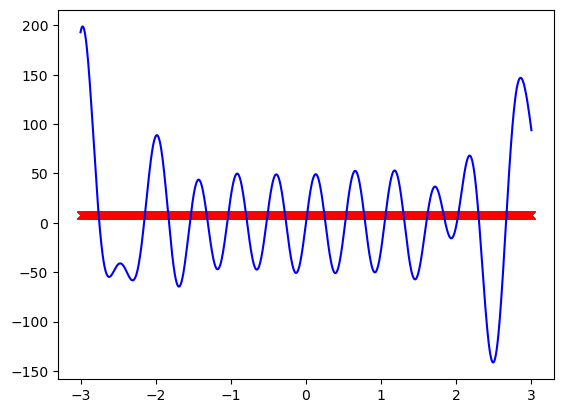

In [12]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [15]:
import scipy.io as sio
import numpy as np

for tune_reps in range(5):
    label = "Regr_stan_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re"])
    print(tune_reps," ",np.mean(re[:,-1]))

0   0.9994464270292926
1   0.99763099781341
2   0.9415191866126706
3   0.8455002530762602
4   0.9986059774433167


In [14]:
lr_tune[3]

0.008